In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(330282, 828)
(330282, 8)
validation
(36648, 828)
(36648, 8)
test
(45891, 828)
(45891, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/34 [..............................] - ETA: 52s - loss: 2.5206 - STD: 0.1449 - MAE: 0.2274

 4/34 [==>...........................] - ETA: 0s - loss: 1.8486 - STD: 0.1349 - MAE: 0.1915 

 5/34 [===>..........................] - ETA: 0s - loss: 1.7536 - STD: 0.1493 - MAE: 0.1810

 6/34 [====>.........................] - ETA: 1s - loss: 1.6832 - STD: 0.1623 - MAE: 0.1724

 7/34 [=====>........................] - ETA: 1s - loss: 1.6345 - STD: 0.1727 - MAE: 0.1660

 8/34 [======>.......................] - ETA: 1s - loss: 1.5958 - STD: 0.1805 - MAE: 0.1611

 9/34 [======>.......................] - ETA: 1s - loss: 1.5646 - STD: 0.1859 - MAE: 0.1576

10/34 [=======>......................] - ETA: 1s - loss: 1.5363 - STD: 0.1894 - MAE: 0.1551

11/34 [========>.....................] - ETA: 1s - loss: 1.5150 - STD: 0.1911 - MAE: 0.1536

12/34 [=========>....................] - ETA: 1s - loss: 1.4935 - STD: 0.1915 - MAE: 0.1525

13/34 [==========>...................] - ETA: 1s - loss: 1.4773 - STD: 0.1910 - MAE: 0.1521

14/34 [===========>..................] - ETA: 1s - loss: 1.4649 - STD: 0.1900 - MAE: 0.1519

15/34 [============>.................] - ETA: 0s - loss: 1.4527 - STD: 0.1889 - MAE: 0.1519

16/34 [=============>................] - ETA: 0s - loss: 1.4420 - STD: 0.1880 - MAE: 0.1518

17/34 [==============>...............] - ETA: 0s - loss: 1.4334 - STD: 0.1873 - MAE: 0.1517

18/34 [==============>...............] - ETA: 0s - loss: 1.4261 - STD: 0.1870 - MAE: 0.1515

19/34 [===============>..............] - ETA: 0s - loss: 1.4179 - STD: 0.1870 - MAE: 0.1511

20/34 [================>.............] - ETA: 0s - loss: 1.4108 - STD: 0.1875 - MAE: 0.1507

21/34 [=================>............] - ETA: 0s - loss: 1.4038 - STD: 0.1882 - MAE: 0.1501

22/34 [==================>...........] - ETA: 0s - loss: 1.3986 - STD: 0.1891 - MAE: 0.1495

23/34 [===================>..........] - ETA: 0s - loss: 1.3936 - STD: 0.1901 - MAE: 0.1489

24/34 [====================>.........] - ETA: 0s - loss: 1.3897 - STD: 0.1911 - MAE: 0.1484

25/34 [=====================>........] - ETA: 0s - loss: 1.3860 - STD: 0.1920 - MAE: 0.1479

26/34 [=====================>........] - ETA: 0s - loss: 1.3822 - STD: 0.1927 - MAE: 0.1474

27/34 [======================>.......] - ETA: 0s - loss: 1.3786 - STD: 0.1933 - MAE: 0.1470

28/34 [=======================>......] - ETA: 0s - loss: 1.3785 - STD: 0.1938 - MAE: 0.1467

31/34 [==========================>...] - ETA: 0s - loss: 1.3683 - STD: 0.1942 - MAE: 0.1462

33/34 [============================>.] - ETA: 0s - loss: 1.3628 - STD: 0.1941 - MAE: 0.1460

34/34 [==============================] - ETA: 0s - loss: 1.3601 - STD: 0.1940 - MAE: 0.1459

34/34 [==============================] - 5s 95ms/step - loss: 1.3601 - STD: 0.1940 - MAE: 0.1459 - val_loss: 1.2160 - val_STD: 0.1916 - val_MAE: 0.1394


Epoch 2/10000


 1/34 [..............................] - ETA: 3s - loss: 1.2764 - STD: 0.1916 - MAE: 0.1433

 2/34 [>.............................] - ETA: 1s - loss: 1.2741 - STD: 0.1924 - MAE: 0.1431

 3/34 [=>............................] - ETA: 1s - loss: 1.2800 - STD: 0.1934 - MAE: 0.1431

 4/34 [==>...........................] - ETA: 1s - loss: 1.2789 - STD: 0.1944 - MAE: 0.1426

 5/34 [===>..........................] - ETA: 1s - loss: 1.2745 - STD: 0.1955 - MAE: 0.1419

 6/34 [====>.........................] - ETA: 1s - loss: 1.2788 - STD: 0.1965 - MAE: 0.1418

 7/34 [=====>........................] - ETA: 1s - loss: 1.2762 - STD: 0.1973 - MAE: 0.1413

 8/34 [======>.......................] - ETA: 1s - loss: 1.2763 - STD: 0.1980 - MAE: 0.1411

 9/34 [======>.......................] - ETA: 1s - loss: 1.2751 - STD: 0.1985 - MAE: 0.1408

10/34 [=======>......................] - ETA: 1s - loss: 1.2757 - STD: 0.1989 - MAE: 0.1407

11/34 [========>.....................] - ETA: 1s - loss: 1.2776 - STD: 0.1990 - MAE: 0.1408

12/34 [=========>....................] - ETA: 1s - loss: 1.2783 - STD: 0.1990 - MAE: 0.1409

13/34 [==========>...................] - ETA: 1s - loss: 1.2774 - STD: 0.1988 - MAE: 0.1409

14/34 [===========>..................] - ETA: 1s - loss: 1.2773 - STD: 0.1985 - MAE: 0.1410

15/34 [============>.................] - ETA: 1s - loss: 1.2770 - STD: 0.1981 - MAE: 0.1411

16/34 [=============>................] - ETA: 1s - loss: 1.2770 - STD: 0.1978 - MAE: 0.1412

17/34 [==============>...............] - ETA: 0s - loss: 1.2768 - STD: 0.1975 - MAE: 0.1413

18/34 [==============>...............] - ETA: 0s - loss: 1.2756 - STD: 0.1973 - MAE: 0.1414

19/34 [===============>..............] - ETA: 0s - loss: 1.2739 - STD: 0.1972 - MAE: 0.1413

20/34 [================>.............] - ETA: 0s - loss: 1.2734 - STD: 0.1972 - MAE: 0.1413

21/34 [=================>............] - ETA: 0s - loss: 1.2736 - STD: 0.1973 - MAE: 0.1413

22/34 [==================>...........] - ETA: 0s - loss: 1.2743 - STD: 0.1975 - MAE: 0.1412

24/34 [====================>.........] - ETA: 0s - loss: 1.2752 - STD: 0.1979 - MAE: 0.1407

25/34 [=====================>........] - ETA: 0s - loss: 1.2758 - STD: 0.1983 - MAE: 0.1406

26/34 [=====================>........] - ETA: 0s - loss: 1.2756 - STD: 0.1986 - MAE: 0.1405

27/34 [======================>.......] - ETA: 0s - loss: 1.2753 - STD: 0.1988 - MAE: 0.1404

28/34 [=======================>......] - ETA: 0s - loss: 1.2759 - STD: 0.1989 - MAE: 0.1404

29/34 [========================>.....] - ETA: 0s - loss: 1.2761 - STD: 0.1989 - MAE: 0.1404

30/34 [=========================>....] - ETA: 0s - loss: 1.2763 - STD: 0.1988 - MAE: 0.1405

31/34 [==========================>...] - ETA: 0s - loss: 1.2759 - STD: 0.1986 - MAE: 0.1406

32/34 [===========================>..] - ETA: 0s - loss: 1.2756 - STD: 0.1983 - MAE: 0.1407

33/34 [============================>.] - ETA: 0s - loss: 1.2758 - STD: 0.1981 - MAE: 0.1408

34/34 [==============================] - ETA: 0s - loss: 1.2754 - STD: 0.1978 - MAE: 0.1409

34/34 [==============================] - 2s 60ms/step - loss: 1.2754 - STD: 0.1978 - MAE: 0.1409 - val_loss: 1.2012 - val_STD: 0.1915 - val_MAE: 0.1393


Epoch 3/10000


 1/34 [..............................] - ETA: 3s - loss: 1.2641 - STD: 0.1915 - MAE: 0.1432

 2/34 [>.............................] - ETA: 1s - loss: 1.2673 - STD: 0.1927 - MAE: 0.1428

 3/34 [=>............................] - ETA: 1s - loss: 1.2681 - STD: 0.1939 - MAE: 0.1423

 4/34 [==>...........................] - ETA: 1s - loss: 1.2710 - STD: 0.1952 - MAE: 0.1421

 5/34 [===>..........................] - ETA: 1s - loss: 1.2723 - STD: 0.1962 - MAE: 0.1418

 6/34 [====>.........................] - ETA: 1s - loss: 1.2708 - STD: 0.1969 - MAE: 0.1414

 7/34 [=====>........................] - ETA: 1s - loss: 1.2721 - STD: 0.1975 - MAE: 0.1412

 8/34 [======>.......................] - ETA: 1s - loss: 1.2708 - STD: 0.1978 - MAE: 0.1410

 9/34 [======>.......................] - ETA: 1s - loss: 1.2696 - STD: 0.1979 - MAE: 0.1409

10/34 [=======>......................] - ETA: 1s - loss: 1.2710 - STD: 0.1978 - MAE: 0.1410

11/34 [========>.....................] - ETA: 1s - loss: 1.2707 - STD: 0.1977 - MAE: 0.1411

12/34 [=========>....................] - ETA: 1s - loss: 1.2706 - STD: 0.1974 - MAE: 0.1411

13/34 [==========>...................] - ETA: 1s - loss: 1.2712 - STD: 0.1971 - MAE: 0.1413

14/34 [===========>..................] - ETA: 1s - loss: 1.2718 - STD: 0.1969 - MAE: 0.1414

15/34 [============>.................] - ETA: 1s - loss: 1.2715 - STD: 0.1966 - MAE: 0.1415

16/34 [=============>................] - ETA: 1s - loss: 1.2711 - STD: 0.1964 - MAE: 0.1416

17/34 [==============>...............] - ETA: 0s - loss: 1.2710 - STD: 0.1963 - MAE: 0.1416

18/34 [==============>...............] - ETA: 0s - loss: 1.2718 - STD: 0.1963 - MAE: 0.1416

19/34 [===============>..............] - ETA: 0s - loss: 1.2723 - STD: 0.1963 - MAE: 0.1417

20/34 [================>.............] - ETA: 0s - loss: 1.2717 - STD: 0.1964 - MAE: 0.1416

21/34 [=================>............] - ETA: 0s - loss: 1.2716 - STD: 0.1965 - MAE: 0.1416

22/34 [==================>...........] - ETA: 0s - loss: 1.2730 - STD: 0.1966 - MAE: 0.1416

23/34 [===================>..........] - ETA: 0s - loss: 1.2729 - STD: 0.1966 - MAE: 0.1416

24/34 [====================>.........] - ETA: 0s - loss: 1.2725 - STD: 0.1966 - MAE: 0.1416

25/34 [=====================>........] - ETA: 0s - loss: 1.2723 - STD: 0.1966 - MAE: 0.1416

26/34 [=====================>........] - ETA: 0s - loss: 1.2721 - STD: 0.1965 - MAE: 0.1416

27/34 [======================>.......] - ETA: 0s - loss: 1.2719 - STD: 0.1964 - MAE: 0.1416

28/34 [=======================>......] - ETA: 0s - loss: 1.2714 - STD: 0.1964 - MAE: 0.1416

29/34 [========================>.....] - ETA: 0s - loss: 1.2715 - STD: 0.1963 - MAE: 0.1416

31/34 [==========================>...] - ETA: 0s - loss: 1.2715 - STD: 0.1963 - MAE: 0.1419

32/34 [===========================>..] - ETA: 0s - loss: 1.2720 - STD: 0.1961 - MAE: 0.1420

33/34 [============================>.] - ETA: 0s - loss: 1.2726 - STD: 0.1960 - MAE: 0.1421

34/34 [==============================] - ETA: 0s - loss: 1.2728 - STD: 0.1958 - MAE: 0.1422

34/34 [==============================] - 2s 60ms/step - loss: 1.2728 - STD: 0.1958 - MAE: 0.1422 - val_loss: 1.2005 - val_STD: 0.1901 - val_MAE: 0.1398


Epoch 4/10000


 1/34 [..............................] - ETA: 0s - loss: 1.2780 - STD: 0.1901 - MAE: 0.1444

 2/34 [>.............................] - ETA: 2s - loss: 1.2884 - STD: 0.1906 - MAE: 0.1444

 3/34 [=>............................] - ETA: 2s - loss: 1.2697 - STD: 0.1913 - MAE: 0.1435

 4/34 [==>...........................] - ETA: 1s - loss: 1.2717 - STD: 0.1923 - MAE: 0.1432

 5/34 [===>..........................] - ETA: 1s - loss: 1.2711 - STD: 0.1934 - MAE: 0.1428

 6/34 [====>.........................] - ETA: 1s - loss: 1.2733 - STD: 0.1944 - MAE: 0.1425

 7/34 [=====>........................] - ETA: 1s - loss: 1.2716 - STD: 0.1951 - MAE: 0.1421

 8/34 [======>.......................] - ETA: 1s - loss: 1.2734 - STD: 0.1957 - MAE: 0.1420

 9/34 [======>.......................] - ETA: 1s - loss: 1.2733 - STD: 0.1960 - MAE: 0.1419

10/34 [=======>......................] - ETA: 1s - loss: 1.2726 - STD: 0.1960 - MAE: 0.1419

11/34 [========>.....................] - ETA: 1s - loss: 1.2725 - STD: 0.1959 - MAE: 0.1419

12/34 [=========>....................] - ETA: 1s - loss: 1.2714 - STD: 0.1957 - MAE: 0.1419

13/34 [==========>...................] - ETA: 1s - loss: 1.2709 - STD: 0.1955 - MAE: 0.1419

14/34 [===========>..................] - ETA: 1s - loss: 1.2712 - STD: 0.1954 - MAE: 0.1420

15/34 [============>.................] - ETA: 1s - loss: 1.2715 - STD: 0.1954 - MAE: 0.1420

16/34 [=============>................] - ETA: 1s - loss: 1.2720 - STD: 0.1954 - MAE: 0.1420

17/34 [==============>...............] - ETA: 1s - loss: 1.2714 - STD: 0.1955 - MAE: 0.1419

18/34 [==============>...............] - ETA: 0s - loss: 1.2713 - STD: 0.1956 - MAE: 0.1419

19/34 [===============>..............] - ETA: 0s - loss: 1.2715 - STD: 0.1957 - MAE: 0.1419

20/34 [================>.............] - ETA: 0s - loss: 1.2712 - STD: 0.1958 - MAE: 0.1418

21/34 [=================>............] - ETA: 0s - loss: 1.2714 - STD: 0.1959 - MAE: 0.1418

22/34 [==================>...........] - ETA: 0s - loss: 1.2719 - STD: 0.1958 - MAE: 0.1419

23/34 [===================>..........] - ETA: 0s - loss: 1.2708 - STD: 0.1957 - MAE: 0.1419

24/34 [====================>.........] - ETA: 0s - loss: 1.2704 - STD: 0.1956 - MAE: 0.1419

25/34 [=====================>........] - ETA: 0s - loss: 1.2708 - STD: 0.1955 - MAE: 0.1419

26/34 [=====================>........] - ETA: 0s - loss: 1.2704 - STD: 0.1955 - MAE: 0.1419

27/34 [======================>.......] - ETA: 0s - loss: 1.2693 - STD: 0.1956 - MAE: 0.1418

28/34 [=======================>......] - ETA: 0s - loss: 1.2687 - STD: 0.1957 - MAE: 0.1417

29/34 [========================>.....] - ETA: 0s - loss: 1.2683 - STD: 0.1958 - MAE: 0.1416

30/34 [=========================>....] - ETA: 0s - loss: 1.2679 - STD: 0.1959 - MAE: 0.1416

31/34 [==========================>...] - ETA: 0s - loss: 1.2675 - STD: 0.1960 - MAE: 0.1415

32/34 [===========================>..] - ETA: 0s - loss: 1.2672 - STD: 0.1960 - MAE: 0.1415

33/34 [============================>.] - ETA: 0s - loss: 1.2669 - STD: 0.1959 - MAE: 0.1415

34/34 [==============================] - ETA: 0s - loss: 1.2665 - STD: 0.1958 - MAE: 0.1415

34/34 [==============================] - 2s 63ms/step - loss: 1.2665 - STD: 0.1958 - MAE: 0.1415 - val_loss: 1.1759 - val_STD: 0.1936 - val_MAE: 0.1371


Epoch 5/10000


 1/34 [..............................] - ETA: 3s - loss: 1.2640 - STD: 0.1929 - MAE: 0.1425

 2/34 [>.............................] - ETA: 1s - loss: 1.2612 - STD: 0.1932 - MAE: 0.1420

 3/34 [=>............................] - ETA: 1s - loss: 1.2569 - STD: 0.1937 - MAE: 0.1416

 4/34 [==>...........................] - ETA: 1s - loss: 1.2530 - STD: 0.1946 - MAE: 0.1411

 5/34 [===>..........................] - ETA: 1s - loss: 1.2504 - STD: 0.1954 - MAE: 0.1407

 6/34 [====>.........................] - ETA: 1s - loss: 1.2492 - STD: 0.1960 - MAE: 0.1404

 7/34 [=====>........................] - ETA: 1s - loss: 1.2438 - STD: 0.1961 - MAE: 0.1401

 8/34 [======>.......................] - ETA: 1s - loss: 1.2435 - STD: 0.1962 - MAE: 0.1401

 9/34 [======>.......................] - ETA: 1s - loss: 1.2446 - STD: 0.1962 - MAE: 0.1401

10/34 [=======>......................] - ETA: 1s - loss: 1.2443 - STD: 0.1960 - MAE: 0.1402

11/34 [========>.....................] - ETA: 1s - loss: 1.2441 - STD: 0.1959 - MAE: 0.1402

12/34 [=========>....................] - ETA: 1s - loss: 1.2435 - STD: 0.1960 - MAE: 0.1401

13/34 [==========>...................] - ETA: 1s - loss: 1.2423 - STD: 0.1962 - MAE: 0.1400

14/34 [===========>..................] - ETA: 1s - loss: 1.2415 - STD: 0.1965 - MAE: 0.1398

15/34 [============>.................] - ETA: 1s - loss: 1.2415 - STD: 0.1966 - MAE: 0.1398

16/34 [=============>................] - ETA: 1s - loss: 1.2415 - STD: 0.1967 - MAE: 0.1398

17/34 [==============>...............] - ETA: 0s - loss: 1.2405 - STD: 0.1966 - MAE: 0.1398

18/34 [==============>...............] - ETA: 0s - loss: 1.2395 - STD: 0.1966 - MAE: 0.1397

19/34 [===============>..............] - ETA: 0s - loss: 1.2388 - STD: 0.1965 - MAE: 0.1397

20/34 [================>.............] - ETA: 0s - loss: 1.2382 - STD: 0.1965 - MAE: 0.1397

21/34 [=================>............] - ETA: 0s - loss: 1.2374 - STD: 0.1967 - MAE: 0.1396

22/34 [==================>...........] - ETA: 0s - loss: 1.2366 - STD: 0.1969 - MAE: 0.1395

23/34 [===================>..........] - ETA: 0s - loss: 1.2359 - STD: 0.1970 - MAE: 0.1394

24/34 [====================>.........] - ETA: 0s - loss: 1.2347 - STD: 0.1971 - MAE: 0.1393

25/34 [=====================>........] - ETA: 0s - loss: 1.2335 - STD: 0.1973 - MAE: 0.1392

26/34 [=====================>........] - ETA: 0s - loss: 1.2324 - STD: 0.1975 - MAE: 0.1390

27/34 [======================>.......] - ETA: 0s - loss: 1.2313 - STD: 0.1978 - MAE: 0.1389

28/34 [=======================>......] - ETA: 0s - loss: 1.2304 - STD: 0.1979 - MAE: 0.1388

29/34 [========================>.....] - ETA: 0s - loss: 1.2290 - STD: 0.1979 - MAE: 0.1387

30/34 [=========================>....] - ETA: 0s - loss: 1.2280 - STD: 0.1980 - MAE: 0.1386

32/34 [===========================>..] - ETA: 0s - loss: 1.2273 - STD: 0.1988 - MAE: 0.1382

33/34 [============================>.] - ETA: 0s - loss: 1.2272 - STD: 0.1991 - MAE: 0.1381

34/34 [==============================] - ETA: 0s - loss: 1.2263 - STD: 0.1988 - MAE: 0.1382

34/34 [==============================] - 2s 60ms/step - loss: 1.2263 - STD: 0.1988 - MAE: 0.1382 - val_loss: 1.1190 - val_STD: 0.1961 - val_MAE: 0.1337


Epoch 6/10000


 1/34 [..............................] - ETA: 3s - loss: 1.2159 - STD: 0.1873 - MAE: 0.1427

 2/34 [>.............................] - ETA: 1s - loss: 1.2091 - STD: 0.1943 - MAE: 0.1396

 3/34 [=>............................] - ETA: 1s - loss: 1.2044 - STD: 0.2008 - MAE: 0.1368

 4/34 [==>...........................] - ETA: 1s - loss: 1.1987 - STD: 0.2037 - MAE: 0.1355

 5/34 [===>..........................] - ETA: 1s - loss: 1.1977 - STD: 0.2026 - MAE: 0.1359

 7/34 [=====>........................] - ETA: 1s - loss: 1.1961 - STD: 0.2012 - MAE: 0.1357

 8/34 [======>.......................] - ETA: 1s - loss: 1.1961 - STD: 0.2034 - MAE: 0.1349

 9/34 [======>.......................] - ETA: 1s - loss: 1.1936 - STD: 0.2044 - MAE: 0.1345

10/34 [=======>......................] - ETA: 1s - loss: 1.1908 - STD: 0.2041 - MAE: 0.1346

11/34 [========>.....................] - ETA: 1s - loss: 1.1899 - STD: 0.2032 - MAE: 0.1349

12/34 [=========>....................] - ETA: 1s - loss: 1.1890 - STD: 0.2032 - MAE: 0.1349

13/34 [==========>...................] - ETA: 1s - loss: 1.1891 - STD: 0.2040 - MAE: 0.1346

14/34 [===========>..................] - ETA: 1s - loss: 1.1879 - STD: 0.2045 - MAE: 0.1344

15/34 [============>.................] - ETA: 1s - loss: 1.1867 - STD: 0.2041 - MAE: 0.1346

16/34 [=============>................] - ETA: 0s - loss: 1.1859 - STD: 0.2034 - MAE: 0.1349

17/34 [==============>...............] - ETA: 0s - loss: 1.1843 - STD: 0.2033 - MAE: 0.1349

18/34 [==============>...............] - ETA: 0s - loss: 1.1832 - STD: 0.2038 - MAE: 0.1347

19/34 [===============>..............] - ETA: 0s - loss: 1.1812 - STD: 0.2040 - MAE: 0.1345

20/34 [================>.............] - ETA: 0s - loss: 1.1792 - STD: 0.2037 - MAE: 0.1346

21/34 [=================>............] - ETA: 0s - loss: 1.1779 - STD: 0.2036 - MAE: 0.1346

22/34 [==================>...........] - ETA: 0s - loss: 1.1769 - STD: 0.2040 - MAE: 0.1344

23/34 [===================>..........] - ETA: 0s - loss: 1.1756 - STD: 0.2043 - MAE: 0.1343

24/34 [====================>.........] - ETA: 0s - loss: 1.1745 - STD: 0.2042 - MAE: 0.1343

25/34 [=====================>........] - ETA: 0s - loss: 1.1733 - STD: 0.2041 - MAE: 0.1343

26/34 [=====================>........] - ETA: 0s - loss: 1.1723 - STD: 0.2042 - MAE: 0.1343

27/34 [======================>.......] - ETA: 0s - loss: 1.1710 - STD: 0.2043 - MAE: 0.1342

28/34 [=======================>......] - ETA: 0s - loss: 1.1698 - STD: 0.2042 - MAE: 0.1343

29/34 [========================>.....] - ETA: 0s - loss: 1.1683 - STD: 0.2041 - MAE: 0.1342

30/34 [=========================>....] - ETA: 0s - loss: 1.1669 - STD: 0.2042 - MAE: 0.1342

31/34 [==========================>...] - ETA: 0s - loss: 1.1653 - STD: 0.2044 - MAE: 0.1341

32/34 [===========================>..] - ETA: 0s - loss: 1.1638 - STD: 0.2045 - MAE: 0.1340

33/34 [============================>.] - ETA: 0s - loss: 1.1625 - STD: 0.2045 - MAE: 0.1339

34/34 [==============================] - ETA: 0s - loss: 1.1608 - STD: 0.2048 - MAE: 0.1338

34/34 [==============================] - 2s 60ms/step - loss: 1.1608 - STD: 0.2048 - MAE: 0.1338 - val_loss: 1.0297 - val_STD: 0.2085 - val_MAE: 0.1263


Epoch 7/10000


 1/34 [..............................] - ETA: 3s - loss: 1.1285 - STD: 0.2036 - MAE: 0.1340

 2/34 [>.............................] - ETA: 1s - loss: 1.1225 - STD: 0.2037 - MAE: 0.1337

 3/34 [=>............................] - ETA: 1s - loss: 1.1169 - STD: 0.2052 - MAE: 0.1327

 4/34 [==>...........................] - ETA: 1s - loss: 1.1149 - STD: 0.2046 - MAE: 0.1327

 5/34 [===>..........................] - ETA: 1s - loss: 1.1143 - STD: 0.2040 - MAE: 0.1330

 6/34 [====>.........................] - ETA: 1s - loss: 1.1146 - STD: 0.2057 - MAE: 0.1324

 7/34 [=====>........................] - ETA: 1s - loss: 1.1148 - STD: 0.2056 - MAE: 0.1325

 8/34 [======>.......................] - ETA: 1s - loss: 1.1115 - STD: 0.2061 - MAE: 0.1321

 9/34 [======>.......................] - ETA: 1s - loss: 1.1120 - STD: 0.2068 - MAE: 0.1319

10/34 [=======>......................] - ETA: 1s - loss: 1.1118 - STD: 0.2061 - MAE: 0.1322

11/34 [========>.....................] - ETA: 1s - loss: 1.1106 - STD: 0.2056 - MAE: 0.1324

13/34 [==========>...................] - ETA: 1s - loss: 1.1113 - STD: 0.2067 - MAE: 0.1317

14/34 [===========>..................] - ETA: 1s - loss: 1.1102 - STD: 0.2063 - MAE: 0.1318

15/34 [============>.................] - ETA: 1s - loss: 1.1089 - STD: 0.2063 - MAE: 0.1318

16/34 [=============>................] - ETA: 0s - loss: 1.1094 - STD: 0.2070 - MAE: 0.1316

17/34 [==============>...............] - ETA: 0s - loss: 1.1090 - STD: 0.2073 - MAE: 0.1315

18/34 [==============>...............] - ETA: 0s - loss: 1.1084 - STD: 0.2067 - MAE: 0.1317

19/34 [===============>..............] - ETA: 0s - loss: 1.1072 - STD: 0.2065 - MAE: 0.1318

20/34 [================>.............] - ETA: 0s - loss: 1.1076 - STD: 0.2069 - MAE: 0.1317

21/34 [=================>............] - ETA: 0s - loss: 1.1068 - STD: 0.2068 - MAE: 0.1317

22/34 [==================>...........] - ETA: 0s - loss: 1.1060 - STD: 0.2063 - MAE: 0.1319

23/34 [===================>..........] - ETA: 0s - loss: 1.1045 - STD: 0.2063 - MAE: 0.1318

24/34 [====================>.........] - ETA: 0s - loss: 1.1039 - STD: 0.2067 - MAE: 0.1316

25/34 [=====================>........] - ETA: 0s - loss: 1.1033 - STD: 0.2070 - MAE: 0.1315

26/34 [=====================>........] - ETA: 0s - loss: 1.1025 - STD: 0.2068 - MAE: 0.1316

27/34 [======================>.......] - ETA: 0s - loss: 1.1016 - STD: 0.2066 - MAE: 0.1316

28/34 [=======================>......] - ETA: 0s - loss: 1.1014 - STD: 0.2068 - MAE: 0.1316

29/34 [========================>.....] - ETA: 0s - loss: 1.1009 - STD: 0.2070 - MAE: 0.1315

30/34 [=========================>....] - ETA: 0s - loss: 1.0999 - STD: 0.2070 - MAE: 0.1315

31/34 [==========================>...] - ETA: 0s - loss: 1.0989 - STD: 0.2069 - MAE: 0.1315

32/34 [===========================>..] - ETA: 0s - loss: 1.0982 - STD: 0.2069 - MAE: 0.1314

33/34 [============================>.] - ETA: 0s - loss: 1.0977 - STD: 0.2071 - MAE: 0.1314

34/34 [==============================] - ETA: 0s - loss: 1.0967 - STD: 0.2073 - MAE: 0.1313

34/34 [==============================] - 2s 60ms/step - loss: 1.0967 - STD: 0.2073 - MAE: 0.1313 - val_loss: 0.9881 - val_STD: 0.2108 - val_MAE: 0.1246


Epoch 8/10000


 1/34 [..............................] - ETA: 2s - loss: 1.0627 - STD: 0.2059 - MAE: 0.1307

 2/34 [>.............................] - ETA: 1s - loss: 1.0799 - STD: 0.2038 - MAE: 0.1325

 3/34 [=>............................] - ETA: 1s - loss: 1.0776 - STD: 0.2054 - MAE: 0.1318

 4/34 [==>...........................] - ETA: 1s - loss: 1.0775 - STD: 0.2070 - MAE: 0.1311

 5/34 [===>..........................] - ETA: 1s - loss: 1.0735 - STD: 0.2070 - MAE: 0.1308

 6/34 [====>.........................] - ETA: 1s - loss: 1.0712 - STD: 0.2064 - MAE: 0.1310

 7/34 [=====>........................] - ETA: 1s - loss: 1.0700 - STD: 0.2070 - MAE: 0.1307

 8/34 [======>.......................] - ETA: 1s - loss: 1.0693 - STD: 0.2085 - MAE: 0.1301

 9/34 [======>.......................] - ETA: 1s - loss: 1.0692 - STD: 0.2090 - MAE: 0.1298

10/34 [=======>......................] - ETA: 1s - loss: 1.0715 - STD: 0.2086 - MAE: 0.1301

11/34 [========>.....................] - ETA: 1s - loss: 1.0709 - STD: 0.2079 - MAE: 0.1304

12/34 [=========>....................] - ETA: 1s - loss: 1.0704 - STD: 0.2078 - MAE: 0.1304

13/34 [==========>...................] - ETA: 1s - loss: 1.0701 - STD: 0.2081 - MAE: 0.1303

14/34 [===========>..................] - ETA: 1s - loss: 1.0696 - STD: 0.2082 - MAE: 0.1303

15/34 [============>.................] - ETA: 1s - loss: 1.0698 - STD: 0.2081 - MAE: 0.1304

16/34 [=============>................] - ETA: 1s - loss: 1.0693 - STD: 0.2080 - MAE: 0.1304

17/34 [==============>...............] - ETA: 0s - loss: 1.0689 - STD: 0.2084 - MAE: 0.1302

19/34 [===============>..............] - ETA: 0s - loss: 1.0698 - STD: 0.2081 - MAE: 0.1304

20/34 [================>.............] - ETA: 0s - loss: 1.0693 - STD: 0.2081 - MAE: 0.1304

21/34 [=================>............] - ETA: 0s - loss: 1.0687 - STD: 0.2087 - MAE: 0.1301

22/34 [==================>...........] - ETA: 0s - loss: 1.0682 - STD: 0.2090 - MAE: 0.1300

23/34 [===================>..........] - ETA: 0s - loss: 1.0676 - STD: 0.2085 - MAE: 0.1302

24/34 [====================>.........] - ETA: 0s - loss: 1.0674 - STD: 0.2081 - MAE: 0.1303

25/34 [=====================>........] - ETA: 0s - loss: 1.0668 - STD: 0.2082 - MAE: 0.1303

26/34 [=====================>........] - ETA: 0s - loss: 1.0669 - STD: 0.2087 - MAE: 0.1301

27/34 [======================>.......] - ETA: 0s - loss: 1.0663 - STD: 0.2089 - MAE: 0.1300

28/34 [=======================>......] - ETA: 0s - loss: 1.0651 - STD: 0.2088 - MAE: 0.1300

29/34 [========================>.....] - ETA: 0s - loss: 1.0649 - STD: 0.2086 - MAE: 0.1300

30/34 [=========================>....] - ETA: 0s - loss: 1.0643 - STD: 0.2085 - MAE: 0.1300

31/34 [==========================>...] - ETA: 0s - loss: 1.0636 - STD: 0.2087 - MAE: 0.1299

32/34 [===========================>..] - ETA: 0s - loss: 1.0628 - STD: 0.2088 - MAE: 0.1299

33/34 [============================>.] - ETA: 0s - loss: 1.0621 - STD: 0.2088 - MAE: 0.1298

34/34 [==============================] - ETA: 0s - loss: 1.0613 - STD: 0.2089 - MAE: 0.1298

34/34 [==============================] - 2s 61ms/step - loss: 1.0613 - STD: 0.2089 - MAE: 0.1298 - val_loss: 0.9609 - val_STD: 0.2199 - val_MAE: 0.1194


Epoch 9/10000


 1/34 [..............................] - ETA: 2s - loss: 1.0320 - STD: 0.2125 - MAE: 0.1265

 2/34 [>.............................] - ETA: 1s - loss: 1.0459 - STD: 0.2123 - MAE: 0.1276

 3/34 [=>............................] - ETA: 1s - loss: 1.0429 - STD: 0.2096 - MAE: 0.1286

 4/34 [==>...........................] - ETA: 1s - loss: 1.0429 - STD: 0.2092 - MAE: 0.1287

 5/34 [===>..........................] - ETA: 1s - loss: 1.0396 - STD: 0.2109 - MAE: 0.1280

 6/34 [====>.........................] - ETA: 1s - loss: 1.0403 - STD: 0.2124 - MAE: 0.1274

 7/34 [=====>........................] - ETA: 1s - loss: 1.0390 - STD: 0.2118 - MAE: 0.1276

 8/34 [======>.......................] - ETA: 1s - loss: 1.0375 - STD: 0.2105 - MAE: 0.1281

 9/34 [======>.......................] - ETA: 1s - loss: 1.0359 - STD: 0.2105 - MAE: 0.1280

10/34 [=======>......................] - ETA: 1s - loss: 1.0361 - STD: 0.2118 - MAE: 0.1275

11/34 [========>.....................] - ETA: 1s - loss: 1.0353 - STD: 0.2119 - MAE: 0.1274

12/34 [=========>....................] - ETA: 1s - loss: 1.0355 - STD: 0.2109 - MAE: 0.1278

13/34 [==========>...................] - ETA: 1s - loss: 1.0343 - STD: 0.2104 - MAE: 0.1279

14/34 [===========>..................] - ETA: 1s - loss: 1.0337 - STD: 0.2110 - MAE: 0.1276

15/34 [============>.................] - ETA: 1s - loss: 1.0322 - STD: 0.2114 - MAE: 0.1274

16/34 [=============>................] - ETA: 1s - loss: 1.0315 - STD: 0.2113 - MAE: 0.1274

17/34 [==============>...............] - ETA: 0s - loss: 1.0306 - STD: 0.2115 - MAE: 0.1273

19/34 [===============>..............] - ETA: 0s - loss: 1.0300 - STD: 0.2119 - MAE: 0.1269

20/34 [================>.............] - ETA: 0s - loss: 1.0301 - STD: 0.2120 - MAE: 0.1270

21/34 [=================>............] - ETA: 0s - loss: 1.0302 - STD: 0.2117 - MAE: 0.1270

22/34 [==================>...........] - ETA: 0s - loss: 1.0296 - STD: 0.2115 - MAE: 0.1271

23/34 [===================>..........] - ETA: 0s - loss: 1.0281 - STD: 0.2117 - MAE: 0.1270

24/34 [====================>.........] - ETA: 0s - loss: 1.0273 - STD: 0.2119 - MAE: 0.1268

25/34 [=====================>........] - ETA: 0s - loss: 1.0264 - STD: 0.2118 - MAE: 0.1268

26/34 [=====================>........] - ETA: 0s - loss: 1.0255 - STD: 0.2122 - MAE: 0.1266

27/34 [======================>.......] - ETA: 0s - loss: 1.0250 - STD: 0.2124 - MAE: 0.1265

28/34 [=======================>......] - ETA: 0s - loss: 1.0241 - STD: 0.2124 - MAE: 0.1264

29/34 [========================>.....] - ETA: 0s - loss: 1.0230 - STD: 0.2128 - MAE: 0.1262

30/34 [=========================>....] - ETA: 0s - loss: 1.0218 - STD: 0.2131 - MAE: 0.1260

31/34 [==========================>...] - ETA: 0s - loss: 1.0208 - STD: 0.2130 - MAE: 0.1260

32/34 [===========================>..] - ETA: 0s - loss: 1.0199 - STD: 0.2133 - MAE: 0.1258

33/34 [============================>.] - ETA: 0s - loss: 1.0188 - STD: 0.2135 - MAE: 0.1257

34/34 [==============================] - ETA: 0s - loss: 1.0186 - STD: 0.2133 - MAE: 0.1258

34/34 [==============================] - 2s 60ms/step - loss: 1.0186 - STD: 0.2133 - MAE: 0.1258 - val_loss: 0.9027 - val_STD: 0.2170 - val_MAE: 0.1175


Epoch 10/10000


 1/34 [..............................] - ETA: 3s - loss: 0.9750 - STD: 0.2149 - MAE: 0.1227

 2/34 [>.............................] - ETA: 1s - loss: 0.9885 - STD: 0.2231 - MAE: 0.1200

 3/34 [=>............................] - ETA: 1s - loss: 0.9899 - STD: 0.2168 - MAE: 0.1228

 4/34 [==>...........................] - ETA: 1s - loss: 0.9906 - STD: 0.2170 - MAE: 0.1227

 5/34 [===>..........................] - ETA: 1s - loss: 0.9914 - STD: 0.2199 - MAE: 0.1213

 6/34 [====>.........................] - ETA: 1s - loss: 0.9910 - STD: 0.2188 - MAE: 0.1218

 7/34 [=====>........................] - ETA: 1s - loss: 0.9925 - STD: 0.2182 - MAE: 0.1222

 9/34 [======>.......................] - ETA: 1s - loss: 0.9938 - STD: 0.2177 - MAE: 0.1231

10/34 [=======>......................] - ETA: 1s - loss: 0.9935 - STD: 0.2167 - MAE: 0.1235

11/34 [========>.....................] - ETA: 1s - loss: 0.9940 - STD: 0.2176 - MAE: 0.1231

12/34 [=========>....................] - ETA: 1s - loss: 0.9934 - STD: 0.2180 - MAE: 0.1228

13/34 [==========>...................] - ETA: 1s - loss: 0.9923 - STD: 0.2171 - MAE: 0.1231

14/34 [===========>..................] - ETA: 1s - loss: 0.9938 - STD: 0.2167 - MAE: 0.1234

15/34 [============>.................] - ETA: 0s - loss: 0.9949 - STD: 0.2171 - MAE: 0.1232

16/34 [=============>................] - ETA: 0s - loss: 0.9940 - STD: 0.2175 - MAE: 0.1230

17/34 [==============>...............] - ETA: 0s - loss: 0.9923 - STD: 0.2176 - MAE: 0.1229

18/34 [==============>...............] - ETA: 0s - loss: 0.9907 - STD: 0.2176 - MAE: 0.1228

19/34 [===============>..............] - ETA: 0s - loss: 0.9898 - STD: 0.2177 - MAE: 0.1227

20/34 [================>.............] - ETA: 0s - loss: 0.9878 - STD: 0.2177 - MAE: 0.1226

21/34 [=================>............] - ETA: 0s - loss: 0.9866 - STD: 0.2180 - MAE: 0.1224

22/34 [==================>...........] - ETA: 0s - loss: 0.9859 - STD: 0.2182 - MAE: 0.1222

23/34 [===================>..........] - ETA: 0s - loss: 0.9856 - STD: 0.2180 - MAE: 0.1223

24/34 [====================>.........] - ETA: 0s - loss: 0.9851 - STD: 0.2181 - MAE: 0.1222

25/34 [=====================>........] - ETA: 0s - loss: 0.9842 - STD: 0.2185 - MAE: 0.1219

26/34 [=====================>........] - ETA: 0s - loss: 0.9838 - STD: 0.2186 - MAE: 0.1219

27/34 [======================>.......] - ETA: 0s - loss: 0.9826 - STD: 0.2185 - MAE: 0.1218

28/34 [=======================>......] - ETA: 0s - loss: 0.9819 - STD: 0.2189 - MAE: 0.1216

29/34 [========================>.....] - ETA: 0s - loss: 0.9814 - STD: 0.2189 - MAE: 0.1216

30/34 [=========================>....] - ETA: 0s - loss: 0.9808 - STD: 0.2188 - MAE: 0.1216

31/34 [==========================>...] - ETA: 0s - loss: 0.9809 - STD: 0.2191 - MAE: 0.1215

32/34 [===========================>..] - ETA: 0s - loss: 0.9809 - STD: 0.2189 - MAE: 0.1216

33/34 [============================>.] - ETA: 0s - loss: 0.9812 - STD: 0.2186 - MAE: 0.1217

34/34 [==============================] - ETA: 0s - loss: 0.9809 - STD: 0.2190 - MAE: 0.1215

34/34 [==============================] - 2s 58ms/step - loss: 0.9809 - STD: 0.2190 - MAE: 0.1215 - val_loss: 0.8771 - val_STD: 0.2176 - val_MAE: 0.1159


Epoch 11/10000


 1/34 [..............................] - ETA: 2s - loss: 0.9566 - STD: 0.2142 - MAE: 0.1224

 2/34 [>.............................] - ETA: 1s - loss: 0.9531 - STD: 0.2149 - MAE: 0.1218

 3/34 [=>............................] - ETA: 1s - loss: 0.9543 - STD: 0.2214 - MAE: 0.1190

 4/34 [==>...........................] - ETA: 1s - loss: 0.9545 - STD: 0.2194 - MAE: 0.1199

 5/34 [===>..........................] - ETA: 1s - loss: 0.9563 - STD: 0.2188 - MAE: 0.1203

 6/34 [====>.........................] - ETA: 1s - loss: 0.9577 - STD: 0.2208 - MAE: 0.1194

 7/34 [=====>........................] - ETA: 1s - loss: 0.9576 - STD: 0.2206 - MAE: 0.1195

 8/34 [======>.......................] - ETA: 1s - loss: 0.9560 - STD: 0.2195 - MAE: 0.1199

 9/34 [======>.......................] - ETA: 1s - loss: 0.9570 - STD: 0.2207 - MAE: 0.1194

10/34 [=======>......................] - ETA: 1s - loss: 0.9564 - STD: 0.2208 - MAE: 0.1193

11/34 [========>.....................] - ETA: 1s - loss: 0.9559 - STD: 0.2199 - MAE: 0.1197

12/34 [=========>....................] - ETA: 1s - loss: 0.9548 - STD: 0.2209 - MAE: 0.1191

13/34 [==========>...................] - ETA: 1s - loss: 0.9545 - STD: 0.2215 - MAE: 0.1189

14/34 [===========>..................] - ETA: 1s - loss: 0.9557 - STD: 0.2208 - MAE: 0.1192

15/34 [============>.................] - ETA: 1s - loss: 0.9543 - STD: 0.2210 - MAE: 0.1191

17/34 [==============>...............] - ETA: 0s - loss: 0.9590 - STD: 0.2202 - MAE: 0.1199

18/34 [==============>...............] - ETA: 0s - loss: 0.9590 - STD: 0.2198 - MAE: 0.1201

19/34 [===============>..............] - ETA: 0s - loss: 0.9597 - STD: 0.2213 - MAE: 0.1194

20/34 [================>.............] - ETA: 0s - loss: 0.9591 - STD: 0.2215 - MAE: 0.1193

21/34 [=================>............] - ETA: 0s - loss: 0.9592 - STD: 0.2207 - MAE: 0.1196

22/34 [==================>...........] - ETA: 0s - loss: 0.9598 - STD: 0.2207 - MAE: 0.1196

23/34 [===================>..........] - ETA: 0s - loss: 0.9591 - STD: 0.2213 - MAE: 0.1193

24/34 [====================>.........] - ETA: 0s - loss: 0.9593 - STD: 0.2216 - MAE: 0.1192

25/34 [=====================>........] - ETA: 0s - loss: 0.9581 - STD: 0.2214 - MAE: 0.1192

26/34 [=====================>........] - ETA: 0s - loss: 0.9587 - STD: 0.2213 - MAE: 0.1193

27/34 [======================>.......] - ETA: 0s - loss: 0.9579 - STD: 0.2213 - MAE: 0.1192

28/34 [=======================>......] - ETA: 0s - loss: 0.9588 - STD: 0.2215 - MAE: 0.1192

29/34 [========================>.....] - ETA: 0s - loss: 0.9576 - STD: 0.2216 - MAE: 0.1190

30/34 [=========================>....] - ETA: 0s - loss: 0.9570 - STD: 0.2216 - MAE: 0.1190

31/34 [==========================>...] - ETA: 0s - loss: 0.9561 - STD: 0.2215 - MAE: 0.1190

32/34 [===========================>..] - ETA: 0s - loss: 0.9559 - STD: 0.2216 - MAE: 0.1189

33/34 [============================>.] - ETA: 0s - loss: 0.9552 - STD: 0.2218 - MAE: 0.1188

34/34 [==============================] - ETA: 0s - loss: 0.9542 - STD: 0.2218 - MAE: 0.1187

34/34 [==============================] - 2s 59ms/step - loss: 0.9542 - STD: 0.2218 - MAE: 0.1187 - val_loss: 0.8657 - val_STD: 0.2186 - val_MAE: 0.1151


Epoch 12/10000


 1/34 [..............................] - ETA: 3s - loss: 0.9407 - STD: 0.2137 - MAE: 0.1218

 2/34 [>.............................] - ETA: 1s - loss: 0.9314 - STD: 0.2171 - MAE: 0.1196

 3/34 [=>............................] - ETA: 1s - loss: 0.9332 - STD: 0.2235 - MAE: 0.1169

 4/34 [==>...........................] - ETA: 1s - loss: 0.9309 - STD: 0.2241 - MAE: 0.1165

 5/34 [===>..........................] - ETA: 1s - loss: 0.9301 - STD: 0.2226 - MAE: 0.1170

 6/34 [====>.........................] - ETA: 1s - loss: 0.9317 - STD: 0.2231 - MAE: 0.1169

 7/34 [=====>........................] - ETA: 1s - loss: 0.9312 - STD: 0.2240 - MAE: 0.1165

 8/34 [======>.......................] - ETA: 1s - loss: 0.9331 - STD: 0.2238 - MAE: 0.1166

 9/34 [======>.......................] - ETA: 1s - loss: 0.9320 - STD: 0.2236 - MAE: 0.1167

10/34 [=======>......................] - ETA: 1s - loss: 0.9304 - STD: 0.2240 - MAE: 0.1164

11/34 [========>.....................] - ETA: 1s - loss: 0.9306 - STD: 0.2241 - MAE: 0.1163

12/34 [=========>....................] - ETA: 1s - loss: 0.9295 - STD: 0.2240 - MAE: 0.1163

13/34 [==========>...................] - ETA: 1s - loss: 0.9281 - STD: 0.2244 - MAE: 0.1161

14/34 [===========>..................] - ETA: 1s - loss: 0.9263 - STD: 0.2247 - MAE: 0.1159

15/34 [============>.................] - ETA: 1s - loss: 0.9259 - STD: 0.2244 - MAE: 0.1159

16/34 [=============>................] - ETA: 1s - loss: 0.9254 - STD: 0.2243 - MAE: 0.1160

18/34 [==============>...............] - ETA: 0s - loss: 0.9243 - STD: 0.2249 - MAE: 0.1157

19/34 [===============>..............] - ETA: 0s - loss: 0.9248 - STD: 0.2243 - MAE: 0.1160

20/34 [================>.............] - ETA: 0s - loss: 0.9248 - STD: 0.2244 - MAE: 0.1159

21/34 [=================>............] - ETA: 0s - loss: 0.9232 - STD: 0.2250 - MAE: 0.1156

22/34 [==================>...........] - ETA: 0s - loss: 0.9227 - STD: 0.2249 - MAE: 0.1156

23/34 [===================>..........] - ETA: 0s - loss: 0.9229 - STD: 0.2244 - MAE: 0.1158

24/34 [====================>.........] - ETA: 0s - loss: 0.9222 - STD: 0.2247 - MAE: 0.1157

25/34 [=====================>........] - ETA: 0s - loss: 0.9219 - STD: 0.2253 - MAE: 0.1154

26/34 [=====================>........] - ETA: 0s - loss: 0.9214 - STD: 0.2250 - MAE: 0.1155

27/34 [======================>.......] - ETA: 0s - loss: 0.9214 - STD: 0.2248 - MAE: 0.1156

28/34 [=======================>......] - ETA: 0s - loss: 0.9208 - STD: 0.2252 - MAE: 0.1154

29/34 [========================>.....] - ETA: 0s - loss: 0.9197 - STD: 0.2253 - MAE: 0.1153

30/34 [=========================>....] - ETA: 0s - loss: 0.9191 - STD: 0.2251 - MAE: 0.1154

31/34 [==========================>...] - ETA: 0s - loss: 0.9182 - STD: 0.2252 - MAE: 0.1153

32/34 [===========================>..] - ETA: 0s - loss: 0.9181 - STD: 0.2255 - MAE: 0.1151

33/34 [============================>.] - ETA: 0s - loss: 0.9176 - STD: 0.2254 - MAE: 0.1152

34/34 [==============================] - ETA: 0s - loss: 0.9170 - STD: 0.2254 - MAE: 0.1151

34/34 [==============================] - 2s 60ms/step - loss: 0.9170 - STD: 0.2254 - MAE: 0.1151 - val_loss: 0.8265 - val_STD: 0.2354 - val_MAE: 0.1057


Epoch 13/10000


 1/34 [..............................] - ETA: 2s - loss: 0.8957 - STD: 0.2309 - MAE: 0.1116

 2/34 [>.............................] - ETA: 1s - loss: 0.8992 - STD: 0.2298 - MAE: 0.1124

 3/34 [=>............................] - ETA: 1s - loss: 0.8952 - STD: 0.2267 - MAE: 0.1136

 4/34 [==>...........................] - ETA: 1s - loss: 0.8986 - STD: 0.2273 - MAE: 0.1135

 5/34 [===>..........................] - ETA: 1s - loss: 0.8959 - STD: 0.2271 - MAE: 0.1135

 6/34 [====>.........................] - ETA: 1s - loss: 0.8950 - STD: 0.2265 - MAE: 0.1137

 7/34 [=====>........................] - ETA: 1s - loss: 0.8956 - STD: 0.2271 - MAE: 0.1134

 8/34 [======>.......................] - ETA: 1s - loss: 0.8940 - STD: 0.2270 - MAE: 0.1134

 9/34 [======>.......................] - ETA: 1s - loss: 0.8906 - STD: 0.2270 - MAE: 0.1132

10/34 [=======>......................] - ETA: 1s - loss: 0.8896 - STD: 0.2281 - MAE: 0.1126

11/34 [========>.....................] - ETA: 1s - loss: 0.8902 - STD: 0.2278 - MAE: 0.1128

12/34 [=========>....................] - ETA: 1s - loss: 0.8889 - STD: 0.2275 - MAE: 0.1128

14/34 [===========>..................] - ETA: 1s - loss: 0.8883 - STD: 0.2277 - MAE: 0.1129

15/34 [============>.................] - ETA: 1s - loss: 0.8872 - STD: 0.2275 - MAE: 0.1129

16/34 [=============>................] - ETA: 0s - loss: 0.8877 - STD: 0.2282 - MAE: 0.1126

17/34 [==============>...............] - ETA: 0s - loss: 0.8871 - STD: 0.2281 - MAE: 0.1127

18/34 [==============>...............] - ETA: 0s - loss: 0.8862 - STD: 0.2276 - MAE: 0.1128

19/34 [===============>..............] - ETA: 0s - loss: 0.8847 - STD: 0.2280 - MAE: 0.1126

20/34 [================>.............] - ETA: 0s - loss: 0.8830 - STD: 0.2285 - MAE: 0.1123

21/34 [=================>............] - ETA: 0s - loss: 0.8826 - STD: 0.2284 - MAE: 0.1123

22/34 [==================>...........] - ETA: 0s - loss: 0.8818 - STD: 0.2280 - MAE: 0.1125

23/34 [===================>..........] - ETA: 0s - loss: 0.8811 - STD: 0.2286 - MAE: 0.1122

24/34 [====================>.........] - ETA: 0s - loss: 0.8798 - STD: 0.2289 - MAE: 0.1120

25/34 [=====================>........] - ETA: 0s - loss: 0.8789 - STD: 0.2287 - MAE: 0.1121

26/34 [=====================>........] - ETA: 0s - loss: 0.8783 - STD: 0.2287 - MAE: 0.1120

27/34 [======================>.......] - ETA: 0s - loss: 0.8775 - STD: 0.2291 - MAE: 0.1118

28/34 [=======================>......] - ETA: 0s - loss: 0.8771 - STD: 0.2290 - MAE: 0.1119

29/34 [========================>.....] - ETA: 0s - loss: 0.8759 - STD: 0.2288 - MAE: 0.1119

30/34 [=========================>....] - ETA: 0s - loss: 0.8751 - STD: 0.2292 - MAE: 0.1117

31/34 [==========================>...] - ETA: 0s - loss: 0.8743 - STD: 0.2294 - MAE: 0.1116

32/34 [===========================>..] - ETA: 0s - loss: 0.8738 - STD: 0.2293 - MAE: 0.1116

33/34 [============================>.] - ETA: 0s - loss: 0.8727 - STD: 0.2293 - MAE: 0.1116

34/34 [==============================] - ETA: 0s - loss: 0.8722 - STD: 0.2295 - MAE: 0.1115

34/34 [==============================] - 2s 59ms/step - loss: 0.8722 - STD: 0.2295 - MAE: 0.1115 - val_loss: 0.7919 - val_STD: 0.2325 - val_MAE: 0.1060


Epoch 14/10000


 1/34 [..............................] - ETA: 3s - loss: 0.8578 - STD: 0.2267 - MAE: 0.1122

 2/34 [>.............................] - ETA: 1s - loss: 0.8633 - STD: 0.2290 - MAE: 0.1117

 3/34 [=>............................] - ETA: 1s - loss: 0.8592 - STD: 0.2285 - MAE: 0.1115

 4/34 [==>...........................] - ETA: 1s - loss: 0.8565 - STD: 0.2288 - MAE: 0.1113

 5/34 [===>..........................] - ETA: 1s - loss: 0.8544 - STD: 0.2309 - MAE: 0.1102

 6/34 [====>.........................] - ETA: 1s - loss: 0.8548 - STD: 0.2302 - MAE: 0.1105

 7/34 [=====>........................] - ETA: 1s - loss: 0.8518 - STD: 0.2294 - MAE: 0.1107

 8/34 [======>.......................] - ETA: 1s - loss: 0.8513 - STD: 0.2307 - MAE: 0.1102

 9/34 [======>.......................] - ETA: 1s - loss: 0.8513 - STD: 0.2314 - MAE: 0.1098

10/34 [=======>......................] - ETA: 1s - loss: 0.8501 - STD: 0.2306 - MAE: 0.1102

11/34 [========>.....................] - ETA: 1s - loss: 0.8471 - STD: 0.2311 - MAE: 0.1098

13/34 [==========>...................] - ETA: 1s - loss: 0.8459 - STD: 0.2313 - MAE: 0.1099

14/34 [===========>..................] - ETA: 1s - loss: 0.8460 - STD: 0.2311 - MAE: 0.1100

15/34 [============>.................] - ETA: 1s - loss: 0.8455 - STD: 0.2311 - MAE: 0.1099

16/34 [=============>................] - ETA: 0s - loss: 0.8453 - STD: 0.2311 - MAE: 0.1099

17/34 [==============>...............] - ETA: 0s - loss: 0.8455 - STD: 0.2315 - MAE: 0.1097

18/34 [==============>...............] - ETA: 0s - loss: 0.8457 - STD: 0.2314 - MAE: 0.1098

19/34 [===============>..............] - ETA: 0s - loss: 0.8451 - STD: 0.2312 - MAE: 0.1098

20/34 [================>.............] - ETA: 0s - loss: 0.8458 - STD: 0.2318 - MAE: 0.1096

21/34 [=================>............] - ETA: 0s - loss: 0.8447 - STD: 0.2317 - MAE: 0.1096

22/34 [==================>...........] - ETA: 0s - loss: 0.8444 - STD: 0.2315 - MAE: 0.1096

23/34 [===================>..........] - ETA: 0s - loss: 0.8436 - STD: 0.2320 - MAE: 0.1094

24/34 [====================>.........] - ETA: 0s - loss: 0.8434 - STD: 0.2320 - MAE: 0.1093

25/34 [=====================>........] - ETA: 0s - loss: 0.8436 - STD: 0.2318 - MAE: 0.1095

26/34 [=====================>........] - ETA: 0s - loss: 0.8434 - STD: 0.2319 - MAE: 0.1094

27/34 [======================>.......] - ETA: 0s - loss: 0.8432 - STD: 0.2319 - MAE: 0.1094

28/34 [=======================>......] - ETA: 0s - loss: 0.8425 - STD: 0.2320 - MAE: 0.1093

29/34 [========================>.....] - ETA: 0s - loss: 0.8417 - STD: 0.2322 - MAE: 0.1092

30/34 [=========================>....] - ETA: 0s - loss: 0.8416 - STD: 0.2321 - MAE: 0.1092

31/34 [==========================>...] - ETA: 0s - loss: 0.8415 - STD: 0.2321 - MAE: 0.1092

32/34 [===========================>..] - ETA: 0s - loss: 0.8410 - STD: 0.2323 - MAE: 0.1091

33/34 [============================>.] - ETA: 0s - loss: 0.8403 - STD: 0.2323 - MAE: 0.1090

34/34 [==============================] - ETA: 0s - loss: 0.8400 - STD: 0.2322 - MAE: 0.1091

34/34 [==============================] - 2s 59ms/step - loss: 0.8400 - STD: 0.2322 - MAE: 0.1091 - val_loss: 0.7650 - val_STD: 0.2449 - val_MAE: 0.0990


Epoch 15/10000


 1/34 [..............................] - ETA: 2s - loss: 0.8310 - STD: 0.2410 - MAE: 0.1045

 2/34 [>.............................] - ETA: 1s - loss: 0.8363 - STD: 0.2373 - MAE: 0.1065

 3/34 [=>............................] - ETA: 1s - loss: 0.8307 - STD: 0.2343 - MAE: 0.1076

 4/34 [==>...........................] - ETA: 1s - loss: 0.8308 - STD: 0.2352 - MAE: 0.1073

 5/34 [===>..........................] - ETA: 1s - loss: 0.8279 - STD: 0.2355 - MAE: 0.1069

 6/34 [====>.........................] - ETA: 1s - loss: 0.8263 - STD: 0.2347 - MAE: 0.1073

 7/34 [=====>........................] - ETA: 1s - loss: 0.8264 - STD: 0.2345 - MAE: 0.1073

 8/34 [======>.......................] - ETA: 1s - loss: 0.8241 - STD: 0.2350 - MAE: 0.1070

 9/34 [======>.......................] - ETA: 1s - loss: 0.8232 - STD: 0.2348 - MAE: 0.1070

10/34 [=======>......................] - ETA: 1s - loss: 0.8238 - STD: 0.2345 - MAE: 0.1072

11/34 [========>.....................] - ETA: 1s - loss: 0.8242 - STD: 0.2345 - MAE: 0.1072

12/34 [=========>....................] - ETA: 1s - loss: 0.8235 - STD: 0.2346 - MAE: 0.1071

13/34 [==========>...................] - ETA: 1s - loss: 0.8235 - STD: 0.2346 - MAE: 0.1071

14/34 [===========>..................] - ETA: 1s - loss: 0.8244 - STD: 0.2345 - MAE: 0.1073

15/34 [============>.................] - ETA: 1s - loss: 0.8249 - STD: 0.2344 - MAE: 0.1073

16/34 [=============>................] - ETA: 1s - loss: 0.8243 - STD: 0.2346 - MAE: 0.1072

17/34 [==============>...............] - ETA: 0s - loss: 0.8237 - STD: 0.2346 - MAE: 0.1072

18/34 [==============>...............] - ETA: 0s - loss: 0.8234 - STD: 0.2346 - MAE: 0.1071

19/34 [===============>..............] - ETA: 0s - loss: 0.8240 - STD: 0.2348 - MAE: 0.1071

20/34 [================>.............] - ETA: 0s - loss: 0.8244 - STD: 0.2345 - MAE: 0.1073

21/34 [=================>............] - ETA: 0s - loss: 0.8244 - STD: 0.2346 - MAE: 0.1072

22/34 [==================>...........] - ETA: 0s - loss: 0.8238 - STD: 0.2347 - MAE: 0.1071

23/34 [===================>..........] - ETA: 0s - loss: 0.8236 - STD: 0.2345 - MAE: 0.1072

24/34 [====================>.........] - ETA: 0s - loss: 0.8239 - STD: 0.2348 - MAE: 0.1071

25/34 [=====================>........] - ETA: 0s - loss: 0.8237 - STD: 0.2346 - MAE: 0.1072

26/34 [=====================>........] - ETA: 0s - loss: 0.8227 - STD: 0.2348 - MAE: 0.1070

27/34 [======================>.......] - ETA: 0s - loss: 0.8227 - STD: 0.2350 - MAE: 0.1069

28/34 [=======================>......] - ETA: 0s - loss: 0.8228 - STD: 0.2346 - MAE: 0.1071

30/34 [=========================>....] - ETA: 0s - loss: 0.8232 - STD: 0.2351 - MAE: 0.1069

31/34 [==========================>...] - ETA: 0s - loss: 0.8236 - STD: 0.2347 - MAE: 0.1071

32/34 [===========================>..] - ETA: 0s - loss: 0.8236 - STD: 0.2346 - MAE: 0.1072

33/34 [============================>.] - ETA: 0s - loss: 0.8245 - STD: 0.2351 - MAE: 0.1070

34/34 [==============================] - ETA: 0s - loss: 0.8245 - STD: 0.2348 - MAE: 0.1072

34/34 [==============================] - 2s 60ms/step - loss: 0.8245 - STD: 0.2348 - MAE: 0.1072 - val_loss: 0.7612 - val_STD: 0.2348 - val_MAE: 0.1040


Epoch 16/10000


 1/34 [..............................] - ETA: 2s - loss: 0.8309 - STD: 0.2274 - MAE: 0.1112

 2/34 [>.............................] - ETA: 1s - loss: 0.8272 - STD: 0.2380 - MAE: 0.1063

 3/34 [=>............................] - ETA: 1s - loss: 0.8218 - STD: 0.2369 - MAE: 0.1062

 4/34 [==>...........................] - ETA: 1s - loss: 0.8226 - STD: 0.2350 - MAE: 0.1072

 5/34 [===>..........................] - ETA: 1s - loss: 0.8224 - STD: 0.2350 - MAE: 0.1071

 6/34 [====>.........................] - ETA: 1s - loss: 0.8224 - STD: 0.2356 - MAE: 0.1068

 7/34 [=====>........................] - ETA: 1s - loss: 0.8222 - STD: 0.2351 - MAE: 0.1070

 8/34 [======>.......................] - ETA: 1s - loss: 0.8223 - STD: 0.2352 - MAE: 0.1070

 9/34 [======>.......................] - ETA: 1s - loss: 0.8204 - STD: 0.2353 - MAE: 0.1068

10/34 [=======>......................] - ETA: 1s - loss: 0.8194 - STD: 0.2357 - MAE: 0.1066

11/34 [========>.....................] - ETA: 1s - loss: 0.8191 - STD: 0.2354 - MAE: 0.1067

12/34 [=========>....................] - ETA: 1s - loss: 0.8173 - STD: 0.2351 - MAE: 0.1067

13/34 [==========>...................] - ETA: 1s - loss: 0.8171 - STD: 0.2355 - MAE: 0.1066

14/34 [===========>..................] - ETA: 1s - loss: 0.8166 - STD: 0.2357 - MAE: 0.1065

15/34 [============>.................] - ETA: 1s - loss: 0.8162 - STD: 0.2355 - MAE: 0.1065

16/34 [=============>................] - ETA: 1s - loss: 0.8159 - STD: 0.2355 - MAE: 0.1065

17/34 [==============>...............] - ETA: 0s - loss: 0.8153 - STD: 0.2356 - MAE: 0.1064

18/34 [==============>...............] - ETA: 0s - loss: 0.8141 - STD: 0.2359 - MAE: 0.1062

19/34 [===============>..............] - ETA: 0s - loss: 0.8134 - STD: 0.2360 - MAE: 0.1061

20/34 [================>.............] - ETA: 0s - loss: 0.8138 - STD: 0.2358 - MAE: 0.1062

21/34 [=================>............] - ETA: 0s - loss: 0.8136 - STD: 0.2356 - MAE: 0.1063

22/34 [==================>...........] - ETA: 0s - loss: 0.8133 - STD: 0.2359 - MAE: 0.1062

23/34 [===================>..........] - ETA: 0s - loss: 0.8129 - STD: 0.2358 - MAE: 0.1062

24/34 [====================>.........] - ETA: 0s - loss: 0.8131 - STD: 0.2357 - MAE: 0.1063

25/34 [=====================>........] - ETA: 0s - loss: 0.8128 - STD: 0.2358 - MAE: 0.1063

26/34 [=====================>........] - ETA: 0s - loss: 0.8125 - STD: 0.2358 - MAE: 0.1062

27/34 [======================>.......] - ETA: 0s - loss: 0.8127 - STD: 0.2357 - MAE: 0.1063

28/34 [=======================>......] - ETA: 0s - loss: 0.8122 - STD: 0.2359 - MAE: 0.1062

29/34 [========================>.....] - ETA: 0s - loss: 0.8118 - STD: 0.2359 - MAE: 0.1061

31/34 [==========================>...] - ETA: 0s - loss: 0.8135 - STD: 0.2360 - MAE: 0.1061

32/34 [===========================>..] - ETA: 0s - loss: 0.8138 - STD: 0.2360 - MAE: 0.1061

33/34 [============================>.] - ETA: 0s - loss: 0.8142 - STD: 0.2359 - MAE: 0.1062

34/34 [==============================] - ETA: 0s - loss: 0.8145 - STD: 0.2360 - MAE: 0.1061

34/34 [==============================] - 2s 58ms/step - loss: 0.8145 - STD: 0.2360 - MAE: 0.1061 - val_loss: 0.7480 - val_STD: 0.2528 - val_MAE: 0.0944


Epoch 17/10000


 1/34 [..............................] - ETA: 3s - loss: 0.8162 - STD: 0.2485 - MAE: 0.1005

 2/34 [>.............................] - ETA: 1s - loss: 0.8247 - STD: 0.2375 - MAE: 0.1061

 3/34 [=>............................] - ETA: 1s - loss: 0.8147 - STD: 0.2346 - MAE: 0.1069

 4/34 [==>...........................] - ETA: 1s - loss: 0.8185 - STD: 0.2396 - MAE: 0.1049

 5/34 [===>..........................] - ETA: 1s - loss: 0.8194 - STD: 0.2389 - MAE: 0.1052

 6/34 [====>.........................] - ETA: 1s - loss: 0.8170 - STD: 0.2369 - MAE: 0.1061

 7/34 [=====>........................] - ETA: 1s - loss: 0.8175 - STD: 0.2370 - MAE: 0.1061

 8/34 [======>.......................] - ETA: 1s - loss: 0.8197 - STD: 0.2370 - MAE: 0.1062

 9/34 [======>.......................] - ETA: 1s - loss: 0.8162 - STD: 0.2370 - MAE: 0.1060

10/34 [=======>......................] - ETA: 1s - loss: 0.8200 - STD: 0.2372 - MAE: 0.1061

11/34 [========>.....................] - ETA: 1s - loss: 0.8192 - STD: 0.2362 - MAE: 0.1065

12/34 [=========>....................] - ETA: 1s - loss: 0.8191 - STD: 0.2367 - MAE: 0.1063

13/34 [==========>...................] - ETA: 1s - loss: 0.8181 - STD: 0.2371 - MAE: 0.1060

14/34 [===========>..................] - ETA: 1s - loss: 0.8164 - STD: 0.2365 - MAE: 0.1062

15/34 [============>.................] - ETA: 1s - loss: 0.8156 - STD: 0.2363 - MAE: 0.1063

16/34 [=============>................] - ETA: 1s - loss: 0.8158 - STD: 0.2369 - MAE: 0.1060

17/34 [==============>...............] - ETA: 0s - loss: 0.8146 - STD: 0.2368 - MAE: 0.1060

18/34 [==============>...............] - ETA: 0s - loss: 0.8148 - STD: 0.2365 - MAE: 0.1062

19/34 [===============>..............] - ETA: 0s - loss: 0.8136 - STD: 0.2365 - MAE: 0.1061

20/34 [================>.............] - ETA: 0s - loss: 0.8128 - STD: 0.2367 - MAE: 0.1060

22/34 [==================>...........] - ETA: 0s - loss: 0.8123 - STD: 0.2364 - MAE: 0.1060

23/34 [===================>..........] - ETA: 0s - loss: 0.8127 - STD: 0.2365 - MAE: 0.1060

24/34 [====================>.........] - ETA: 0s - loss: 0.8122 - STD: 0.2363 - MAE: 0.1061

25/34 [=====================>........] - ETA: 0s - loss: 0.8114 - STD: 0.2364 - MAE: 0.1060

26/34 [=====================>........] - ETA: 0s - loss: 0.8105 - STD: 0.2367 - MAE: 0.1058

27/34 [======================>.......] - ETA: 0s - loss: 0.8104 - STD: 0.2367 - MAE: 0.1058

28/34 [=======================>......] - ETA: 0s - loss: 0.8101 - STD: 0.2366 - MAE: 0.1058

29/34 [========================>.....] - ETA: 0s - loss: 0.8092 - STD: 0.2367 - MAE: 0.1058

30/34 [=========================>....] - ETA: 0s - loss: 0.8090 - STD: 0.2369 - MAE: 0.1056

31/34 [==========================>...] - ETA: 0s - loss: 0.8088 - STD: 0.2368 - MAE: 0.1057

32/34 [===========================>..] - ETA: 0s - loss: 0.8087 - STD: 0.2367 - MAE: 0.1057

33/34 [============================>.] - ETA: 0s - loss: 0.8086 - STD: 0.2369 - MAE: 0.1056

34/34 [==============================] - ETA: 0s - loss: 0.8082 - STD: 0.2369 - MAE: 0.1056

34/34 [==============================] - 2s 60ms/step - loss: 0.8082 - STD: 0.2369 - MAE: 0.1056 - val_loss: 0.7406 - val_STD: 0.2370 - val_MAE: 0.1021


Epoch 18/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7875 - STD: 0.2325 - MAE: 0.1065

 2/34 [>.............................] - ETA: 1s - loss: 0.7810 - STD: 0.2357 - MAE: 0.1046

 3/34 [=>............................] - ETA: 1s - loss: 0.7927 - STD: 0.2377 - MAE: 0.1044

 4/34 [==>...........................] - ETA: 1s - loss: 0.7952 - STD: 0.2364 - MAE: 0.1051

 5/34 [===>..........................] - ETA: 1s - loss: 0.7972 - STD: 0.2372 - MAE: 0.1048

 6/34 [====>.........................] - ETA: 1s - loss: 0.7982 - STD: 0.2370 - MAE: 0.1049

 7/34 [=====>........................] - ETA: 1s - loss: 0.7990 - STD: 0.2367 - MAE: 0.1051

 8/34 [======>.......................] - ETA: 1s - loss: 0.7976 - STD: 0.2371 - MAE: 0.1049

 9/34 [======>.......................] - ETA: 1s - loss: 0.7966 - STD: 0.2370 - MAE: 0.1049

10/34 [=======>......................] - ETA: 1s - loss: 0.7973 - STD: 0.2366 - MAE: 0.1051

11/34 [========>.....................] - ETA: 1s - loss: 0.7960 - STD: 0.2372 - MAE: 0.1048

12/34 [=========>....................] - ETA: 1s - loss: 0.7964 - STD: 0.2369 - MAE: 0.1050

13/34 [==========>...................] - ETA: 1s - loss: 0.7959 - STD: 0.2367 - MAE: 0.1050

14/34 [===========>..................] - ETA: 1s - loss: 0.7969 - STD: 0.2372 - MAE: 0.1049

15/34 [============>.................] - ETA: 1s - loss: 0.7964 - STD: 0.2369 - MAE: 0.1050

16/34 [=============>................] - ETA: 1s - loss: 0.7959 - STD: 0.2369 - MAE: 0.1049

17/34 [==============>...............] - ETA: 0s - loss: 0.7956 - STD: 0.2371 - MAE: 0.1049

18/34 [==============>...............] - ETA: 0s - loss: 0.7959 - STD: 0.2369 - MAE: 0.1050

19/34 [===============>..............] - ETA: 0s - loss: 0.7957 - STD: 0.2371 - MAE: 0.1049

21/34 [=================>............] - ETA: 0s - loss: 0.7947 - STD: 0.2376 - MAE: 0.1045

22/34 [==================>...........] - ETA: 0s - loss: 0.7945 - STD: 0.2375 - MAE: 0.1045

23/34 [===================>..........] - ETA: 0s - loss: 0.7943 - STD: 0.2374 - MAE: 0.1045

24/34 [====================>.........] - ETA: 0s - loss: 0.7942 - STD: 0.2374 - MAE: 0.1045

25/34 [=====================>........] - ETA: 0s - loss: 0.7937 - STD: 0.2375 - MAE: 0.1045

26/34 [=====================>........] - ETA: 0s - loss: 0.7934 - STD: 0.2376 - MAE: 0.1044

27/34 [======================>.......] - ETA: 0s - loss: 0.7937 - STD: 0.2374 - MAE: 0.1045

28/34 [=======================>......] - ETA: 0s - loss: 0.7939 - STD: 0.2377 - MAE: 0.1044

29/34 [========================>.....] - ETA: 0s - loss: 0.7937 - STD: 0.2377 - MAE: 0.1044

30/34 [=========================>....] - ETA: 0s - loss: 0.7941 - STD: 0.2376 - MAE: 0.1045

31/34 [==========================>...] - ETA: 0s - loss: 0.7943 - STD: 0.2379 - MAE: 0.1043

32/34 [===========================>..] - ETA: 0s - loss: 0.7942 - STD: 0.2377 - MAE: 0.1044

33/34 [============================>.] - ETA: 0s - loss: 0.7942 - STD: 0.2376 - MAE: 0.1045

34/34 [==============================] - ETA: 0s - loss: 0.7939 - STD: 0.2378 - MAE: 0.1044

34/34 [==============================] - 2s 60ms/step - loss: 0.7939 - STD: 0.2378 - MAE: 0.1044 - val_loss: 0.7293 - val_STD: 0.2398 - val_MAE: 0.1002


Epoch 19/10000


 1/34 [..............................] - ETA: 2s - loss: 0.7782 - STD: 0.2348 - MAE: 0.1050

 2/34 [>.............................] - ETA: 1s - loss: 0.7830 - STD: 0.2364 - MAE: 0.1046

 3/34 [=>............................] - ETA: 1s - loss: 0.7876 - STD: 0.2384 - MAE: 0.1039

 4/34 [==>...........................] - ETA: 1s - loss: 0.7881 - STD: 0.2369 - MAE: 0.1045

 5/34 [===>..........................] - ETA: 1s - loss: 0.7884 - STD: 0.2382 - MAE: 0.1039

 6/34 [====>.........................] - ETA: 1s - loss: 0.7881 - STD: 0.2386 - MAE: 0.1038

 7/34 [=====>........................] - ETA: 1s - loss: 0.7882 - STD: 0.2374 - MAE: 0.1044

 8/34 [======>.......................] - ETA: 1s - loss: 0.7894 - STD: 0.2389 - MAE: 0.1038

 9/34 [======>.......................] - ETA: 1s - loss: 0.7877 - STD: 0.2389 - MAE: 0.1036

10/34 [=======>......................] - ETA: 1s - loss: 0.7886 - STD: 0.2377 - MAE: 0.1043

11/34 [========>.....................] - ETA: 1s - loss: 0.7887 - STD: 0.2383 - MAE: 0.1040

12/34 [=========>....................] - ETA: 1s - loss: 0.7885 - STD: 0.2386 - MAE: 0.1039

13/34 [==========>...................] - ETA: 1s - loss: 0.7894 - STD: 0.2379 - MAE: 0.1042

14/34 [===========>..................] - ETA: 1s - loss: 0.7886 - STD: 0.2382 - MAE: 0.1041

15/34 [============>.................] - ETA: 1s - loss: 0.7900 - STD: 0.2386 - MAE: 0.1039

16/34 [=============>................] - ETA: 1s - loss: 0.7897 - STD: 0.2381 - MAE: 0.1042

17/34 [==============>...............] - ETA: 0s - loss: 0.7900 - STD: 0.2382 - MAE: 0.1041

18/34 [==============>...............] - ETA: 0s - loss: 0.7902 - STD: 0.2387 - MAE: 0.1039

19/34 [===============>..............] - ETA: 0s - loss: 0.7897 - STD: 0.2385 - MAE: 0.1040

20/34 [================>.............] - ETA: 0s - loss: 0.7903 - STD: 0.2384 - MAE: 0.1041

21/34 [=================>............] - ETA: 0s - loss: 0.7896 - STD: 0.2384 - MAE: 0.1040

22/34 [==================>...........] - ETA: 0s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1040

23/34 [===================>..........] - ETA: 0s - loss: 0.7893 - STD: 0.2387 - MAE: 0.1039

24/34 [====================>.........] - ETA: 0s - loss: 0.7896 - STD: 0.2386 - MAE: 0.1039

25/34 [=====================>........] - ETA: 0s - loss: 0.7901 - STD: 0.2384 - MAE: 0.1040

26/34 [=====================>........] - ETA: 0s - loss: 0.7906 - STD: 0.2385 - MAE: 0.1040

27/34 [======================>.......] - ETA: 0s - loss: 0.7907 - STD: 0.2384 - MAE: 0.1041

28/34 [=======================>......] - ETA: 0s - loss: 0.7896 - STD: 0.2384 - MAE: 0.1040

29/34 [========================>.....] - ETA: 0s - loss: 0.7895 - STD: 0.2387 - MAE: 0.1038

30/34 [=========================>....] - ETA: 0s - loss: 0.7891 - STD: 0.2385 - MAE: 0.1039

32/34 [===========================>..] - ETA: 0s - loss: 0.7893 - STD: 0.2381 - MAE: 0.1043

33/34 [============================>.] - ETA: 0s - loss: 0.7893 - STD: 0.2383 - MAE: 0.1042

34/34 [==============================] - ETA: 0s - loss: 0.7889 - STD: 0.2383 - MAE: 0.1041

34/34 [==============================] - 2s 58ms/step - loss: 0.7889 - STD: 0.2383 - MAE: 0.1041 - val_loss: 0.7450 - val_STD: 0.2363 - val_MAE: 0.1031


Epoch 20/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7903 - STD: 0.2310 - MAE: 0.1076

 2/34 [>.............................] - ETA: 1s - loss: 0.7915 - STD: 0.2356 - MAE: 0.1055

 3/34 [=>............................] - ETA: 1s - loss: 0.7878 - STD: 0.2371 - MAE: 0.1045

 4/34 [==>...........................] - ETA: 1s - loss: 0.7847 - STD: 0.2384 - MAE: 0.1037

 5/34 [===>..........................] - ETA: 1s - loss: 0.7846 - STD: 0.2378 - MAE: 0.1041

 6/34 [====>.........................] - ETA: 1s - loss: 0.7820 - STD: 0.2381 - MAE: 0.1038

 7/34 [=====>........................] - ETA: 1s - loss: 0.7827 - STD: 0.2391 - MAE: 0.1033

 8/34 [======>.......................] - ETA: 1s - loss: 0.7848 - STD: 0.2383 - MAE: 0.1038

 9/34 [======>.......................] - ETA: 1s - loss: 0.7850 - STD: 0.2382 - MAE: 0.1039

10/34 [=======>......................] - ETA: 1s - loss: 0.7862 - STD: 0.2393 - MAE: 0.1034

11/34 [========>.....................] - ETA: 1s - loss: 0.7854 - STD: 0.2388 - MAE: 0.1036

12/34 [=========>....................] - ETA: 1s - loss: 0.7852 - STD: 0.2386 - MAE: 0.1037

13/34 [==========>...................] - ETA: 1s - loss: 0.7849 - STD: 0.2391 - MAE: 0.1034

14/34 [===========>..................] - ETA: 1s - loss: 0.7854 - STD: 0.2391 - MAE: 0.1035

15/34 [============>.................] - ETA: 1s - loss: 0.7847 - STD: 0.2391 - MAE: 0.1035

16/34 [=============>................] - ETA: 1s - loss: 0.7854 - STD: 0.2389 - MAE: 0.1036

17/34 [==============>...............] - ETA: 0s - loss: 0.7850 - STD: 0.2389 - MAE: 0.1036

18/34 [==============>...............] - ETA: 0s - loss: 0.7833 - STD: 0.2391 - MAE: 0.1033

19/34 [===============>..............] - ETA: 0s - loss: 0.7831 - STD: 0.2391 - MAE: 0.1034

20/34 [================>.............] - ETA: 0s - loss: 0.7824 - STD: 0.2389 - MAE: 0.1034

22/34 [==================>...........] - ETA: 0s - loss: 0.7818 - STD: 0.2393 - MAE: 0.1031

23/34 [===================>..........] - ETA: 0s - loss: 0.7822 - STD: 0.2390 - MAE: 0.1033

24/34 [====================>.........] - ETA: 0s - loss: 0.7820 - STD: 0.2394 - MAE: 0.1031

25/34 [=====================>........] - ETA: 0s - loss: 0.7816 - STD: 0.2393 - MAE: 0.1031

26/34 [=====================>........] - ETA: 0s - loss: 0.7809 - STD: 0.2391 - MAE: 0.1032

27/34 [======================>.......] - ETA: 0s - loss: 0.7807 - STD: 0.2395 - MAE: 0.1030

28/34 [=======================>......] - ETA: 0s - loss: 0.7805 - STD: 0.2393 - MAE: 0.1031

29/34 [========================>.....] - ETA: 0s - loss: 0.7801 - STD: 0.2393 - MAE: 0.1031

30/34 [=========================>....] - ETA: 0s - loss: 0.7800 - STD: 0.2395 - MAE: 0.1029

31/34 [==========================>...] - ETA: 0s - loss: 0.7797 - STD: 0.2393 - MAE: 0.1031

32/34 [===========================>..] - ETA: 0s - loss: 0.7808 - STD: 0.2396 - MAE: 0.1030

33/34 [============================>.] - ETA: 0s - loss: 0.7808 - STD: 0.2395 - MAE: 0.1030

34/34 [==============================] - ETA: 0s - loss: 0.7802 - STD: 0.2394 - MAE: 0.1030

34/34 [==============================] - 2s 59ms/step - loss: 0.7802 - STD: 0.2394 - MAE: 0.1030 - val_loss: 0.7332 - val_STD: 0.2542 - val_MAE: 0.0932


Epoch 21/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7838 - STD: 0.2495 - MAE: 0.0988

 2/34 [>.............................] - ETA: 2s - loss: 0.7794 - STD: 0.2411 - MAE: 0.1025

 3/34 [=>............................] - ETA: 1s - loss: 0.7686 - STD: 0.2422 - MAE: 0.1013

 4/34 [==>...........................] - ETA: 1s - loss: 0.7671 - STD: 0.2434 - MAE: 0.1006

 5/34 [===>..........................] - ETA: 1s - loss: 0.7690 - STD: 0.2409 - MAE: 0.1019

 6/34 [====>.........................] - ETA: 1s - loss: 0.7696 - STD: 0.2402 - MAE: 0.1022

 7/34 [=====>........................] - ETA: 1s - loss: 0.7728 - STD: 0.2415 - MAE: 0.1018

 8/34 [======>.......................] - ETA: 1s - loss: 0.7753 - STD: 0.2404 - MAE: 0.1024

 9/34 [======>.......................] - ETA: 1s - loss: 0.7733 - STD: 0.2399 - MAE: 0.1025

11/34 [========>.....................] - ETA: 1s - loss: 0.7734 - STD: 0.2406 - MAE: 0.1020

12/34 [=========>....................] - ETA: 1s - loss: 0.7737 - STD: 0.2398 - MAE: 0.1025

13/34 [==========>...................] - ETA: 1s - loss: 0.7740 - STD: 0.2407 - MAE: 0.1021

14/34 [===========>..................] - ETA: 1s - loss: 0.7751 - STD: 0.2407 - MAE: 0.1021

15/34 [============>.................] - ETA: 1s - loss: 0.7757 - STD: 0.2401 - MAE: 0.1025

16/34 [=============>................] - ETA: 0s - loss: 0.7758 - STD: 0.2406 - MAE: 0.1023

17/34 [==============>...............] - ETA: 0s - loss: 0.7751 - STD: 0.2407 - MAE: 0.1022

18/34 [==============>...............] - ETA: 0s - loss: 0.7753 - STD: 0.2401 - MAE: 0.1025

19/34 [===============>..............] - ETA: 0s - loss: 0.7769 - STD: 0.2404 - MAE: 0.1024

20/34 [================>.............] - ETA: 0s - loss: 0.7763 - STD: 0.2405 - MAE: 0.1023

21/34 [=================>............] - ETA: 0s - loss: 0.7763 - STD: 0.2402 - MAE: 0.1025

22/34 [==================>...........] - ETA: 0s - loss: 0.7761 - STD: 0.2403 - MAE: 0.1024

23/34 [===================>..........] - ETA: 0s - loss: 0.7760 - STD: 0.2405 - MAE: 0.1023

24/34 [====================>.........] - ETA: 0s - loss: 0.7752 - STD: 0.2403 - MAE: 0.1024

25/34 [=====================>........] - ETA: 0s - loss: 0.7752 - STD: 0.2403 - MAE: 0.1024

26/34 [=====================>........] - ETA: 0s - loss: 0.7757 - STD: 0.2403 - MAE: 0.1024

27/34 [======================>.......] - ETA: 0s - loss: 0.7755 - STD: 0.2402 - MAE: 0.1025

28/34 [=======================>......] - ETA: 0s - loss: 0.7750 - STD: 0.2403 - MAE: 0.1024

29/34 [========================>.....] - ETA: 0s - loss: 0.7747 - STD: 0.2404 - MAE: 0.1023

30/34 [=========================>....] - ETA: 0s - loss: 0.7743 - STD: 0.2403 - MAE: 0.1024

31/34 [==========================>...] - ETA: 0s - loss: 0.7743 - STD: 0.2403 - MAE: 0.1024

32/34 [===========================>..] - ETA: 0s - loss: 0.7739 - STD: 0.2403 - MAE: 0.1023

33/34 [============================>.] - ETA: 0s - loss: 0.7737 - STD: 0.2403 - MAE: 0.1023

34/34 [==============================] - ETA: 0s - loss: 0.7737 - STD: 0.2405 - MAE: 0.1022

34/34 [==============================] - 2s 60ms/step - loss: 0.7737 - STD: 0.2405 - MAE: 0.1022 - val_loss: 0.7232 - val_STD: 0.2389 - val_MAE: 0.1008


Epoch 22/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7771 - STD: 0.2316 - MAE: 0.1072

 2/34 [>.............................] - ETA: 1s - loss: 0.7669 - STD: 0.2357 - MAE: 0.1045

 3/34 [=>............................] - ETA: 1s - loss: 0.7703 - STD: 0.2411 - MAE: 0.1020

 4/34 [==>...........................] - ETA: 1s - loss: 0.7697 - STD: 0.2390 - MAE: 0.1030

 5/34 [===>..........................] - ETA: 1s - loss: 0.7691 - STD: 0.2401 - MAE: 0.1024

 6/34 [====>.........................] - ETA: 1s - loss: 0.7659 - STD: 0.2404 - MAE: 0.1020

 7/34 [=====>........................] - ETA: 1s - loss: 0.7663 - STD: 0.2397 - MAE: 0.1023

 9/34 [======>.......................] - ETA: 1s - loss: 0.7679 - STD: 0.2411 - MAE: 0.1018

10/34 [=======>......................] - ETA: 1s - loss: 0.7681 - STD: 0.2404 - MAE: 0.1022

11/34 [========>.....................] - ETA: 1s - loss: 0.7694 - STD: 0.2403 - MAE: 0.1022

12/34 [=========>....................] - ETA: 1s - loss: 0.7692 - STD: 0.2407 - MAE: 0.1021

13/34 [==========>...................] - ETA: 1s - loss: 0.7691 - STD: 0.2402 - MAE: 0.1023

14/34 [===========>..................] - ETA: 1s - loss: 0.7697 - STD: 0.2404 - MAE: 0.1022

15/34 [============>.................] - ETA: 1s - loss: 0.7693 - STD: 0.2406 - MAE: 0.1022

16/34 [=============>................] - ETA: 0s - loss: 0.7700 - STD: 0.2401 - MAE: 0.1024

17/34 [==============>...............] - ETA: 0s - loss: 0.7689 - STD: 0.2404 - MAE: 0.1022

18/34 [==============>...............] - ETA: 0s - loss: 0.7673 - STD: 0.2405 - MAE: 0.1021

19/34 [===============>..............] - ETA: 0s - loss: 0.7664 - STD: 0.2406 - MAE: 0.1020

20/34 [================>.............] - ETA: 0s - loss: 0.7656 - STD: 0.2406 - MAE: 0.1019

21/34 [=================>............] - ETA: 0s - loss: 0.7656 - STD: 0.2406 - MAE: 0.1019

22/34 [==================>...........] - ETA: 0s - loss: 0.7655 - STD: 0.2404 - MAE: 0.1020

23/34 [===================>..........] - ETA: 0s - loss: 0.7647 - STD: 0.2404 - MAE: 0.1019

24/34 [====================>.........] - ETA: 0s - loss: 0.7647 - STD: 0.2407 - MAE: 0.1018

25/34 [=====================>........] - ETA: 0s - loss: 0.7640 - STD: 0.2404 - MAE: 0.1019

26/34 [=====================>........] - ETA: 0s - loss: 0.7631 - STD: 0.2406 - MAE: 0.1017

27/34 [======================>.......] - ETA: 0s - loss: 0.7627 - STD: 0.2407 - MAE: 0.1017

28/34 [=======================>......] - ETA: 0s - loss: 0.7627 - STD: 0.2405 - MAE: 0.1018

29/34 [========================>.....] - ETA: 0s - loss: 0.7623 - STD: 0.2407 - MAE: 0.1016

30/34 [=========================>....] - ETA: 0s - loss: 0.7621 - STD: 0.2407 - MAE: 0.1017

31/34 [==========================>...] - ETA: 0s - loss: 0.7619 - STD: 0.2406 - MAE: 0.1017

32/34 [===========================>..] - ETA: 0s - loss: 0.7614 - STD: 0.2408 - MAE: 0.1016

33/34 [============================>.] - ETA: 0s - loss: 0.7611 - STD: 0.2408 - MAE: 0.1016

34/34 [==============================] - ETA: 0s - loss: 0.7611 - STD: 0.2408 - MAE: 0.1016

34/34 [==============================] - 2s 60ms/step - loss: 0.7611 - STD: 0.2408 - MAE: 0.1016 - val_loss: 0.7083 - val_STD: 0.2452 - val_MAE: 0.0966


Epoch 23/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7481 - STD: 0.2393 - MAE: 0.1017

 2/34 [>.............................] - ETA: 1s - loss: 0.7520 - STD: 0.2402 - MAE: 0.1014

 3/34 [=>............................] - ETA: 1s - loss: 0.7613 - STD: 0.2425 - MAE: 0.1008

 4/34 [==>...........................] - ETA: 1s - loss: 0.7615 - STD: 0.2409 - MAE: 0.1016

 5/34 [===>..........................] - ETA: 1s - loss: 0.7609 - STD: 0.2416 - MAE: 0.1013

 6/34 [====>.........................] - ETA: 1s - loss: 0.7588 - STD: 0.2413 - MAE: 0.1013

 7/34 [=====>........................] - ETA: 1s - loss: 0.7596 - STD: 0.2404 - MAE: 0.1017

 8/34 [======>.......................] - ETA: 1s - loss: 0.7596 - STD: 0.2412 - MAE: 0.1014

 9/34 [======>.......................] - ETA: 1s - loss: 0.7591 - STD: 0.2409 - MAE: 0.1015

10/34 [=======>......................] - ETA: 1s - loss: 0.7597 - STD: 0.2409 - MAE: 0.1015

11/34 [========>.....................] - ETA: 1s - loss: 0.7586 - STD: 0.2406 - MAE: 0.1016

12/34 [=========>....................] - ETA: 1s - loss: 0.7579 - STD: 0.2410 - MAE: 0.1014

13/34 [==========>...................] - ETA: 1s - loss: 0.7568 - STD: 0.2410 - MAE: 0.1013

14/34 [===========>..................] - ETA: 1s - loss: 0.7562 - STD: 0.2413 - MAE: 0.1011

15/34 [============>.................] - ETA: 1s - loss: 0.7568 - STD: 0.2411 - MAE: 0.1012

16/34 [=============>................] - ETA: 1s - loss: 0.7558 - STD: 0.2410 - MAE: 0.1012

17/34 [==============>...............] - ETA: 0s - loss: 0.7564 - STD: 0.2413 - MAE: 0.1011

18/34 [==============>...............] - ETA: 0s - loss: 0.7563 - STD: 0.2411 - MAE: 0.1012

19/34 [===============>..............] - ETA: 0s - loss: 0.7555 - STD: 0.2415 - MAE: 0.1009

20/34 [================>.............] - ETA: 0s - loss: 0.7554 - STD: 0.2413 - MAE: 0.1010

21/34 [=================>............] - ETA: 0s - loss: 0.7550 - STD: 0.2414 - MAE: 0.1009

23/34 [===================>..........] - ETA: 0s - loss: 0.7567 - STD: 0.2417 - MAE: 0.1008

24/34 [====================>.........] - ETA: 0s - loss: 0.7579 - STD: 0.2415 - MAE: 0.1010

25/34 [=====================>........] - ETA: 0s - loss: 0.7578 - STD: 0.2419 - MAE: 0.1008

26/34 [=====================>........] - ETA: 0s - loss: 0.7582 - STD: 0.2416 - MAE: 0.1009

27/34 [======================>.......] - ETA: 0s - loss: 0.7587 - STD: 0.2420 - MAE: 0.1008

28/34 [=======================>......] - ETA: 0s - loss: 0.7589 - STD: 0.2417 - MAE: 0.1009

29/34 [========================>.....] - ETA: 0s - loss: 0.7589 - STD: 0.2418 - MAE: 0.1009

30/34 [=========================>....] - ETA: 0s - loss: 0.7590 - STD: 0.2421 - MAE: 0.1008

31/34 [==========================>...] - ETA: 0s - loss: 0.7594 - STD: 0.2418 - MAE: 0.1010

32/34 [===========================>..] - ETA: 0s - loss: 0.7598 - STD: 0.2420 - MAE: 0.1009

33/34 [============================>.] - ETA: 0s - loss: 0.7591 - STD: 0.2421 - MAE: 0.1008

34/34 [==============================] - ETA: 0s - loss: 0.7598 - STD: 0.2417 - MAE: 0.1010

34/34 [==============================] - 2s 59ms/step - loss: 0.7598 - STD: 0.2417 - MAE: 0.1010 - val_loss: 0.7188 - val_STD: 0.2573 - val_MAE: 0.0912


Epoch 24/10000


 1/34 [..............................] - ETA: 0s - loss: 0.7726 - STD: 0.2500 - MAE: 0.0993

 2/34 [>.............................] - ETA: 2s - loss: 0.7486 - STD: 0.2468 - MAE: 0.0994

 3/34 [=>............................] - ETA: 2s - loss: 0.7526 - STD: 0.2423 - MAE: 0.1014

 4/34 [==>...........................] - ETA: 1s - loss: 0.7582 - STD: 0.2430 - MAE: 0.1011

 5/34 [===>..........................] - ETA: 1s - loss: 0.7541 - STD: 0.2436 - MAE: 0.1005

 6/34 [====>.........................] - ETA: 1s - loss: 0.7549 - STD: 0.2426 - MAE: 0.1009

 7/34 [=====>........................] - ETA: 1s - loss: 0.7551 - STD: 0.2428 - MAE: 0.1007

 8/34 [======>.......................] - ETA: 1s - loss: 0.7540 - STD: 0.2428 - MAE: 0.1006

 9/34 [======>.......................] - ETA: 1s - loss: 0.7551 - STD: 0.2420 - MAE: 0.1010

10/34 [=======>......................] - ETA: 1s - loss: 0.7554 - STD: 0.2423 - MAE: 0.1008

11/34 [========>.....................] - ETA: 1s - loss: 0.7542 - STD: 0.2421 - MAE: 0.1008

12/34 [=========>....................] - ETA: 1s - loss: 0.7524 - STD: 0.2422 - MAE: 0.1007

13/34 [==========>...................] - ETA: 1s - loss: 0.7512 - STD: 0.2424 - MAE: 0.1005

14/34 [===========>..................] - ETA: 1s - loss: 0.7503 - STD: 0.2423 - MAE: 0.1005

15/34 [============>.................] - ETA: 1s - loss: 0.7486 - STD: 0.2425 - MAE: 0.1003

16/34 [=============>................] - ETA: 1s - loss: 0.7478 - STD: 0.2426 - MAE: 0.1002

17/34 [==============>...............] - ETA: 1s - loss: 0.7472 - STD: 0.2424 - MAE: 0.1002

18/34 [==============>...............] - ETA: 0s - loss: 0.7467 - STD: 0.2425 - MAE: 0.1001

19/34 [===============>..............] - ETA: 0s - loss: 0.7463 - STD: 0.2423 - MAE: 0.1002

20/34 [================>.............] - ETA: 0s - loss: 0.7454 - STD: 0.2424 - MAE: 0.1001

21/34 [=================>............] - ETA: 0s - loss: 0.7465 - STD: 0.2425 - MAE: 0.1001

22/34 [==================>...........] - ETA: 0s - loss: 0.7472 - STD: 0.2421 - MAE: 0.1003

23/34 [===================>..........] - ETA: 0s - loss: 0.7471 - STD: 0.2423 - MAE: 0.1002

24/34 [====================>.........] - ETA: 0s - loss: 0.7468 - STD: 0.2423 - MAE: 0.1002

25/34 [=====================>........] - ETA: 0s - loss: 0.7461 - STD: 0.2423 - MAE: 0.1002

26/34 [=====================>........] - ETA: 0s - loss: 0.7461 - STD: 0.2425 - MAE: 0.1001

27/34 [======================>.......] - ETA: 0s - loss: 0.7466 - STD: 0.2423 - MAE: 0.1002

28/34 [=======================>......] - ETA: 0s - loss: 0.7461 - STD: 0.2422 - MAE: 0.1002

29/34 [========================>.....] - ETA: 0s - loss: 0.7459 - STD: 0.2425 - MAE: 0.1000

30/34 [=========================>....] - ETA: 0s - loss: 0.7454 - STD: 0.2424 - MAE: 0.1001

31/34 [==========================>...] - ETA: 0s - loss: 0.7447 - STD: 0.2424 - MAE: 0.1000

32/34 [===========================>..] - ETA: 0s - loss: 0.7445 - STD: 0.2425 - MAE: 0.0999

33/34 [============================>.] - ETA: 0s - loss: 0.7448 - STD: 0.2424 - MAE: 0.1000

34/34 [==============================] - ETA: 0s - loss: 0.7454 - STD: 0.2425 - MAE: 0.1000

34/34 [==============================] - 2s 62ms/step - loss: 0.7454 - STD: 0.2425 - MAE: 0.1000 - val_loss: 0.7118 - val_STD: 0.2467 - val_MAE: 0.0966


Epoch 25/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7501 - STD: 0.2415 - MAE: 0.1008

 2/34 [>.............................] - ETA: 1s - loss: 0.7453 - STD: 0.2450 - MAE: 0.0988

 3/34 [=>............................] - ETA: 1s - loss: 0.7497 - STD: 0.2424 - MAE: 0.1002

 4/34 [==>...........................] - ETA: 1s - loss: 0.7466 - STD: 0.2422 - MAE: 0.1002

 5/34 [===>..........................] - ETA: 1s - loss: 0.7472 - STD: 0.2449 - MAE: 0.0990

 6/34 [====>.........................] - ETA: 1s - loss: 0.7497 - STD: 0.2427 - MAE: 0.1003

 7/34 [=====>........................] - ETA: 1s - loss: 0.7481 - STD: 0.2439 - MAE: 0.0996

 8/34 [======>.......................] - ETA: 1s - loss: 0.7474 - STD: 0.2439 - MAE: 0.0995

 9/34 [======>.......................] - ETA: 1s - loss: 0.7480 - STD: 0.2427 - MAE: 0.1002

10/34 [=======>......................] - ETA: 1s - loss: 0.7492 - STD: 0.2443 - MAE: 0.0995

11/34 [========>.....................] - ETA: 1s - loss: 0.7494 - STD: 0.2438 - MAE: 0.0997

12/34 [=========>....................] - ETA: 1s - loss: 0.7497 - STD: 0.2434 - MAE: 0.1000

13/34 [==========>...................] - ETA: 1s - loss: 0.7494 - STD: 0.2441 - MAE: 0.0996

14/34 [===========>..................] - ETA: 1s - loss: 0.7487 - STD: 0.2438 - MAE: 0.0997

15/34 [============>.................] - ETA: 1s - loss: 0.7478 - STD: 0.2433 - MAE: 0.0998

16/34 [=============>................] - ETA: 1s - loss: 0.7479 - STD: 0.2440 - MAE: 0.0995

17/34 [==============>...............] - ETA: 0s - loss: 0.7494 - STD: 0.2436 - MAE: 0.0998

18/34 [==============>...............] - ETA: 0s - loss: 0.7492 - STD: 0.2433 - MAE: 0.0999

19/34 [===============>..............] - ETA: 0s - loss: 0.7491 - STD: 0.2438 - MAE: 0.0997

20/34 [================>.............] - ETA: 0s - loss: 0.7505 - STD: 0.2435 - MAE: 0.1000

21/34 [=================>............] - ETA: 0s - loss: 0.7512 - STD: 0.2433 - MAE: 0.1001

22/34 [==================>...........] - ETA: 0s - loss: 0.7507 - STD: 0.2436 - MAE: 0.0999

23/34 [===================>..........] - ETA: 0s - loss: 0.7502 - STD: 0.2435 - MAE: 0.1000

24/34 [====================>.........] - ETA: 0s - loss: 0.7496 - STD: 0.2435 - MAE: 0.0999

25/34 [=====================>........] - ETA: 0s - loss: 0.7495 - STD: 0.2435 - MAE: 0.0999

26/34 [=====================>........] - ETA: 0s - loss: 0.7488 - STD: 0.2433 - MAE: 0.0999

27/34 [======================>.......] - ETA: 0s - loss: 0.7483 - STD: 0.2433 - MAE: 0.0999

28/34 [=======================>......] - ETA: 0s - loss: 0.7487 - STD: 0.2434 - MAE: 0.0999

29/34 [========================>.....] - ETA: 0s - loss: 0.7483 - STD: 0.2432 - MAE: 0.0999

31/34 [==========================>...] - ETA: 0s - loss: 0.7484 - STD: 0.2430 - MAE: 0.1000

32/34 [===========================>..] - ETA: 0s - loss: 0.7478 - STD: 0.2430 - MAE: 0.1000

33/34 [============================>.] - ETA: 0s - loss: 0.7478 - STD: 0.2432 - MAE: 0.0999

34/34 [==============================] - ETA: 0s - loss: 0.7474 - STD: 0.2431 - MAE: 0.0999

34/34 [==============================] - 2s 61ms/step - loss: 0.7474 - STD: 0.2431 - MAE: 0.0999 - val_loss: 0.6942 - val_STD: 0.2520 - val_MAE: 0.0924


Epoch 26/10000


 1/34 [..............................] - ETA: 2s - loss: 0.7287 - STD: 0.2467 - MAE: 0.0973

 2/34 [>.............................] - ETA: 1s - loss: 0.7292 - STD: 0.2456 - MAE: 0.0977

 3/34 [=>............................] - ETA: 1s - loss: 0.7386 - STD: 0.2433 - MAE: 0.0994

 4/34 [==>...........................] - ETA: 1s - loss: 0.7337 - STD: 0.2430 - MAE: 0.0992

 5/34 [===>..........................] - ETA: 1s - loss: 0.7351 - STD: 0.2450 - MAE: 0.0983

 6/34 [====>.........................] - ETA: 1s - loss: 0.7354 - STD: 0.2438 - MAE: 0.0989

 7/34 [=====>........................] - ETA: 1s - loss: 0.7362 - STD: 0.2431 - MAE: 0.0992

 8/34 [======>.......................] - ETA: 1s - loss: 0.7372 - STD: 0.2436 - MAE: 0.0990

 9/34 [======>.......................] - ETA: 1s - loss: 0.7377 - STD: 0.2432 - MAE: 0.0993

10/34 [=======>......................] - ETA: 1s - loss: 0.7372 - STD: 0.2430 - MAE: 0.0993

11/34 [========>.....................] - ETA: 1s - loss: 0.7362 - STD: 0.2436 - MAE: 0.0989

12/34 [=========>....................] - ETA: 1s - loss: 0.7362 - STD: 0.2433 - MAE: 0.0991

13/34 [==========>...................] - ETA: 1s - loss: 0.7367 - STD: 0.2432 - MAE: 0.0991

14/34 [===========>..................] - ETA: 1s - loss: 0.7351 - STD: 0.2433 - MAE: 0.0990

15/34 [============>.................] - ETA: 1s - loss: 0.7347 - STD: 0.2435 - MAE: 0.0989

16/34 [=============>................] - ETA: 1s - loss: 0.7346 - STD: 0.2437 - MAE: 0.0989

17/34 [==============>...............] - ETA: 0s - loss: 0.7344 - STD: 0.2435 - MAE: 0.0989

18/34 [==============>...............] - ETA: 0s - loss: 0.7351 - STD: 0.2436 - MAE: 0.0989

19/34 [===============>..............] - ETA: 0s - loss: 0.7348 - STD: 0.2437 - MAE: 0.0989

20/34 [================>.............] - ETA: 0s - loss: 0.7346 - STD: 0.2436 - MAE: 0.0989

21/34 [=================>............] - ETA: 0s - loss: 0.7348 - STD: 0.2438 - MAE: 0.0988

22/34 [==================>...........] - ETA: 0s - loss: 0.7342 - STD: 0.2437 - MAE: 0.0988

23/34 [===================>..........] - ETA: 0s - loss: 0.7335 - STD: 0.2437 - MAE: 0.0988

24/34 [====================>.........] - ETA: 0s - loss: 0.7330 - STD: 0.2438 - MAE: 0.0987

26/34 [=====================>........] - ETA: 0s - loss: 0.7330 - STD: 0.2443 - MAE: 0.0984

27/34 [======================>.......] - ETA: 0s - loss: 0.7333 - STD: 0.2441 - MAE: 0.0985

28/34 [=======================>......] - ETA: 0s - loss: 0.7334 - STD: 0.2443 - MAE: 0.0984

29/34 [========================>.....] - ETA: 0s - loss: 0.7337 - STD: 0.2442 - MAE: 0.0985

30/34 [=========================>....] - ETA: 0s - loss: 0.7344 - STD: 0.2439 - MAE: 0.0987

31/34 [==========================>...] - ETA: 0s - loss: 0.7346 - STD: 0.2444 - MAE: 0.0985

32/34 [===========================>..] - ETA: 0s - loss: 0.7344 - STD: 0.2441 - MAE: 0.0986

33/34 [============================>.] - ETA: 0s - loss: 0.7345 - STD: 0.2440 - MAE: 0.0987

34/34 [==============================] - ETA: 0s - loss: 0.7343 - STD: 0.2442 - MAE: 0.0986

34/34 [==============================] - 2s 59ms/step - loss: 0.7343 - STD: 0.2442 - MAE: 0.0986 - val_loss: 0.6970 - val_STD: 0.2453 - val_MAE: 0.0967


Epoch 27/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7208 - STD: 0.2391 - MAE: 0.1004

 2/34 [>.............................] - ETA: 1s - loss: 0.7266 - STD: 0.2433 - MAE: 0.0988

 3/34 [=>............................] - ETA: 1s - loss: 0.7261 - STD: 0.2439 - MAE: 0.0985

 4/34 [==>...........................] - ETA: 1s - loss: 0.7251 - STD: 0.2422 - MAE: 0.0992

 5/34 [===>..........................] - ETA: 1s - loss: 0.7252 - STD: 0.2440 - MAE: 0.0983

 6/34 [====>.........................] - ETA: 1s - loss: 0.7287 - STD: 0.2442 - MAE: 0.0984

 7/34 [=====>........................] - ETA: 1s - loss: 0.7273 - STD: 0.2436 - MAE: 0.0986

 8/34 [======>.......................] - ETA: 1s - loss: 0.7287 - STD: 0.2442 - MAE: 0.0983

 9/34 [======>.......................] - ETA: 1s - loss: 0.7292 - STD: 0.2438 - MAE: 0.0986

10/34 [=======>......................] - ETA: 1s - loss: 0.7300 - STD: 0.2436 - MAE: 0.0987

11/34 [========>.....................] - ETA: 1s - loss: 0.7307 - STD: 0.2443 - MAE: 0.0985

12/34 [=========>....................] - ETA: 1s - loss: 0.7300 - STD: 0.2437 - MAE: 0.0987

13/34 [==========>...................] - ETA: 1s - loss: 0.7303 - STD: 0.2435 - MAE: 0.0988

14/34 [===========>..................] - ETA: 1s - loss: 0.7302 - STD: 0.2438 - MAE: 0.0986

15/34 [============>.................] - ETA: 1s - loss: 0.7305 - STD: 0.2439 - MAE: 0.0986

16/34 [=============>................] - ETA: 1s - loss: 0.7298 - STD: 0.2440 - MAE: 0.0985

17/34 [==============>...............] - ETA: 0s - loss: 0.7287 - STD: 0.2441 - MAE: 0.0984

18/34 [==============>...............] - ETA: 0s - loss: 0.7289 - STD: 0.2439 - MAE: 0.0985

19/34 [===============>..............] - ETA: 0s - loss: 0.7279 - STD: 0.2440 - MAE: 0.0984

20/34 [================>.............] - ETA: 0s - loss: 0.7278 - STD: 0.2444 - MAE: 0.0982

21/34 [=================>............] - ETA: 0s - loss: 0.7280 - STD: 0.2441 - MAE: 0.0984

23/34 [===================>..........] - ETA: 0s - loss: 0.7318 - STD: 0.2448 - MAE: 0.0982

24/34 [====================>.........] - ETA: 0s - loss: 0.7383 - STD: 0.2440 - MAE: 0.0991

25/34 [=====================>........] - ETA: 0s - loss: 0.7385 - STD: 0.2444 - MAE: 0.0989

26/34 [=====================>........] - ETA: 0s - loss: 0.7396 - STD: 0.2450 - MAE: 0.0987

27/34 [======================>.......] - ETA: 0s - loss: 0.7416 - STD: 0.2445 - MAE: 0.0991

28/34 [=======================>......] - ETA: 0s - loss: 0.7414 - STD: 0.2443 - MAE: 0.0992

29/34 [========================>.....] - ETA: 0s - loss: 0.7429 - STD: 0.2450 - MAE: 0.0990

30/34 [=========================>....] - ETA: 0s - loss: 0.7416 - STD: 0.2449 - MAE: 0.0989

31/34 [==========================>...] - ETA: 0s - loss: 0.7420 - STD: 0.2445 - MAE: 0.0991

32/34 [===========================>..] - ETA: 0s - loss: 0.7416 - STD: 0.2447 - MAE: 0.0990

33/34 [============================>.] - ETA: 0s - loss: 0.7412 - STD: 0.2450 - MAE: 0.0989

34/34 [==============================] - ETA: 0s - loss: 0.7408 - STD: 0.2447 - MAE: 0.0990

34/34 [==============================] - 2s 59ms/step - loss: 0.7408 - STD: 0.2447 - MAE: 0.0990 - val_loss: 0.6988 - val_STD: 0.2425 - val_MAE: 0.0983


Epoch 28/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7232 - STD: 0.2364 - MAE: 0.1020

 2/34 [>.............................] - ETA: 1s - loss: 0.7391 - STD: 0.2436 - MAE: 0.0996

 3/34 [=>............................] - ETA: 1s - loss: 0.7357 - STD: 0.2451 - MAE: 0.0987

 4/34 [==>...........................] - ETA: 1s - loss: 0.7367 - STD: 0.2425 - MAE: 0.1000

 5/34 [===>..........................] - ETA: 1s - loss: 0.7350 - STD: 0.2419 - MAE: 0.1001

 6/34 [====>.........................] - ETA: 1s - loss: 0.7354 - STD: 0.2433 - MAE: 0.0995

 7/34 [=====>........................] - ETA: 1s - loss: 0.7359 - STD: 0.2437 - MAE: 0.0993

 8/34 [======>.......................] - ETA: 1s - loss: 0.7348 - STD: 0.2429 - MAE: 0.0996

 9/34 [======>.......................] - ETA: 1s - loss: 0.7326 - STD: 0.2426 - MAE: 0.0996

10/34 [=======>......................] - ETA: 1s - loss: 0.7307 - STD: 0.2432 - MAE: 0.0992

11/34 [========>.....................] - ETA: 1s - loss: 0.7305 - STD: 0.2437 - MAE: 0.0989

12/34 [=========>....................] - ETA: 1s - loss: 0.7303 - STD: 0.2434 - MAE: 0.0990

13/34 [==========>...................] - ETA: 1s - loss: 0.7294 - STD: 0.2431 - MAE: 0.0991

14/34 [===========>..................] - ETA: 1s - loss: 0.7277 - STD: 0.2434 - MAE: 0.0989

15/34 [============>.................] - ETA: 1s - loss: 0.7265 - STD: 0.2435 - MAE: 0.0987

16/34 [=============>................] - ETA: 1s - loss: 0.7269 - STD: 0.2434 - MAE: 0.0988

17/34 [==============>...............] - ETA: 0s - loss: 0.7264 - STD: 0.2434 - MAE: 0.0987

19/34 [===============>..............] - ETA: 0s - loss: 0.7302 - STD: 0.2426 - MAE: 0.0997

20/34 [================>.............] - ETA: 0s - loss: 0.7316 - STD: 0.2429 - MAE: 0.0996

21/34 [=================>............] - ETA: 0s - loss: 0.7324 - STD: 0.2437 - MAE: 0.0993

22/34 [==================>...........] - ETA: 0s - loss: 0.7348 - STD: 0.2433 - MAE: 0.0996

23/34 [===================>..........] - ETA: 0s - loss: 0.7357 - STD: 0.2431 - MAE: 0.0998

24/34 [====================>.........] - ETA: 0s - loss: 0.7363 - STD: 0.2436 - MAE: 0.0995

25/34 [=====================>........] - ETA: 0s - loss: 0.7370 - STD: 0.2438 - MAE: 0.0994

26/34 [=====================>........] - ETA: 0s - loss: 0.7374 - STD: 0.2434 - MAE: 0.0997

27/34 [======================>.......] - ETA: 0s - loss: 0.7375 - STD: 0.2433 - MAE: 0.0997

28/34 [=======================>......] - ETA: 0s - loss: 0.7381 - STD: 0.2438 - MAE: 0.0995

29/34 [========================>.....] - ETA: 0s - loss: 0.7372 - STD: 0.2437 - MAE: 0.0995

30/34 [=========================>....] - ETA: 0s - loss: 0.7375 - STD: 0.2434 - MAE: 0.0996

31/34 [==========================>...] - ETA: 0s - loss: 0.7370 - STD: 0.2436 - MAE: 0.0995

32/34 [===========================>..] - ETA: 0s - loss: 0.7367 - STD: 0.2439 - MAE: 0.0994

33/34 [============================>.] - ETA: 0s - loss: 0.7360 - STD: 0.2437 - MAE: 0.0994

34/34 [==============================] - ETA: 0s - loss: 0.7354 - STD: 0.2437 - MAE: 0.0994

34/34 [==============================] - 2s 60ms/step - loss: 0.7354 - STD: 0.2437 - MAE: 0.0994 - val_loss: 0.6895 - val_STD: 0.2560 - val_MAE: 0.0905


Epoch 29/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7123 - STD: 0.2494 - MAE: 0.0950

 2/34 [>.............................] - ETA: 1s - loss: 0.7078 - STD: 0.2501 - MAE: 0.0945

 3/34 [=>............................] - ETA: 1s - loss: 0.7134 - STD: 0.2476 - MAE: 0.0961

 4/34 [==>...........................] - ETA: 1s - loss: 0.7128 - STD: 0.2458 - MAE: 0.0970

 5/34 [===>..........................] - ETA: 1s - loss: 0.7148 - STD: 0.2459 - MAE: 0.0970

 6/34 [====>.........................] - ETA: 1s - loss: 0.7138 - STD: 0.2470 - MAE: 0.0964

 7/34 [=====>........................] - ETA: 1s - loss: 0.7152 - STD: 0.2464 - MAE: 0.0967

 8/34 [======>.......................] - ETA: 1s - loss: 0.7169 - STD: 0.2456 - MAE: 0.0972

 9/34 [======>.......................] - ETA: 1s - loss: 0.7178 - STD: 0.2457 - MAE: 0.0972

10/34 [=======>......................] - ETA: 1s - loss: 0.7171 - STD: 0.2459 - MAE: 0.0971

11/34 [========>.....................] - ETA: 1s - loss: 0.7175 - STD: 0.2455 - MAE: 0.0973

12/34 [=========>....................] - ETA: 1s - loss: 0.7182 - STD: 0.2453 - MAE: 0.0974

13/34 [==========>...................] - ETA: 1s - loss: 0.7181 - STD: 0.2455 - MAE: 0.0973

14/34 [===========>..................] - ETA: 1s - loss: 0.7182 - STD: 0.2454 - MAE: 0.0973

15/34 [============>.................] - ETA: 1s - loss: 0.7191 - STD: 0.2452 - MAE: 0.0975

16/34 [=============>................] - ETA: 1s - loss: 0.7186 - STD: 0.2452 - MAE: 0.0975

17/34 [==============>...............] - ETA: 1s - loss: 0.7178 - STD: 0.2453 - MAE: 0.0974

18/34 [==============>...............] - ETA: 0s - loss: 0.7181 - STD: 0.2454 - MAE: 0.0974

19/34 [===============>..............] - ETA: 0s - loss: 0.7183 - STD: 0.2452 - MAE: 0.0974

20/34 [================>.............] - ETA: 0s - loss: 0.7182 - STD: 0.2452 - MAE: 0.0974

21/34 [=================>............] - ETA: 0s - loss: 0.7176 - STD: 0.2453 - MAE: 0.0974

22/34 [==================>...........] - ETA: 0s - loss: 0.7176 - STD: 0.2453 - MAE: 0.0973

23/34 [===================>..........] - ETA: 0s - loss: 0.7171 - STD: 0.2452 - MAE: 0.0973

24/34 [====================>.........] - ETA: 0s - loss: 0.7166 - STD: 0.2452 - MAE: 0.0973

25/34 [=====================>........] - ETA: 0s - loss: 0.7163 - STD: 0.2452 - MAE: 0.0973

26/34 [=====================>........] - ETA: 0s - loss: 0.7161 - STD: 0.2452 - MAE: 0.0973

27/34 [======================>.......] - ETA: 0s - loss: 0.7159 - STD: 0.2452 - MAE: 0.0973

28/34 [=======================>......] - ETA: 0s - loss: 0.7159 - STD: 0.2452 - MAE: 0.0973

29/34 [========================>.....] - ETA: 0s - loss: 0.7160 - STD: 0.2452 - MAE: 0.0973

30/34 [=========================>....] - ETA: 0s - loss: 0.7155 - STD: 0.2452 - MAE: 0.0972

32/34 [===========================>..] - ETA: 0s - loss: 0.7154 - STD: 0.2453 - MAE: 0.0972

33/34 [============================>.] - ETA: 0s - loss: 0.7152 - STD: 0.2454 - MAE: 0.0971

34/34 [==============================] - ETA: 0s - loss: 0.7150 - STD: 0.2453 - MAE: 0.0971

34/34 [==============================] - 2s 60ms/step - loss: 0.7150 - STD: 0.2453 - MAE: 0.0971 - val_loss: 0.6819 - val_STD: 0.2518 - val_MAE: 0.0922


Epoch 30/10000


 1/34 [..............................] - ETA: 2s - loss: 0.7185 - STD: 0.2451 - MAE: 0.0976

 2/34 [>.............................] - ETA: 1s - loss: 0.7188 - STD: 0.2464 - MAE: 0.0971

 3/34 [=>............................] - ETA: 1s - loss: 0.7181 - STD: 0.2460 - MAE: 0.0972

 4/34 [==>...........................] - ETA: 1s - loss: 0.7171 - STD: 0.2453 - MAE: 0.0974

 5/34 [===>..........................] - ETA: 1s - loss: 0.7128 - STD: 0.2465 - MAE: 0.0965

 6/34 [====>.........................] - ETA: 1s - loss: 0.7135 - STD: 0.2470 - MAE: 0.0962

 7/34 [=====>........................] - ETA: 1s - loss: 0.7131 - STD: 0.2463 - MAE: 0.0965

 8/34 [======>.......................] - ETA: 1s - loss: 0.7131 - STD: 0.2467 - MAE: 0.0963

 9/34 [======>.......................] - ETA: 1s - loss: 0.7119 - STD: 0.2469 - MAE: 0.0961

10/34 [=======>......................] - ETA: 1s - loss: 0.7115 - STD: 0.2466 - MAE: 0.0962

11/34 [========>.....................] - ETA: 1s - loss: 0.7112 - STD: 0.2470 - MAE: 0.0960

12/34 [=========>....................] - ETA: 1s - loss: 0.7111 - STD: 0.2467 - MAE: 0.0962

13/34 [==========>...................] - ETA: 1s - loss: 0.7112 - STD: 0.2466 - MAE: 0.0963

14/34 [===========>..................] - ETA: 1s - loss: 0.7109 - STD: 0.2467 - MAE: 0.0962

15/34 [============>.................] - ETA: 1s - loss: 0.7103 - STD: 0.2465 - MAE: 0.0963

16/34 [=============>................] - ETA: 1s - loss: 0.7106 - STD: 0.2464 - MAE: 0.0964

17/34 [==============>...............] - ETA: 0s - loss: 0.7106 - STD: 0.2465 - MAE: 0.0963

18/34 [==============>...............] - ETA: 0s - loss: 0.7103 - STD: 0.2464 - MAE: 0.0963

19/34 [===============>..............] - ETA: 0s - loss: 0.7099 - STD: 0.2462 - MAE: 0.0964

20/34 [================>.............] - ETA: 0s - loss: 0.7102 - STD: 0.2463 - MAE: 0.0964

21/34 [=================>............] - ETA: 0s - loss: 0.7105 - STD: 0.2462 - MAE: 0.0964

22/34 [==================>...........] - ETA: 0s - loss: 0.7099 - STD: 0.2462 - MAE: 0.0964

23/34 [===================>..........] - ETA: 0s - loss: 0.7093 - STD: 0.2464 - MAE: 0.0963

24/34 [====================>.........] - ETA: 0s - loss: 0.7092 - STD: 0.2463 - MAE: 0.0963

25/34 [=====================>........] - ETA: 0s - loss: 0.7090 - STD: 0.2464 - MAE: 0.0963

26/34 [=====================>........] - ETA: 0s - loss: 0.7086 - STD: 0.2465 - MAE: 0.0962

27/34 [======================>.......] - ETA: 0s - loss: 0.7089 - STD: 0.2463 - MAE: 0.0963

29/34 [========================>.....] - ETA: 0s - loss: 0.7094 - STD: 0.2470 - MAE: 0.0959

30/34 [=========================>....] - ETA: 0s - loss: 0.7111 - STD: 0.2466 - MAE: 0.0962

31/34 [==========================>...] - ETA: 0s - loss: 0.7121 - STD: 0.2467 - MAE: 0.0962

32/34 [===========================>..] - ETA: 0s - loss: 0.7120 - STD: 0.2469 - MAE: 0.0961

33/34 [============================>.] - ETA: 0s - loss: 0.7135 - STD: 0.2467 - MAE: 0.0963

34/34 [==============================] - ETA: 0s - loss: 0.7135 - STD: 0.2470 - MAE: 0.0961

34/34 [==============================] - 2s 59ms/step - loss: 0.7135 - STD: 0.2470 - MAE: 0.0961 - val_loss: 0.6999 - val_STD: 0.2586 - val_MAE: 0.0897


Epoch 31/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7016 - STD: 0.2535 - MAE: 0.0923

 2/34 [>.............................] - ETA: 1s - loss: 0.7185 - STD: 0.2444 - MAE: 0.0979

 4/34 [==>...........................] - ETA: 1s - loss: 0.7400 - STD: 0.2476 - MAE: 0.0970

 5/34 [===>..........................] - ETA: 1s - loss: 0.7459 - STD: 0.2483 - MAE: 0.0970

 6/34 [====>.........................] - ETA: 1s - loss: 0.7420 - STD: 0.2489 - MAE: 0.0967

 7/34 [=====>........................] - ETA: 1s - loss: 0.7480 - STD: 0.2469 - MAE: 0.0981

 8/34 [======>.......................] - ETA: 1s - loss: 0.7531 - STD: 0.2459 - MAE: 0.0988

 9/34 [======>.......................] - ETA: 1s - loss: 0.7509 - STD: 0.2471 - MAE: 0.0981

10/34 [=======>......................] - ETA: 1s - loss: 0.7485 - STD: 0.2473 - MAE: 0.0979

11/34 [========>.....................] - ETA: 1s - loss: 0.7475 - STD: 0.2466 - MAE: 0.0982

12/34 [=========>....................] - ETA: 1s - loss: 0.7454 - STD: 0.2465 - MAE: 0.0982

13/34 [==========>...................] - ETA: 1s - loss: 0.7443 - STD: 0.2467 - MAE: 0.0980

14/34 [===========>..................] - ETA: 1s - loss: 0.7422 - STD: 0.2466 - MAE: 0.0980

15/34 [============>.................] - ETA: 0s - loss: 0.7426 - STD: 0.2468 - MAE: 0.0979

16/34 [=============>................] - ETA: 0s - loss: 0.7408 - STD: 0.2468 - MAE: 0.0979

17/34 [==============>...............] - ETA: 0s - loss: 0.7392 - STD: 0.2465 - MAE: 0.0979

18/34 [==============>...............] - ETA: 0s - loss: 0.7380 - STD: 0.2463 - MAE: 0.0979

19/34 [===============>..............] - ETA: 0s - loss: 0.7369 - STD: 0.2464 - MAE: 0.0978

20/34 [================>.............] - ETA: 0s - loss: 0.7371 - STD: 0.2464 - MAE: 0.0978

21/34 [=================>............] - ETA: 0s - loss: 0.7365 - STD: 0.2464 - MAE: 0.0978

22/34 [==================>...........] - ETA: 0s - loss: 0.7360 - STD: 0.2463 - MAE: 0.0978

23/34 [===================>..........] - ETA: 0s - loss: 0.7349 - STD: 0.2460 - MAE: 0.0979

24/34 [====================>.........] - ETA: 0s - loss: 0.7340 - STD: 0.2462 - MAE: 0.0978

25/34 [=====================>........] - ETA: 0s - loss: 0.7328 - STD: 0.2463 - MAE: 0.0977

26/34 [=====================>........] - ETA: 0s - loss: 0.7316 - STD: 0.2462 - MAE: 0.0976

27/34 [======================>.......] - ETA: 0s - loss: 0.7301 - STD: 0.2462 - MAE: 0.0975

28/34 [=======================>......] - ETA: 0s - loss: 0.7290 - STD: 0.2463 - MAE: 0.0975

29/34 [========================>.....] - ETA: 0s - loss: 0.7286 - STD: 0.2461 - MAE: 0.0975

30/34 [=========================>....] - ETA: 0s - loss: 0.7276 - STD: 0.2462 - MAE: 0.0974

31/34 [==========================>...] - ETA: 0s - loss: 0.7270 - STD: 0.2463 - MAE: 0.0973

32/34 [===========================>..] - ETA: 0s - loss: 0.7266 - STD: 0.2462 - MAE: 0.0974

33/34 [============================>.] - ETA: 0s - loss: 0.7255 - STD: 0.2461 - MAE: 0.0973

34/34 [==============================] - ETA: 0s - loss: 0.7249 - STD: 0.2463 - MAE: 0.0972

34/34 [==============================] - 2s 59ms/step - loss: 0.7249 - STD: 0.2463 - MAE: 0.0972 - val_loss: 0.6805 - val_STD: 0.2508 - val_MAE: 0.0929


Epoch 32/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7113 - STD: 0.2446 - MAE: 0.0972

 2/34 [>.............................] - ETA: 1s - loss: 0.7111 - STD: 0.2454 - MAE: 0.0968

 3/34 [=>............................] - ETA: 1s - loss: 0.7089 - STD: 0.2465 - MAE: 0.0962

 4/34 [==>...........................] - ETA: 1s - loss: 0.7134 - STD: 0.2458 - MAE: 0.0968

 5/34 [===>..........................] - ETA: 1s - loss: 0.7142 - STD: 0.2458 - MAE: 0.0969

 6/34 [====>.........................] - ETA: 1s - loss: 0.7114 - STD: 0.2456 - MAE: 0.0968

 7/34 [=====>........................] - ETA: 1s - loss: 0.7112 - STD: 0.2464 - MAE: 0.0964

 8/34 [======>.......................] - ETA: 1s - loss: 0.7092 - STD: 0.2462 - MAE: 0.0964

 9/34 [======>.......................] - ETA: 1s - loss: 0.7090 - STD: 0.2460 - MAE: 0.0965

10/34 [=======>......................] - ETA: 1s - loss: 0.7086 - STD: 0.2462 - MAE: 0.0963

12/34 [=========>....................] - ETA: 1s - loss: 0.7083 - STD: 0.2467 - MAE: 0.0958

13/34 [==========>...................] - ETA: 1s - loss: 0.7075 - STD: 0.2471 - MAE: 0.0956

14/34 [===========>..................] - ETA: 1s - loss: 0.7084 - STD: 0.2472 - MAE: 0.0956

15/34 [============>.................] - ETA: 1s - loss: 0.7094 - STD: 0.2466 - MAE: 0.0960

16/34 [=============>................] - ETA: 0s - loss: 0.7089 - STD: 0.2469 - MAE: 0.0958

17/34 [==============>...............] - ETA: 0s - loss: 0.7089 - STD: 0.2471 - MAE: 0.0957

18/34 [==============>...............] - ETA: 0s - loss: 0.7092 - STD: 0.2469 - MAE: 0.0959

19/34 [===============>..............] - ETA: 0s - loss: 0.7094 - STD: 0.2472 - MAE: 0.0958

20/34 [================>.............] - ETA: 0s - loss: 0.7094 - STD: 0.2471 - MAE: 0.0958

21/34 [=================>............] - ETA: 0s - loss: 0.7100 - STD: 0.2468 - MAE: 0.0961

22/34 [==================>...........] - ETA: 0s - loss: 0.7099 - STD: 0.2471 - MAE: 0.0959

23/34 [===================>..........] - ETA: 0s - loss: 0.7099 - STD: 0.2472 - MAE: 0.0959

24/34 [====================>.........] - ETA: 0s - loss: 0.7100 - STD: 0.2471 - MAE: 0.0960

25/34 [=====================>........] - ETA: 0s - loss: 0.7100 - STD: 0.2473 - MAE: 0.0959

26/34 [=====================>........] - ETA: 0s - loss: 0.7101 - STD: 0.2471 - MAE: 0.0959

27/34 [======================>.......] - ETA: 0s - loss: 0.7095 - STD: 0.2470 - MAE: 0.0960

28/34 [=======================>......] - ETA: 0s - loss: 0.7094 - STD: 0.2473 - MAE: 0.0958

29/34 [========================>.....] - ETA: 0s - loss: 0.7092 - STD: 0.2473 - MAE: 0.0958

30/34 [=========================>....] - ETA: 0s - loss: 0.7088 - STD: 0.2472 - MAE: 0.0958

31/34 [==========================>...] - ETA: 0s - loss: 0.7083 - STD: 0.2471 - MAE: 0.0958

32/34 [===========================>..] - ETA: 0s - loss: 0.7074 - STD: 0.2472 - MAE: 0.0958

33/34 [============================>.] - ETA: 0s - loss: 0.7075 - STD: 0.2473 - MAE: 0.0958

34/34 [==============================] - ETA: 0s - loss: 0.7074 - STD: 0.2473 - MAE: 0.0957

34/34 [==============================] - 2s 60ms/step - loss: 0.7074 - STD: 0.2473 - MAE: 0.0957 - val_loss: 0.6786 - val_STD: 0.2505 - val_MAE: 0.0927


Epoch 33/10000


 1/34 [..............................] - ETA: 2s - loss: 0.7092 - STD: 0.2455 - MAE: 0.0968

 2/34 [>.............................] - ETA: 1s - loss: 0.7092 - STD: 0.2433 - MAE: 0.0979

 3/34 [=>............................] - ETA: 1s - loss: 0.7083 - STD: 0.2444 - MAE: 0.0974

 4/34 [==>...........................] - ETA: 1s - loss: 0.7073 - STD: 0.2457 - MAE: 0.0966

 5/34 [===>..........................] - ETA: 1s - loss: 0.7030 - STD: 0.2458 - MAE: 0.0963

 6/34 [====>.........................] - ETA: 1s - loss: 0.7027 - STD: 0.2461 - MAE: 0.0961

 7/34 [=====>........................] - ETA: 1s - loss: 0.7017 - STD: 0.2460 - MAE: 0.0961

 8/34 [======>.......................] - ETA: 1s - loss: 0.7018 - STD: 0.2454 - MAE: 0.0964

 9/34 [======>.......................] - ETA: 1s - loss: 0.7031 - STD: 0.2467 - MAE: 0.0959

10/34 [=======>......................] - ETA: 1s - loss: 0.7029 - STD: 0.2467 - MAE: 0.0959

11/34 [========>.....................] - ETA: 1s - loss: 0.7035 - STD: 0.2462 - MAE: 0.0962

12/34 [=========>....................] - ETA: 1s - loss: 0.7040 - STD: 0.2467 - MAE: 0.0960

13/34 [==========>...................] - ETA: 1s - loss: 0.7039 - STD: 0.2468 - MAE: 0.0959

14/34 [===========>..................] - ETA: 1s - loss: 0.7045 - STD: 0.2465 - MAE: 0.0961

15/34 [============>.................] - ETA: 1s - loss: 0.7054 - STD: 0.2469 - MAE: 0.0959

16/34 [=============>................] - ETA: 1s - loss: 0.7038 - STD: 0.2469 - MAE: 0.0958

17/34 [==============>...............] - ETA: 0s - loss: 0.7037 - STD: 0.2468 - MAE: 0.0959

18/34 [==============>...............] - ETA: 0s - loss: 0.7038 - STD: 0.2472 - MAE: 0.0957

19/34 [===============>..............] - ETA: 0s - loss: 0.7037 - STD: 0.2471 - MAE: 0.0957

20/34 [================>.............] - ETA: 0s - loss: 0.7039 - STD: 0.2469 - MAE: 0.0958

21/34 [=================>............] - ETA: 0s - loss: 0.7047 - STD: 0.2473 - MAE: 0.0957

22/34 [==================>...........] - ETA: 0s - loss: 0.7045 - STD: 0.2472 - MAE: 0.0957

23/34 [===================>..........] - ETA: 0s - loss: 0.7047 - STD: 0.2471 - MAE: 0.0958

24/34 [====================>.........] - ETA: 0s - loss: 0.7046 - STD: 0.2473 - MAE: 0.0957

25/34 [=====================>........] - ETA: 0s - loss: 0.7046 - STD: 0.2475 - MAE: 0.0956

26/34 [=====================>........] - ETA: 0s - loss: 0.7047 - STD: 0.2472 - MAE: 0.0957

27/34 [======================>.......] - ETA: 0s - loss: 0.7048 - STD: 0.2474 - MAE: 0.0957

28/34 [=======================>......] - ETA: 0s - loss: 0.7050 - STD: 0.2475 - MAE: 0.0956

29/34 [========================>.....] - ETA: 0s - loss: 0.7051 - STD: 0.2473 - MAE: 0.0957

30/34 [=========================>....] - ETA: 0s - loss: 0.7053 - STD: 0.2473 - MAE: 0.0957

31/34 [==========================>...] - ETA: 0s - loss: 0.7057 - STD: 0.2475 - MAE: 0.0956

32/34 [===========================>..] - ETA: 0s - loss: 0.7053 - STD: 0.2472 - MAE: 0.0958

33/34 [============================>.] - ETA: 0s - loss: 0.7044 - STD: 0.2473 - MAE: 0.0957

34/34 [==============================] - 2s 58ms/step - loss: 0.7044 - STD: 0.2476 - MAE: 0.0954 - val_loss: 0.6839 - val_STD: 0.2585 - val_MAE: 0.0891


Epoch 34/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7207 - STD: 0.2527 - MAE: 0.0938

 2/34 [>.............................] - ETA: 1s - loss: 0.7187 - STD: 0.2465 - MAE: 0.0971

 3/34 [=>............................] - ETA: 1s - loss: 0.7132 - STD: 0.2488 - MAE: 0.0955

 4/34 [==>...........................] - ETA: 1s - loss: 0.7099 - STD: 0.2480 - MAE: 0.0957

 5/34 [===>..........................] - ETA: 1s - loss: 0.7113 - STD: 0.2465 - MAE: 0.0966

 6/34 [====>.........................] - ETA: 1s - loss: 0.7129 - STD: 0.2486 - MAE: 0.0957

 7/34 [=====>........................] - ETA: 1s - loss: 0.7105 - STD: 0.2482 - MAE: 0.0957

 8/34 [======>.......................] - ETA: 1s - loss: 0.7123 - STD: 0.2472 - MAE: 0.0964

 9/34 [======>.......................] - ETA: 1s - loss: 0.7136 - STD: 0.2474 - MAE: 0.0963

10/34 [=======>......................] - ETA: 1s - loss: 0.7136 - STD: 0.2477 - MAE: 0.0962

11/34 [========>.....................] - ETA: 1s - loss: 0.7129 - STD: 0.2477 - MAE: 0.0961

12/34 [=========>....................] - ETA: 1s - loss: 0.7111 - STD: 0.2477 - MAE: 0.0960

13/34 [==========>...................] - ETA: 1s - loss: 0.7101 - STD: 0.2475 - MAE: 0.0960

15/34 [============>.................] - ETA: 1s - loss: 0.7118 - STD: 0.2472 - MAE: 0.0959

16/34 [=============>................] - ETA: 0s - loss: 0.7130 - STD: 0.2480 - MAE: 0.0956

17/34 [==============>...............] - ETA: 0s - loss: 0.7135 - STD: 0.2482 - MAE: 0.0955

18/34 [==============>...............] - ETA: 0s - loss: 0.7156 - STD: 0.2475 - MAE: 0.0960

19/34 [===============>..............] - ETA: 0s - loss: 0.7155 - STD: 0.2475 - MAE: 0.0960

20/34 [================>.............] - ETA: 0s - loss: 0.7161 - STD: 0.2482 - MAE: 0.0957

21/34 [=================>............] - ETA: 0s - loss: 0.7154 - STD: 0.2480 - MAE: 0.0958

22/34 [==================>...........] - ETA: 0s - loss: 0.7147 - STD: 0.2478 - MAE: 0.0959

23/34 [===================>..........] - ETA: 0s - loss: 0.7145 - STD: 0.2479 - MAE: 0.0958

24/34 [====================>.........] - ETA: 0s - loss: 0.7139 - STD: 0.2478 - MAE: 0.0958

25/34 [=====================>........] - ETA: 0s - loss: 0.7144 - STD: 0.2477 - MAE: 0.0959

26/34 [=====================>........] - ETA: 0s - loss: 0.7137 - STD: 0.2476 - MAE: 0.0959

27/34 [======================>.......] - ETA: 0s - loss: 0.7130 - STD: 0.2477 - MAE: 0.0958

28/34 [=======================>......] - ETA: 0s - loss: 0.7115 - STD: 0.2476 - MAE: 0.0958

29/34 [========================>.....] - ETA: 0s - loss: 0.7103 - STD: 0.2476 - MAE: 0.0957

30/34 [=========================>....] - ETA: 0s - loss: 0.7098 - STD: 0.2479 - MAE: 0.0956

31/34 [==========================>...] - ETA: 0s - loss: 0.7094 - STD: 0.2479 - MAE: 0.0956

32/34 [===========================>..] - ETA: 0s - loss: 0.7092 - STD: 0.2476 - MAE: 0.0957

33/34 [============================>.] - ETA: 0s - loss: 0.7092 - STD: 0.2478 - MAE: 0.0956

34/34 [==============================] - ETA: 0s - loss: 0.7087 - STD: 0.2479 - MAE: 0.0955

34/34 [==============================] - 2s 61ms/step - loss: 0.7087 - STD: 0.2479 - MAE: 0.0955 - val_loss: 0.6700 - val_STD: 0.2495 - val_MAE: 0.0930


Epoch 35/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7160 - STD: 0.2436 - MAE: 0.0982

 2/34 [>.............................] - ETA: 1s - loss: 0.7107 - STD: 0.2470 - MAE: 0.0963

 3/34 [=>............................] - ETA: 1s - loss: 0.7011 - STD: 0.2467 - MAE: 0.0959

 4/34 [==>...........................] - ETA: 1s - loss: 0.6988 - STD: 0.2470 - MAE: 0.0955

 5/34 [===>..........................] - ETA: 1s - loss: 0.7002 - STD: 0.2483 - MAE: 0.0949

 6/34 [====>.........................] - ETA: 1s - loss: 0.7008 - STD: 0.2476 - MAE: 0.0953

 7/34 [=====>........................] - ETA: 1s - loss: 0.6991 - STD: 0.2476 - MAE: 0.0952

 8/34 [======>.......................] - ETA: 1s - loss: 0.6999 - STD: 0.2481 - MAE: 0.0950

 9/34 [======>.......................] - ETA: 1s - loss: 0.7007 - STD: 0.2477 - MAE: 0.0953

10/34 [=======>......................] - ETA: 1s - loss: 0.7009 - STD: 0.2480 - MAE: 0.0951

11/34 [========>.....................] - ETA: 1s - loss: 0.6989 - STD: 0.2482 - MAE: 0.0949

12/34 [=========>....................] - ETA: 1s - loss: 0.6977 - STD: 0.2478 - MAE: 0.0950

13/34 [==========>...................] - ETA: 1s - loss: 0.6990 - STD: 0.2479 - MAE: 0.0951

14/34 [===========>..................] - ETA: 1s - loss: 0.6977 - STD: 0.2479 - MAE: 0.0950

15/34 [============>.................] - ETA: 1s - loss: 0.6971 - STD: 0.2480 - MAE: 0.0949

16/34 [=============>................] - ETA: 1s - loss: 0.6971 - STD: 0.2477 - MAE: 0.0951

17/34 [==============>...............] - ETA: 0s - loss: 0.6964 - STD: 0.2478 - MAE: 0.0950

19/34 [===============>..............] - ETA: 0s - loss: 0.6969 - STD: 0.2481 - MAE: 0.0947

20/34 [================>.............] - ETA: 0s - loss: 0.6968 - STD: 0.2480 - MAE: 0.0947

21/34 [=================>............] - ETA: 0s - loss: 0.6963 - STD: 0.2482 - MAE: 0.0946

22/34 [==================>...........] - ETA: 0s - loss: 0.6948 - STD: 0.2485 - MAE: 0.0944

23/34 [===================>..........] - ETA: 0s - loss: 0.6947 - STD: 0.2485 - MAE: 0.0944

24/34 [====================>.........] - ETA: 0s - loss: 0.6948 - STD: 0.2484 - MAE: 0.0944

25/34 [=====================>........] - ETA: 0s - loss: 0.6947 - STD: 0.2486 - MAE: 0.0943

26/34 [=====================>........] - ETA: 0s - loss: 0.6945 - STD: 0.2486 - MAE: 0.0943

27/34 [======================>.......] - ETA: 0s - loss: 0.6947 - STD: 0.2483 - MAE: 0.0945

28/34 [=======================>......] - ETA: 0s - loss: 0.6949 - STD: 0.2486 - MAE: 0.0944

29/34 [========================>.....] - ETA: 0s - loss: 0.6950 - STD: 0.2485 - MAE: 0.0944

30/34 [=========================>....] - ETA: 0s - loss: 0.6951 - STD: 0.2483 - MAE: 0.0945

31/34 [==========================>...] - ETA: 0s - loss: 0.6951 - STD: 0.2486 - MAE: 0.0944

32/34 [===========================>..] - ETA: 0s - loss: 0.6954 - STD: 0.2486 - MAE: 0.0944

33/34 [============================>.] - ETA: 0s - loss: 0.6957 - STD: 0.2485 - MAE: 0.0945

34/34 [==============================] - ETA: 0s - loss: 0.6956 - STD: 0.2486 - MAE: 0.0944

34/34 [==============================] - 2s 60ms/step - loss: 0.6956 - STD: 0.2486 - MAE: 0.0944 - val_loss: 0.6799 - val_STD: 0.2566 - val_MAE: 0.0899


Epoch 36/10000


 1/34 [..............................] - ETA: 3s - loss: 0.7083 - STD: 0.2500 - MAE: 0.0948

 2/34 [>.............................] - ETA: 1s - loss: 0.7047 - STD: 0.2474 - MAE: 0.0958

 3/34 [=>............................] - ETA: 1s - loss: 0.6996 - STD: 0.2462 - MAE: 0.0961

 4/34 [==>...........................] - ETA: 1s - loss: 0.6989 - STD: 0.2482 - MAE: 0.0951

 5/34 [===>..........................] - ETA: 1s - loss: 0.6922 - STD: 0.2483 - MAE: 0.0946

 6/34 [====>.........................] - ETA: 1s - loss: 0.6906 - STD: 0.2480 - MAE: 0.0946

 7/34 [=====>........................] - ETA: 1s - loss: 0.6911 - STD: 0.2484 - MAE: 0.0944

 8/34 [======>.......................] - ETA: 1s - loss: 0.6915 - STD: 0.2483 - MAE: 0.0945

 9/34 [======>.......................] - ETA: 1s - loss: 0.6914 - STD: 0.2479 - MAE: 0.0946

10/34 [=======>......................] - ETA: 1s - loss: 0.6921 - STD: 0.2485 - MAE: 0.0944

11/34 [========>.....................] - ETA: 1s - loss: 0.6919 - STD: 0.2486 - MAE: 0.0944

12/34 [=========>....................] - ETA: 1s - loss: 0.6932 - STD: 0.2482 - MAE: 0.0946

13/34 [==========>...................] - ETA: 1s - loss: 0.6923 - STD: 0.2482 - MAE: 0.0946

14/34 [===========>..................] - ETA: 1s - loss: 0.6920 - STD: 0.2486 - MAE: 0.0944

15/34 [============>.................] - ETA: 1s - loss: 0.6908 - STD: 0.2485 - MAE: 0.0943

16/34 [=============>................] - ETA: 1s - loss: 0.6906 - STD: 0.2484 - MAE: 0.0943

17/34 [==============>...............] - ETA: 0s - loss: 0.6902 - STD: 0.2487 - MAE: 0.0942

18/34 [==============>...............] - ETA: 0s - loss: 0.6904 - STD: 0.2487 - MAE: 0.0942

20/34 [================>.............] - ETA: 0s - loss: 0.6906 - STD: 0.2487 - MAE: 0.0942

21/34 [=================>............] - ETA: 0s - loss: 0.6922 - STD: 0.2491 - MAE: 0.0941

22/34 [==================>...........] - ETA: 0s - loss: 0.6944 - STD: 0.2485 - MAE: 0.0945

23/34 [===================>..........] - ETA: 0s - loss: 0.6954 - STD: 0.2489 - MAE: 0.0944

24/34 [====================>.........] - ETA: 0s - loss: 0.6956 - STD: 0.2488 - MAE: 0.0945

25/34 [=====================>........] - ETA: 0s - loss: 0.6961 - STD: 0.2485 - MAE: 0.0947

26/34 [=====================>........] - ETA: 0s - loss: 0.6967 - STD: 0.2490 - MAE: 0.0945

27/34 [======================>.......] - ETA: 0s - loss: 0.6970 - STD: 0.2489 - MAE: 0.0945

28/34 [=======================>......] - ETA: 0s - loss: 0.6969 - STD: 0.2487 - MAE: 0.0946

29/34 [========================>.....] - ETA: 0s - loss: 0.6972 - STD: 0.2490 - MAE: 0.0945

30/34 [=========================>....] - ETA: 0s - loss: 0.6980 - STD: 0.2489 - MAE: 0.0946

31/34 [==========================>...] - ETA: 0s - loss: 0.6983 - STD: 0.2488 - MAE: 0.0947

32/34 [===========================>..] - ETA: 0s - loss: 0.6982 - STD: 0.2490 - MAE: 0.0946

33/34 [============================>.] - ETA: 0s - loss: 0.6989 - STD: 0.2489 - MAE: 0.0947

34/34 [==============================] - ETA: 0s - loss: 0.6987 - STD: 0.2488 - MAE: 0.0947

34/34 [==============================] - 2s 59ms/step - loss: 0.6987 - STD: 0.2488 - MAE: 0.0947 - val_loss: 0.6785 - val_STD: 0.2553 - val_MAE: 0.0904


Epoch 37/10000


 1/34 [..............................] - ETA: 2s - loss: 0.6966 - STD: 0.2503 - MAE: 0.0937

 2/34 [>.............................] - ETA: 1s - loss: 0.6907 - STD: 0.2510 - MAE: 0.0930

 3/34 [=>............................] - ETA: 1s - loss: 0.6884 - STD: 0.2502 - MAE: 0.0933

 4/34 [==>...........................] - ETA: 1s - loss: 0.6947 - STD: 0.2494 - MAE: 0.0941

 5/34 [===>..........................] - ETA: 1s - loss: 0.6973 - STD: 0.2484 - MAE: 0.0948

 6/34 [====>.........................] - ETA: 1s - loss: 0.6975 - STD: 0.2492 - MAE: 0.0944

 7/34 [=====>........................] - ETA: 1s - loss: 0.6968 - STD: 0.2490 - MAE: 0.0944

 8/34 [======>.......................] - ETA: 1s - loss: 0.6972 - STD: 0.2483 - MAE: 0.0948

 9/34 [======>.......................] - ETA: 1s - loss: 0.6937 - STD: 0.2484 - MAE: 0.0945

10/34 [=======>......................] - ETA: 1s - loss: 0.6936 - STD: 0.2486 - MAE: 0.0944

11/34 [========>.....................] - ETA: 1s - loss: 0.6924 - STD: 0.2484 - MAE: 0.0945

12/34 [=========>....................] - ETA: 1s - loss: 0.6910 - STD: 0.2486 - MAE: 0.0943

13/34 [==========>...................] - ETA: 1s - loss: 0.6919 - STD: 0.2486 - MAE: 0.0943

14/34 [===========>..................] - ETA: 1s - loss: 0.6917 - STD: 0.2482 - MAE: 0.0945

15/34 [============>.................] - ETA: 1s - loss: 0.6911 - STD: 0.2485 - MAE: 0.0944

16/34 [=============>................] - ETA: 1s - loss: 0.6908 - STD: 0.2485 - MAE: 0.0943

17/34 [==============>...............] - ETA: 0s - loss: 0.6904 - STD: 0.2482 - MAE: 0.0944

18/34 [==============>...............] - ETA: 0s - loss: 0.6900 - STD: 0.2484 - MAE: 0.0943

19/34 [===============>..............] - ETA: 0s - loss: 0.6900 - STD: 0.2484 - MAE: 0.0943

20/34 [================>.............] - ETA: 0s - loss: 0.6899 - STD: 0.2483 - MAE: 0.0944

21/34 [=================>............] - ETA: 0s - loss: 0.6898 - STD: 0.2485 - MAE: 0.0943

22/34 [==================>...........] - ETA: 0s - loss: 0.6894 - STD: 0.2485 - MAE: 0.0943

23/34 [===================>..........] - ETA: 0s - loss: 0.6888 - STD: 0.2485 - MAE: 0.0942

24/34 [====================>.........] - ETA: 0s - loss: 0.6893 - STD: 0.2485 - MAE: 0.0943

25/34 [=====================>........] - ETA: 0s - loss: 0.6892 - STD: 0.2486 - MAE: 0.0942

26/34 [=====================>........] - ETA: 0s - loss: 0.6888 - STD: 0.2485 - MAE: 0.0942

27/34 [======================>.......] - ETA: 0s - loss: 0.6880 - STD: 0.2486 - MAE: 0.0941

29/34 [========================>.....] - ETA: 0s - loss: 0.6895 - STD: 0.2486 - MAE: 0.0941

30/34 [=========================>....] - ETA: 0s - loss: 0.6916 - STD: 0.2489 - MAE: 0.0940

31/34 [==========================>...] - ETA: 0s - loss: 0.6919 - STD: 0.2487 - MAE: 0.0941

32/34 [===========================>..] - ETA: 0s - loss: 0.6924 - STD: 0.2487 - MAE: 0.0942

33/34 [============================>.] - ETA: 0s - loss: 0.6936 - STD: 0.2489 - MAE: 0.0941

34/34 [==============================] - ETA: 0s - loss: 0.6935 - STD: 0.2489 - MAE: 0.0942

34/34 [==============================] - 2s 60ms/step - loss: 0.6935 - STD: 0.2489 - MAE: 0.0942 - val_loss: 0.6761 - val_STD: 0.2595 - val_MAE: 0.0883


Epoch 38/10000


 1/34 [..............................] - ETA: 3s - loss: 0.6639 - STD: 0.2568 - MAE: 0.0887

 3/34 [=>............................] - ETA: 0s - loss: 0.7023 - STD: 0.2472 - MAE: 0.0974

 4/34 [==>...........................] - ETA: 1s - loss: 0.7201 - STD: 0.2506 - MAE: 0.0960

 5/34 [===>..........................] - ETA: 1s - loss: 0.7123 - STD: 0.2507 - MAE: 0.0955

 6/34 [====>.........................] - ETA: 1s - loss: 0.7147 - STD: 0.2484 - MAE: 0.0966

 7/34 [=====>........................] - ETA: 1s - loss: 0.7177 - STD: 0.2493 - MAE: 0.0962

 8/34 [======>.......................] - ETA: 1s - loss: 0.7106 - STD: 0.2498 - MAE: 0.0955

 9/34 [======>.......................] - ETA: 1s - loss: 0.7119 - STD: 0.2488 - MAE: 0.0960

10/34 [=======>......................] - ETA: 1s - loss: 0.7092 - STD: 0.2494 - MAE: 0.0955

11/34 [========>.....................] - ETA: 1s - loss: 0.7091 - STD: 0.2495 - MAE: 0.0954

12/34 [=========>....................] - ETA: 1s - loss: 0.7075 - STD: 0.2489 - MAE: 0.0956

13/34 [==========>...................] - ETA: 1s - loss: 0.7051 - STD: 0.2490 - MAE: 0.0954

14/34 [===========>..................] - ETA: 1s - loss: 0.7047 - STD: 0.2496 - MAE: 0.0951

15/34 [============>.................] - ETA: 1s - loss: 0.7035 - STD: 0.2491 - MAE: 0.0952

16/34 [=============>................] - ETA: 0s - loss: 0.7023 - STD: 0.2486 - MAE: 0.0954

17/34 [==============>...............] - ETA: 0s - loss: 0.7029 - STD: 0.2490 - MAE: 0.0952

18/34 [==============>...............] - ETA: 0s - loss: 0.7027 - STD: 0.2490 - MAE: 0.0952

19/34 [===============>..............] - ETA: 0s - loss: 0.7031 - STD: 0.2486 - MAE: 0.0954

20/34 [================>.............] - ETA: 0s - loss: 0.7025 - STD: 0.2487 - MAE: 0.0953

21/34 [=================>............] - ETA: 0s - loss: 0.7024 - STD: 0.2488 - MAE: 0.0952

22/34 [==================>...........] - ETA: 0s - loss: 0.7017 - STD: 0.2486 - MAE: 0.0952

23/34 [===================>..........] - ETA: 0s - loss: 0.7010 - STD: 0.2487 - MAE: 0.0951

24/34 [====================>.........] - ETA: 0s - loss: 0.7012 - STD: 0.2487 - MAE: 0.0951

25/34 [=====================>........] - ETA: 0s - loss: 0.7007 - STD: 0.2489 - MAE: 0.0950

26/34 [=====================>........] - ETA: 0s - loss: 0.7008 - STD: 0.2487 - MAE: 0.0951

27/34 [======================>.......] - ETA: 0s - loss: 0.7001 - STD: 0.2487 - MAE: 0.0950

28/34 [=======================>......] - ETA: 0s - loss: 0.7003 - STD: 0.2489 - MAE: 0.0949

29/34 [========================>.....] - ETA: 0s - loss: 0.6995 - STD: 0.2488 - MAE: 0.0949

30/34 [=========================>....] - ETA: 0s - loss: 0.6990 - STD: 0.2487 - MAE: 0.0950

31/34 [==========================>...] - ETA: 0s - loss: 0.6985 - STD: 0.2490 - MAE: 0.0948

32/34 [===========================>..] - ETA: 0s - loss: 0.6979 - STD: 0.2491 - MAE: 0.0947

33/34 [============================>.] - ETA: 0s - loss: 0.6980 - STD: 0.2488 - MAE: 0.0948

34/34 [==============================] - ETA: 0s - loss: 0.6981 - STD: 0.2488 - MAE: 0.0948

34/34 [==============================] - 2s 59ms/step - loss: 0.6981 - STD: 0.2488 - MAE: 0.0948 - val_loss: 0.6738 - val_STD: 0.2577 - val_MAE: 0.0890


Epoch 39/10000


 1/34 [..............................] - ETA: 3s - loss: 0.6755 - STD: 0.2540 - MAE: 0.0908

 2/34 [>.............................] - ETA: 1s - loss: 0.6766 - STD: 0.2510 - MAE: 0.0922

 3/34 [=>............................] - ETA: 1s - loss: 0.6797 - STD: 0.2499 - MAE: 0.0930

 4/34 [==>...........................] - ETA: 1s - loss: 0.6847 - STD: 0.2494 - MAE: 0.0936

 5/34 [===>..........................] - ETA: 1s - loss: 0.6827 - STD: 0.2492 - MAE: 0.0936

 6/34 [====>.........................] - ETA: 1s - loss: 0.6825 - STD: 0.2493 - MAE: 0.0934

 7/34 [=====>........................] - ETA: 1s - loss: 0.6841 - STD: 0.2491 - MAE: 0.0936

 8/34 [======>.......................] - ETA: 1s - loss: 0.6828 - STD: 0.2491 - MAE: 0.0935

 9/34 [======>.......................] - ETA: 1s - loss: 0.6847 - STD: 0.2495 - MAE: 0.0935

10/34 [=======>......................] - ETA: 1s - loss: 0.6855 - STD: 0.2492 - MAE: 0.0937

11/34 [========>.....................] - ETA: 1s - loss: 0.6854 - STD: 0.2491 - MAE: 0.0937

12/34 [=========>....................] - ETA: 1s - loss: 0.6841 - STD: 0.2496 - MAE: 0.0934

13/34 [==========>...................] - ETA: 1s - loss: 0.6835 - STD: 0.2495 - MAE: 0.0934

14/34 [===========>..................] - ETA: 1s - loss: 0.6831 - STD: 0.2493 - MAE: 0.0935

15/34 [============>.................] - ETA: 1s - loss: 0.6827 - STD: 0.2496 - MAE: 0.0933

16/34 [=============>................] - ETA: 1s - loss: 0.6829 - STD: 0.2493 - MAE: 0.0934

17/34 [==============>...............] - ETA: 0s - loss: 0.6837 - STD: 0.2492 - MAE: 0.0935

18/34 [==============>...............] - ETA: 0s - loss: 0.6838 - STD: 0.2494 - MAE: 0.0935

19/34 [===============>..............] - ETA: 0s - loss: 0.6835 - STD: 0.2492 - MAE: 0.0935

20/34 [================>.............] - ETA: 0s - loss: 0.6825 - STD: 0.2492 - MAE: 0.0935

21/34 [=================>............] - ETA: 0s - loss: 0.6833 - STD: 0.2494 - MAE: 0.0934

23/34 [===================>..........] - ETA: 0s - loss: 0.6901 - STD: 0.2489 - MAE: 0.0942

24/34 [====================>.........] - ETA: 0s - loss: 0.6969 - STD: 0.2499 - MAE: 0.0941

25/34 [=====================>........] - ETA: 0s - loss: 0.6964 - STD: 0.2500 - MAE: 0.0939

26/34 [=====================>........] - ETA: 0s - loss: 0.7028 - STD: 0.2496 - MAE: 0.0947

27/34 [======================>.......] - ETA: 0s - loss: 0.7031 - STD: 0.2499 - MAE: 0.0945

28/34 [=======================>......] - ETA: 0s - loss: 0.7053 - STD: 0.2505 - MAE: 0.0944

29/34 [========================>.....] - ETA: 0s - loss: 0.7059 - STD: 0.2501 - MAE: 0.0946

30/34 [=========================>....] - ETA: 0s - loss: 0.7074 - STD: 0.2498 - MAE: 0.0949

31/34 [==========================>...] - ETA: 0s - loss: 0.7079 - STD: 0.2501 - MAE: 0.0947

32/34 [===========================>..] - ETA: 0s - loss: 0.7089 - STD: 0.2503 - MAE: 0.0947

33/34 [============================>.] - ETA: 0s - loss: 0.7085 - STD: 0.2499 - MAE: 0.0949

34/34 [==============================] - ETA: 0s - loss: 0.7091 - STD: 0.2497 - MAE: 0.0950

34/34 [==============================] - 2s 59ms/step - loss: 0.7091 - STD: 0.2497 - MAE: 0.0950 - val_loss: 0.6755 - val_STD: 0.2580 - val_MAE: 0.0888


Epoch 40/10000


 1/34 [..............................] - ETA: 2s - loss: 0.6964 - STD: 0.2538 - MAE: 0.0928

 2/34 [>.............................] - ETA: 1s - loss: 0.7146 - STD: 0.2517 - MAE: 0.0944

 3/34 [=>............................] - ETA: 1s - loss: 0.7073 - STD: 0.2501 - MAE: 0.0947

 4/34 [==>...........................] - ETA: 1s - loss: 0.7130 - STD: 0.2486 - MAE: 0.0957

 5/34 [===>..........................] - ETA: 1s - loss: 0.7077 - STD: 0.2482 - MAE: 0.0956

 6/34 [====>.........................] - ETA: 1s - loss: 0.7113 - STD: 0.2484 - MAE: 0.0958

 7/34 [=====>........................] - ETA: 1s - loss: 0.7079 - STD: 0.2489 - MAE: 0.0954

 8/34 [======>.......................] - ETA: 1s - loss: 0.7087 - STD: 0.2484 - MAE: 0.0956

 9/34 [======>.......................] - ETA: 1s - loss: 0.7067 - STD: 0.2476 - MAE: 0.0958

10/34 [=======>......................] - ETA: 1s - loss: 0.7056 - STD: 0.2477 - MAE: 0.0957

11/34 [========>.....................] - ETA: 1s - loss: 0.7042 - STD: 0.2484 - MAE: 0.0953

12/34 [=========>....................] - ETA: 1s - loss: 0.7018 - STD: 0.2483 - MAE: 0.0953

13/34 [==========>...................] - ETA: 1s - loss: 0.7016 - STD: 0.2476 - MAE: 0.0956

14/34 [===========>..................] - ETA: 1s - loss: 0.6995 - STD: 0.2475 - MAE: 0.0955

15/34 [============>.................] - ETA: 1s - loss: 0.6986 - STD: 0.2479 - MAE: 0.0952

16/34 [=============>................] - ETA: 1s - loss: 0.6979 - STD: 0.2481 - MAE: 0.0951

17/34 [==============>...............] - ETA: 0s - loss: 0.6982 - STD: 0.2476 - MAE: 0.0954

18/34 [==============>...............] - ETA: 0s - loss: 0.6972 - STD: 0.2473 - MAE: 0.0955

20/34 [================>.............] - ETA: 0s - loss: 0.6978 - STD: 0.2473 - MAE: 0.0958

21/34 [=================>............] - ETA: 0s - loss: 0.6969 - STD: 0.2470 - MAE: 0.0959

22/34 [==================>...........] - ETA: 0s - loss: 0.6961 - STD: 0.2471 - MAE: 0.0957

23/34 [===================>..........] - ETA: 0s - loss: 0.6954 - STD: 0.2473 - MAE: 0.0956

24/34 [====================>.........] - ETA: 0s - loss: 0.6958 - STD: 0.2471 - MAE: 0.0957

25/34 [=====================>........] - ETA: 0s - loss: 0.6958 - STD: 0.2470 - MAE: 0.0958

26/34 [=====================>........] - ETA: 0s - loss: 0.6947 - STD: 0.2470 - MAE: 0.0957

27/34 [======================>.......] - ETA: 0s - loss: 0.6941 - STD: 0.2472 - MAE: 0.0955

28/34 [=======================>......] - ETA: 0s - loss: 0.6935 - STD: 0.2474 - MAE: 0.0954

29/34 [========================>.....] - ETA: 0s - loss: 0.6937 - STD: 0.2473 - MAE: 0.0954

30/34 [=========================>....] - ETA: 0s - loss: 0.6932 - STD: 0.2473 - MAE: 0.0954

31/34 [==========================>...] - ETA: 0s - loss: 0.6925 - STD: 0.2474 - MAE: 0.0953

32/34 [===========================>..] - ETA: 0s - loss: 0.6923 - STD: 0.2475 - MAE: 0.0953

33/34 [============================>.] - ETA: 0s - loss: 0.6919 - STD: 0.2474 - MAE: 0.0953

34/34 [==============================] - ETA: 0s - loss: 0.6910 - STD: 0.2475 - MAE: 0.0952

34/34 [==============================] - 2s 59ms/step - loss: 0.6910 - STD: 0.2475 - MAE: 0.0952 - val_loss: 0.6618 - val_STD: 0.2570 - val_MAE: 0.0885


Epoch 41/10000


 1/34 [..............................] - ETA: 2s - loss: 0.6848 - STD: 0.2514 - MAE: 0.0926

 2/34 [>.............................] - ETA: 1s - loss: 0.6825 - STD: 0.2498 - MAE: 0.0933

 3/34 [=>............................] - ETA: 1s - loss: 0.6770 - STD: 0.2493 - MAE: 0.0932

 4/34 [==>...........................] - ETA: 1s - loss: 0.6746 - STD: 0.2503 - MAE: 0.0926

 5/34 [===>..........................] - ETA: 1s - loss: 0.6738 - STD: 0.2507 - MAE: 0.0923

 6/34 [====>.........................] - ETA: 1s - loss: 0.6767 - STD: 0.2501 - MAE: 0.0928

 7/34 [=====>........................] - ETA: 1s - loss: 0.6791 - STD: 0.2499 - MAE: 0.0931

 8/34 [======>.......................] - ETA: 1s - loss: 0.6787 - STD: 0.2501 - MAE: 0.0930

 9/34 [======>.......................] - ETA: 1s - loss: 0.6787 - STD: 0.2499 - MAE: 0.0930

11/34 [========>.....................] - ETA: 1s - loss: 0.6823 - STD: 0.2506 - MAE: 0.0930

12/34 [=========>....................] - ETA: 1s - loss: 0.6837 - STD: 0.2502 - MAE: 0.0933

13/34 [==========>...................] - ETA: 1s - loss: 0.6847 - STD: 0.2501 - MAE: 0.0934

14/34 [===========>..................] - ETA: 1s - loss: 0.6860 - STD: 0.2504 - MAE: 0.0933

15/34 [============>.................] - ETA: 1s - loss: 0.6853 - STD: 0.2502 - MAE: 0.0933

16/34 [=============>................] - ETA: 0s - loss: 0.6874 - STD: 0.2500 - MAE: 0.0935

17/34 [==============>...............] - ETA: 0s - loss: 0.6875 - STD: 0.2502 - MAE: 0.0934

18/34 [==============>...............] - ETA: 0s - loss: 0.6877 - STD: 0.2503 - MAE: 0.0934

19/34 [===============>..............] - ETA: 0s - loss: 0.6885 - STD: 0.2501 - MAE: 0.0935

20/34 [================>.............] - ETA: 0s - loss: 0.6886 - STD: 0.2502 - MAE: 0.0935

21/34 [=================>............] - ETA: 0s - loss: 0.6894 - STD: 0.2503 - MAE: 0.0934

22/34 [==================>...........] - ETA: 0s - loss: 0.6895 - STD: 0.2500 - MAE: 0.0936

23/34 [===================>..........] - ETA: 0s - loss: 0.6892 - STD: 0.2501 - MAE: 0.0936

24/34 [====================>.........] - ETA: 0s - loss: 0.6896 - STD: 0.2504 - MAE: 0.0935

25/34 [=====================>........] - ETA: 0s - loss: 0.6893 - STD: 0.2501 - MAE: 0.0936

26/34 [=====================>........] - ETA: 0s - loss: 0.6890 - STD: 0.2499 - MAE: 0.0936

27/34 [======================>.......] - ETA: 0s - loss: 0.6900 - STD: 0.2503 - MAE: 0.0935

28/34 [=======================>......] - ETA: 0s - loss: 0.6893 - STD: 0.2502 - MAE: 0.0935

29/34 [========================>.....] - ETA: 0s - loss: 0.6903 - STD: 0.2499 - MAE: 0.0937

30/34 [=========================>....] - ETA: 0s - loss: 0.6902 - STD: 0.2500 - MAE: 0.0937

31/34 [==========================>...] - ETA: 0s - loss: 0.6898 - STD: 0.2501 - MAE: 0.0936

32/34 [===========================>..] - ETA: 0s - loss: 0.6897 - STD: 0.2500 - MAE: 0.0936

33/34 [============================>.] - ETA: 0s - loss: 0.6899 - STD: 0.2499 - MAE: 0.0937

34/34 [==============================] - ETA: 0s - loss: 0.6902 - STD: 0.2500 - MAE: 0.0937

34/34 [==============================] - 2s 58ms/step - loss: 0.6902 - STD: 0.2500 - MAE: 0.0937 - val_loss: 0.6716 - val_STD: 0.2551 - val_MAE: 0.0900


Epoch 42/10000


 1/34 [..............................] - ETA: 2s - loss: 0.6883 - STD: 0.2492 - MAE: 0.0940

 2/34 [>.............................] - ETA: 1s - loss: 0.6852 - STD: 0.2472 - MAE: 0.0945

 3/34 [=>............................] - ETA: 1s - loss: 0.6784 - STD: 0.2485 - MAE: 0.0935

 4/34 [==>...........................] - ETA: 1s - loss: 0.6788 - STD: 0.2505 - MAE: 0.0927

 5/34 [===>..........................] - ETA: 1s - loss: 0.6775 - STD: 0.2502 - MAE: 0.0927

 6/34 [====>.........................] - ETA: 1s - loss: 0.6778 - STD: 0.2492 - MAE: 0.0932

 7/34 [=====>........................] - ETA: 1s - loss: 0.6767 - STD: 0.2494 - MAE: 0.0931

 8/34 [======>.......................] - ETA: 1s - loss: 0.6785 - STD: 0.2501 - MAE: 0.0929

 9/34 [======>.......................] - ETA: 1s - loss: 0.6771 - STD: 0.2500 - MAE: 0.0929

10/34 [=======>......................] - ETA: 1s - loss: 0.6777 - STD: 0.2496 - MAE: 0.0931

11/34 [========>.....................] - ETA: 1s - loss: 0.6767 - STD: 0.2497 - MAE: 0.0930

12/34 [=========>....................] - ETA: 1s - loss: 0.6759 - STD: 0.2497 - MAE: 0.0929

13/34 [==========>...................] - ETA: 1s - loss: 0.6764 - STD: 0.2496 - MAE: 0.0930

14/34 [===========>..................] - ETA: 1s - loss: 0.6769 - STD: 0.2497 - MAE: 0.0930

15/34 [============>.................] - ETA: 1s - loss: 0.6765 - STD: 0.2495 - MAE: 0.0931

16/34 [=============>................] - ETA: 1s - loss: 0.6762 - STD: 0.2495 - MAE: 0.0931

17/34 [==============>...............] - ETA: 0s - loss: 0.6762 - STD: 0.2495 - MAE: 0.0930

18/34 [==============>...............] - ETA: 0s - loss: 0.6770 - STD: 0.2495 - MAE: 0.0931

19/34 [===============>..............] - ETA: 0s - loss: 0.6768 - STD: 0.2495 - MAE: 0.0930

20/34 [================>.............] - ETA: 0s - loss: 0.6768 - STD: 0.2496 - MAE: 0.0930

21/34 [=================>............] - ETA: 0s - loss: 0.6764 - STD: 0.2494 - MAE: 0.0931

22/34 [==================>...........] - ETA: 0s - loss: 0.6767 - STD: 0.2495 - MAE: 0.0931

23/34 [===================>..........] - ETA: 0s - loss: 0.6762 - STD: 0.2496 - MAE: 0.0930

24/34 [====================>.........] - ETA: 0s - loss: 0.6760 - STD: 0.2495 - MAE: 0.0930

25/34 [=====================>........] - ETA: 0s - loss: 0.6766 - STD: 0.2494 - MAE: 0.0931

27/34 [======================>.......] - ETA: 0s - loss: 0.6763 - STD: 0.2496 - MAE: 0.0928

28/34 [=======================>......] - ETA: 0s - loss: 0.6758 - STD: 0.2497 - MAE: 0.0928

29/34 [========================>.....] - ETA: 0s - loss: 0.6760 - STD: 0.2496 - MAE: 0.0928

30/34 [=========================>....] - ETA: 0s - loss: 0.6759 - STD: 0.2497 - MAE: 0.0927

31/34 [==========================>...] - ETA: 0s - loss: 0.6760 - STD: 0.2497 - MAE: 0.0928

32/34 [===========================>..] - ETA: 0s - loss: 0.6760 - STD: 0.2497 - MAE: 0.0928

33/34 [============================>.] - ETA: 0s - loss: 0.6762 - STD: 0.2498 - MAE: 0.0927

34/34 [==============================] - ETA: 0s - loss: 0.6767 - STD: 0.2499 - MAE: 0.0928

34/34 [==============================] - 2s 60ms/step - loss: 0.6767 - STD: 0.2499 - MAE: 0.0928 - val_loss: 0.6756 - val_STD: 0.2486 - val_MAE: 0.0945


Epoch 43/10000


 1/34 [..............................] - ETA: 2s - loss: 0.6827 - STD: 0.2432 - MAE: 0.0969

 2/34 [>.............................] - ETA: 1s - loss: 0.6804 - STD: 0.2496 - MAE: 0.0936

 3/34 [=>............................] - ETA: 1s - loss: 0.6765 - STD: 0.2506 - MAE: 0.0928

 4/34 [==>...........................] - ETA: 1s - loss: 0.6753 - STD: 0.2496 - MAE: 0.0931

 5/34 [===>..........................] - ETA: 1s - loss: 0.6778 - STD: 0.2498 - MAE: 0.0932

 6/34 [====>.........................] - ETA: 1s - loss: 0.6763 - STD: 0.2500 - MAE: 0.0930

 7/34 [=====>........................] - ETA: 1s - loss: 0.6770 - STD: 0.2498 - MAE: 0.0931

 9/34 [======>.......................] - ETA: 1s - loss: 0.6824 - STD: 0.2495 - MAE: 0.0937

10/34 [=======>......................] - ETA: 1s - loss: 0.6844 - STD: 0.2502 - MAE: 0.0935

11/34 [========>.....................] - ETA: 1s - loss: 0.6838 - STD: 0.2511 - MAE: 0.0930

12/34 [=========>....................] - ETA: 1s - loss: 0.6847 - STD: 0.2506 - MAE: 0.0933

13/34 [==========>...................] - ETA: 1s - loss: 0.6829 - STD: 0.2506 - MAE: 0.0931

14/34 [===========>..................] - ETA: 1s - loss: 0.6830 - STD: 0.2514 - MAE: 0.0928

15/34 [============>.................] - ETA: 1s - loss: 0.6835 - STD: 0.2510 - MAE: 0.0929

16/34 [=============>................] - ETA: 0s - loss: 0.6840 - STD: 0.2504 - MAE: 0.0932

17/34 [==============>...............] - ETA: 0s - loss: 0.6836 - STD: 0.2508 - MAE: 0.0931

18/34 [==============>...............] - ETA: 0s - loss: 0.6837 - STD: 0.2509 - MAE: 0.0931

19/34 [===============>..............] - ETA: 0s - loss: 0.6841 - STD: 0.2504 - MAE: 0.0933

20/34 [================>.............] - ETA: 0s - loss: 0.6839 - STD: 0.2502 - MAE: 0.0934

21/34 [=================>............] - ETA: 0s - loss: 0.6839 - STD: 0.2507 - MAE: 0.0931

22/34 [==================>...........] - ETA: 0s - loss: 0.6835 - STD: 0.2507 - MAE: 0.0931

23/34 [===================>..........] - ETA: 0s - loss: 0.6834 - STD: 0.2504 - MAE: 0.0932

24/34 [====================>.........] - ETA: 0s - loss: 0.6837 - STD: 0.2506 - MAE: 0.0932

25/34 [=====================>........] - ETA: 0s - loss: 0.6832 - STD: 0.2506 - MAE: 0.0931

26/34 [=====================>........] - ETA: 0s - loss: 0.6830 - STD: 0.2504 - MAE: 0.0932

27/34 [======================>.......] - ETA: 0s - loss: 0.6826 - STD: 0.2506 - MAE: 0.0931

28/34 [=======================>......] - ETA: 0s - loss: 0.6822 - STD: 0.2507 - MAE: 0.0929

29/34 [========================>.....] - ETA: 0s - loss: 0.6817 - STD: 0.2506 - MAE: 0.0930

30/34 [=========================>....] - ETA: 0s - loss: 0.6815 - STD: 0.2504 - MAE: 0.0930

31/34 [==========================>...] - ETA: 0s - loss: 0.6811 - STD: 0.2506 - MAE: 0.0929

32/34 [===========================>..] - ETA: 0s - loss: 0.6813 - STD: 0.2506 - MAE: 0.0929

33/34 [============================>.] - ETA: 0s - loss: 0.6814 - STD: 0.2505 - MAE: 0.0930

34/34 [==============================] - ETA: 0s - loss: 0.6808 - STD: 0.2504 - MAE: 0.0930

34/34 [==============================] - 2s 59ms/step - loss: 0.6808 - STD: 0.2504 - MAE: 0.0930 - val_loss: 0.6698 - val_STD: 0.2585 - val_MAE: 0.0884


Epoch 44/10000


 1/34 [..............................] - ETA: 3s - loss: 0.6755 - STD: 0.2540 - MAE: 0.0911

 2/34 [>.............................] - ETA: 1s - loss: 0.6774 - STD: 0.2518 - MAE: 0.0922

 3/34 [=>............................] - ETA: 1s - loss: 0.6792 - STD: 0.2501 - MAE: 0.0930

 4/34 [==>...........................] - ETA: 1s - loss: 0.6782 - STD: 0.2510 - MAE: 0.0926

 5/34 [===>..........................] - ETA: 1s - loss: 0.6775 - STD: 0.2503 - MAE: 0.0928

 6/34 [====>.........................] - ETA: 1s - loss: 0.6754 - STD: 0.2503 - MAE: 0.0927

 7/34 [=====>........................] - ETA: 1s - loss: 0.6737 - STD: 0.2507 - MAE: 0.0924

 8/34 [======>.......................] - ETA: 1s - loss: 0.6725 - STD: 0.2509 - MAE: 0.0923

 9/34 [======>.......................] - ETA: 1s - loss: 0.6719 - STD: 0.2505 - MAE: 0.0924

10/34 [=======>......................] - ETA: 1s - loss: 0.6704 - STD: 0.2506 - MAE: 0.0923

11/34 [========>.....................] - ETA: 1s - loss: 0.6716 - STD: 0.2511 - MAE: 0.0921

12/34 [=========>....................] - ETA: 1s - loss: 0.6708 - STD: 0.2508 - MAE: 0.0922

13/34 [==========>...................] - ETA: 1s - loss: 0.6704 - STD: 0.2507 - MAE: 0.0922

14/34 [===========>..................] - ETA: 1s - loss: 0.6709 - STD: 0.2508 - MAE: 0.0922

15/34 [============>.................] - ETA: 1s - loss: 0.6706 - STD: 0.2507 - MAE: 0.0922

16/34 [=============>................] - ETA: 1s - loss: 0.6701 - STD: 0.2505 - MAE: 0.0922

17/34 [==============>...............] - ETA: 0s - loss: 0.6700 - STD: 0.2507 - MAE: 0.0922

19/34 [===============>..............] - ETA: 0s - loss: 0.6700 - STD: 0.2505 - MAE: 0.0923

20/34 [================>.............] - ETA: 0s - loss: 0.6703 - STD: 0.2505 - MAE: 0.0923

21/34 [=================>............] - ETA: 0s - loss: 0.6704 - STD: 0.2506 - MAE: 0.0923

22/34 [==================>...........] - ETA: 0s - loss: 0.6703 - STD: 0.2506 - MAE: 0.0923

23/34 [===================>..........] - ETA: 0s - loss: 0.6707 - STD: 0.2504 - MAE: 0.0924

24/34 [====================>.........] - ETA: 0s - loss: 0.6706 - STD: 0.2504 - MAE: 0.0924

25/34 [=====================>........] - ETA: 0s - loss: 0.6706 - STD: 0.2505 - MAE: 0.0923

26/34 [=====================>........] - ETA: 0s - loss: 0.6702 - STD: 0.2503 - MAE: 0.0924

27/34 [======================>.......] - ETA: 0s - loss: 0.6698 - STD: 0.2505 - MAE: 0.0923

28/34 [=======================>......] - ETA: 0s - loss: 0.6697 - STD: 0.2507 - MAE: 0.0922

29/34 [========================>.....] - ETA: 0s - loss: 0.6701 - STD: 0.2505 - MAE: 0.0923

30/34 [=========================>....] - ETA: 0s - loss: 0.6700 - STD: 0.2506 - MAE: 0.0922

31/34 [==========================>...] - ETA: 0s - loss: 0.6700 - STD: 0.2508 - MAE: 0.0922

32/34 [===========================>..] - ETA: 0s - loss: 0.6697 - STD: 0.2507 - MAE: 0.0922

33/34 [============================>.] - ETA: 0s - loss: 0.6706 - STD: 0.2508 - MAE: 0.0922

34/34 [==============================] - ETA: 0s - loss: 0.6707 - STD: 0.2508 - MAE: 0.0922

34/34 [==============================] - 2s 60ms/step - loss: 0.6707 - STD: 0.2508 - MAE: 0.0922 - val_loss: 0.6607 - val_STD: 0.2519 - val_MAE: 0.0913


Epoch 45/10000


 1/34 [..............................] - ETA: 3s - loss: 0.6669 - STD: 0.2471 - MAE: 0.0936

 2/34 [>.............................] - ETA: 1s - loss: 0.6710 - STD: 0.2512 - MAE: 0.0920

 3/34 [=>............................] - ETA: 1s - loss: 0.6671 - STD: 0.2509 - MAE: 0.0920

 4/34 [==>...........................] - ETA: 1s - loss: 0.6641 - STD: 0.2506 - MAE: 0.0919

 5/34 [===>..........................] - ETA: 1s - loss: 0.6634 - STD: 0.2510 - MAE: 0.0917

 6/34 [====>.........................] - ETA: 1s - loss: 0.6634 - STD: 0.2509 - MAE: 0.0917

 7/34 [=====>........................] - ETA: 1s - loss: 0.6635 - STD: 0.2516 - MAE: 0.0913

 8/34 [======>.......................] - ETA: 1s - loss: 0.6639 - STD: 0.2513 - MAE: 0.0914

 9/34 [======>.......................] - ETA: 1s - loss: 0.6644 - STD: 0.2515 - MAE: 0.0913

10/34 [=======>......................] - ETA: 1s - loss: 0.6651 - STD: 0.2515 - MAE: 0.0914

11/34 [========>.....................] - ETA: 1s - loss: 0.6650 - STD: 0.2515 - MAE: 0.0914

12/34 [=========>....................] - ETA: 1s - loss: 0.6649 - STD: 0.2515 - MAE: 0.0914

13/34 [==========>...................] - ETA: 1s - loss: 0.6656 - STD: 0.2514 - MAE: 0.0914

15/34 [============>.................] - ETA: 0s - loss: 0.6702 - STD: 0.2518 - MAE: 0.0913

16/34 [=============>................] - ETA: 0s - loss: 0.6724 - STD: 0.2516 - MAE: 0.0915

17/34 [==============>...............] - ETA: 0s - loss: 0.6723 - STD: 0.2515 - MAE: 0.0915

18/34 [==============>...............] - ETA: 0s - loss: 0.6740 - STD: 0.2517 - MAE: 0.0916

19/34 [===============>..............] - ETA: 0s - loss: 0.6751 - STD: 0.2518 - MAE: 0.0916

20/34 [================>.............] - ETA: 0s - loss: 0.6750 - STD: 0.2516 - MAE: 0.0917

21/34 [=================>............] - ETA: 0s - loss: 0.6763 - STD: 0.2516 - MAE: 0.0918

22/34 [==================>...........] - ETA: 0s - loss: 0.6761 - STD: 0.2518 - MAE: 0.0917

23/34 [===================>..........] - ETA: 0s - loss: 0.6767 - STD: 0.2515 - MAE: 0.0919

24/34 [====================>.........] - ETA: 0s - loss: 0.6761 - STD: 0.2516 - MAE: 0.0918

25/34 [=====================>........] - ETA: 0s - loss: 0.6760 - STD: 0.2518 - MAE: 0.0917

26/34 [=====================>........] - ETA: 0s - loss: 0.6762 - STD: 0.2516 - MAE: 0.0919

27/34 [======================>.......] - ETA: 0s - loss: 0.6761 - STD: 0.2517 - MAE: 0.0918

28/34 [=======================>......] - ETA: 0s - loss: 0.6761 - STD: 0.2517 - MAE: 0.0918

29/34 [========================>.....] - ETA: 0s - loss: 0.6759 - STD: 0.2516 - MAE: 0.0919

30/34 [=========================>....] - ETA: 0s - loss: 0.6757 - STD: 0.2515 - MAE: 0.0919

31/34 [==========================>...] - ETA: 0s - loss: 0.6753 - STD: 0.2517 - MAE: 0.0918

32/34 [===========================>..] - ETA: 0s - loss: 0.6748 - STD: 0.2517 - MAE: 0.0918

33/34 [============================>.] - ETA: 0s - loss: 0.6748 - STD: 0.2516 - MAE: 0.0918

34/34 [==============================] - ETA: 0s - loss: 0.6741 - STD: 0.2516 - MAE: 0.0918

34/34 [==============================] - 2s 59ms/step - loss: 0.6741 - STD: 0.2516 - MAE: 0.0918 - val_loss: 0.6590 - val_STD: 0.2581 - val_MAE: 0.0880


Epoch 46/10000


 1/34 [..............................] - ETA: 2s - loss: 0.6681 - STD: 0.2531 - MAE: 0.0906

 2/34 [>.............................] - ETA: 1s - loss: 0.6669 - STD: 0.2511 - MAE: 0.0917

 3/34 [=>............................] - ETA: 1s - loss: 0.6727 - STD: 0.2491 - MAE: 0.0931

 4/34 [==>...........................] - ETA: 1s - loss: 0.6659 - STD: 0.2498 - MAE: 0.0923

 5/34 [===>..........................] - ETA: 1s - loss: 0.6688 - STD: 0.2513 - MAE: 0.0918

 6/34 [====>.........................] - ETA: 1s - loss: 0.6673 - STD: 0.2503 - MAE: 0.0922

 7/34 [=====>........................] - ETA: 1s - loss: 0.6680 - STD: 0.2504 - MAE: 0.0922

 8/34 [======>.......................] - ETA: 1s - loss: 0.6657 - STD: 0.2507 - MAE: 0.0919

 9/34 [======>.......................] - ETA: 1s - loss: 0.6649 - STD: 0.2507 - MAE: 0.0918

11/34 [========>.....................] - ETA: 1s - loss: 0.6659 - STD: 0.2511 - MAE: 0.0918

12/34 [=========>....................] - ETA: 1s - loss: 0.6659 - STD: 0.2506 - MAE: 0.0921

13/34 [==========>...................] - ETA: 1s - loss: 0.6664 - STD: 0.2507 - MAE: 0.0920

14/34 [===========>..................] - ETA: 1s - loss: 0.6660 - STD: 0.2508 - MAE: 0.0919

15/34 [============>.................] - ETA: 1s - loss: 0.6661 - STD: 0.2507 - MAE: 0.0919

16/34 [=============>................] - ETA: 0s - loss: 0.6645 - STD: 0.2508 - MAE: 0.0918

17/34 [==============>...............] - ETA: 0s - loss: 0.6650 - STD: 0.2510 - MAE: 0.0917

18/34 [==============>...............] - ETA: 0s - loss: 0.6650 - STD: 0.2510 - MAE: 0.0917

19/34 [===============>..............] - ETA: 0s - loss: 0.6650 - STD: 0.2510 - MAE: 0.0917

20/34 [================>.............] - ETA: 0s - loss: 0.6658 - STD: 0.2513 - MAE: 0.0916

21/34 [=================>............] - ETA: 0s - loss: 0.6664 - STD: 0.2510 - MAE: 0.0918

22/34 [==================>...........] - ETA: 0s - loss: 0.6657 - STD: 0.2511 - MAE: 0.0917

23/34 [===================>..........] - ETA: 0s - loss: 0.6656 - STD: 0.2513 - MAE: 0.0916

24/34 [====================>.........] - ETA: 0s - loss: 0.6662 - STD: 0.2511 - MAE: 0.0918

25/34 [=====================>........] - ETA: 0s - loss: 0.6663 - STD: 0.2511 - MAE: 0.0917

26/34 [=====================>........] - ETA: 0s - loss: 0.6664 - STD: 0.2512 - MAE: 0.0917

27/34 [======================>.......] - ETA: 0s - loss: 0.6662 - STD: 0.2511 - MAE: 0.0917

28/34 [=======================>......] - ETA: 0s - loss: 0.6659 - STD: 0.2512 - MAE: 0.0917

29/34 [========================>.....] - ETA: 0s - loss: 0.6655 - STD: 0.2513 - MAE: 0.0916

30/34 [=========================>....] - ETA: 0s - loss: 0.6658 - STD: 0.2512 - MAE: 0.0917

31/34 [==========================>...] - ETA: 0s - loss: 0.6662 - STD: 0.2513 - MAE: 0.0916

32/34 [===========================>..] - ETA: 0s - loss: 0.6665 - STD: 0.2513 - MAE: 0.0917

33/34 [============================>.] - ETA: 0s - loss: 0.6665 - STD: 0.2512 - MAE: 0.0917

34/34 [==============================] - ETA: 0s - loss: 0.6665 - STD: 0.2513 - MAE: 0.0917

34/34 [==============================] - 2s 58ms/step - loss: 0.6665 - STD: 0.2513 - MAE: 0.0917 - val_loss: 0.6591 - val_STD: 0.2588 - val_MAE: 0.0876


Epoch 47/10000


 1/34 [..............................] - ETA: 3s - loss: 0.6488 - STD: 0.2548 - MAE: 0.0888

 3/34 [=>............................] - ETA: 0s - loss: 0.6971 - STD: 0.2562 - MAE: 0.0887

 4/34 [==>...........................] - ETA: 1s - loss: 0.6975 - STD: 0.2536 - MAE: 0.0906

 5/34 [===>..........................] - ETA: 1s - loss: 0.6901 - STD: 0.2529 - MAE: 0.0909

 6/34 [====>.........................] - ETA: 1s - loss: 0.6980 - STD: 0.2544 - MAE: 0.0907

 7/34 [=====>........................] - ETA: 1s - loss: 0.6914 - STD: 0.2537 - MAE: 0.0909

 8/34 [======>.......................] - ETA: 1s - loss: 0.6884 - STD: 0.2527 - MAE: 0.0914

 9/34 [======>.......................] - ETA: 1s - loss: 0.6914 - STD: 0.2538 - MAE: 0.0911

10/34 [=======>......................] - ETA: 1s - loss: 0.6892 - STD: 0.2534 - MAE: 0.0913

11/34 [========>.....................] - ETA: 1s - loss: 0.6924 - STD: 0.2524 - MAE: 0.0921

12/34 [=========>....................] - ETA: 1s - loss: 0.6924 - STD: 0.2527 - MAE: 0.0920

13/34 [==========>...................] - ETA: 1s - loss: 0.6906 - STD: 0.2530 - MAE: 0.0917

14/34 [===========>..................] - ETA: 1s - loss: 0.6898 - STD: 0.2524 - MAE: 0.0920

15/34 [============>.................] - ETA: 0s - loss: 0.6879 - STD: 0.2522 - MAE: 0.0920

16/34 [=============>................] - ETA: 0s - loss: 0.6884 - STD: 0.2524 - MAE: 0.0920

17/34 [==============>...............] - ETA: 0s - loss: 0.6861 - STD: 0.2522 - MAE: 0.0920

18/34 [==============>...............] - ETA: 0s - loss: 0.6857 - STD: 0.2519 - MAE: 0.0921

19/34 [===============>..............] - ETA: 0s - loss: 0.6843 - STD: 0.2522 - MAE: 0.0920

20/34 [================>.............] - ETA: 0s - loss: 0.6842 - STD: 0.2523 - MAE: 0.0919

21/34 [=================>............] - ETA: 0s - loss: 0.6832 - STD: 0.2519 - MAE: 0.0921

22/34 [==================>...........] - ETA: 0s - loss: 0.6819 - STD: 0.2519 - MAE: 0.0920

23/34 [===================>..........] - ETA: 0s - loss: 0.6816 - STD: 0.2521 - MAE: 0.0919

24/34 [====================>.........] - ETA: 0s - loss: 0.6809 - STD: 0.2520 - MAE: 0.0919

25/34 [=====================>........] - ETA: 0s - loss: 0.6806 - STD: 0.2516 - MAE: 0.0921

26/34 [=====================>........] - ETA: 0s - loss: 0.6798 - STD: 0.2517 - MAE: 0.0920

27/34 [======================>.......] - ETA: 0s - loss: 0.6794 - STD: 0.2520 - MAE: 0.0919

28/34 [=======================>......] - ETA: 0s - loss: 0.6788 - STD: 0.2519 - MAE: 0.0919

29/34 [========================>.....] - ETA: 0s - loss: 0.6782 - STD: 0.2517 - MAE: 0.0920

30/34 [=========================>....] - ETA: 0s - loss: 0.6777 - STD: 0.2518 - MAE: 0.0919

31/34 [==========================>...] - ETA: 0s - loss: 0.6773 - STD: 0.2520 - MAE: 0.0918

32/34 [===========================>..] - ETA: 0s - loss: 0.6764 - STD: 0.2519 - MAE: 0.0918

33/34 [============================>.] - ETA: 0s - loss: 0.6766 - STD: 0.2518 - MAE: 0.0918

34/34 [==============================] - ETA: 0s - loss: 0.6761 - STD: 0.2519 - MAE: 0.0918

34/34 [==============================] - 2s 58ms/step - loss: 0.6761 - STD: 0.2519 - MAE: 0.0918 - val_loss: 0.6691 - val_STD: 0.2607 - val_MAE: 0.0874


Epoch 48/10000


 1/34 [..............................] - ETA: 2s - loss: 0.6614 - STD: 0.2550 - MAE: 0.0897

 3/34 [=>............................] - ETA: 0s - loss: 0.6741 - STD: 0.2514 - MAE: 0.0927

 4/34 [==>...........................] - ETA: 1s - loss: 0.6765 - STD: 0.2512 - MAE: 0.0928

 5/34 [===>..........................] - ETA: 1s - loss: 0.6757 - STD: 0.2510 - MAE: 0.0926

 6/34 [====>.........................] - ETA: 1s - loss: 0.6734 - STD: 0.2514 - MAE: 0.0922

 7/34 [=====>........................] - ETA: 1s - loss: 0.6712 - STD: 0.2514 - MAE: 0.0921

 8/34 [======>.......................] - ETA: 1s - loss: 0.6716 - STD: 0.2508 - MAE: 0.0923

 9/34 [======>.......................] - ETA: 1s - loss: 0.6704 - STD: 0.2509 - MAE: 0.0922

10/34 [=======>......................] - ETA: 1s - loss: 0.6702 - STD: 0.2512 - MAE: 0.0920

11/34 [========>.....................] - ETA: 1s - loss: 0.6692 - STD: 0.2513 - MAE: 0.0919

12/34 [=========>....................] - ETA: 1s - loss: 0.6675 - STD: 0.2510 - MAE: 0.0920

13/34 [==========>...................] - ETA: 1s - loss: 0.6656 - STD: 0.2511 - MAE: 0.0918

14/34 [===========>..................] - ETA: 1s - loss: 0.6659 - STD: 0.2515 - MAE: 0.0916

15/34 [============>.................] - ETA: 1s - loss: 0.6658 - STD: 0.2515 - MAE: 0.0916

16/34 [=============>................] - ETA: 0s - loss: 0.6658 - STD: 0.2512 - MAE: 0.0917

17/34 [==============>...............] - ETA: 0s - loss: 0.6658 - STD: 0.2513 - MAE: 0.0917

18/34 [==============>...............] - ETA: 0s - loss: 0.6663 - STD: 0.2514 - MAE: 0.0916

19/34 [===============>..............] - ETA: 0s - loss: 0.6662 - STD: 0.2513 - MAE: 0.0917

20/34 [================>.............] - ETA: 0s - loss: 0.6657 - STD: 0.2515 - MAE: 0.0915

21/34 [=================>............] - ETA: 0s - loss: 0.6652 - STD: 0.2515 - MAE: 0.0915

22/34 [==================>...........] - ETA: 0s - loss: 0.6647 - STD: 0.2515 - MAE: 0.0915

23/34 [===================>..........] - ETA: 0s - loss: 0.6647 - STD: 0.2516 - MAE: 0.0914

24/34 [====================>.........] - ETA: 0s - loss: 0.6637 - STD: 0.2516 - MAE: 0.0914

25/34 [=====================>........] - ETA: 0s - loss: 0.6635 - STD: 0.2516 - MAE: 0.0914

26/34 [=====================>........] - ETA: 0s - loss: 0.6638 - STD: 0.2517 - MAE: 0.0913

27/34 [======================>.......] - ETA: 0s - loss: 0.6640 - STD: 0.2515 - MAE: 0.0914

28/34 [=======================>......] - ETA: 0s - loss: 0.6637 - STD: 0.2517 - MAE: 0.0913

29/34 [========================>.....] - ETA: 0s - loss: 0.6637 - STD: 0.2518 - MAE: 0.0913

30/34 [=========================>....] - ETA: 0s - loss: 0.6641 - STD: 0.2516 - MAE: 0.0914

31/34 [==========================>...] - ETA: 0s - loss: 0.6645 - STD: 0.2517 - MAE: 0.0914

32/34 [===========================>..] - ETA: 0s - loss: 0.6643 - STD: 0.2517 - MAE: 0.0914

33/34 [============================>.] - ETA: 0s - loss: 0.6638 - STD: 0.2516 - MAE: 0.0914

34/34 [==============================] - ETA: 0s - loss: 0.6634 - STD: 0.2518 - MAE: 0.0913

34/34 [==============================] - 2s 59ms/step - loss: 0.6634 - STD: 0.2518 - MAE: 0.0913 - val_loss: 0.6643 - val_STD: 0.2573 - val_MAE: 0.0888


Epoch 49/10000


 1/34 [..............................] - ETA: 3s - loss: 0.6637 - STD: 0.2515 - MAE: 0.0915

 2/34 [>.............................] - ETA: 1s - loss: 0.6572 - STD: 0.2505 - MAE: 0.0915

 3/34 [=>............................] - ETA: 1s - loss: 0.6572 - STD: 0.2525 - MAE: 0.0905

 4/34 [==>...........................] - ETA: 1s - loss: 0.6594 - STD: 0.2524 - MAE: 0.0907

 5/34 [===>..........................] - ETA: 1s - loss: 0.6613 - STD: 0.2517 - MAE: 0.0912

 6/34 [====>.........................] - ETA: 1s - loss: 0.6600 - STD: 0.2522 - MAE: 0.0908

 7/34 [=====>........................] - ETA: 1s - loss: 0.6597 - STD: 0.2523 - MAE: 0.0908

 8/34 [======>.......................] - ETA: 1s - loss: 0.6594 - STD: 0.2523 - MAE: 0.0907

 9/34 [======>.......................] - ETA: 1s - loss: 0.6587 - STD: 0.2522 - MAE: 0.0908

10/34 [=======>......................] - ETA: 1s - loss: 0.6592 - STD: 0.2520 - MAE: 0.0909

11/34 [========>.....................] - ETA: 1s - loss: 0.6590 - STD: 0.2523 - MAE: 0.0907

12/34 [=========>....................] - ETA: 1s - loss: 0.6593 - STD: 0.2521 - MAE: 0.0908

13/34 [==========>...................] - ETA: 1s - loss: 0.6597 - STD: 0.2520 - MAE: 0.0909

14/34 [===========>..................] - ETA: 1s - loss: 0.6609 - STD: 0.2525 - MAE: 0.0908

16/34 [=============>................] - ETA: 0s - loss: 0.6649 - STD: 0.2529 - MAE: 0.0912

17/34 [==============>...............] - ETA: 0s - loss: 0.6638 - STD: 0.2526 - MAE: 0.0913

18/34 [==============>...............] - ETA: 0s - loss: 0.6650 - STD: 0.2521 - MAE: 0.0915

19/34 [===============>..............] - ETA: 0s - loss: 0.6665 - STD: 0.2525 - MAE: 0.0914

20/34 [================>.............] - ETA: 0s - loss: 0.6662 - STD: 0.2528 - MAE: 0.0912

21/34 [=================>............] - ETA: 0s - loss: 0.6676 - STD: 0.2524 - MAE: 0.0915

22/34 [==================>...........] - ETA: 0s - loss: 0.6678 - STD: 0.2523 - MAE: 0.0915

23/34 [===================>..........] - ETA: 0s - loss: 0.6677 - STD: 0.2526 - MAE: 0.0913

24/34 [====================>.........] - ETA: 0s - loss: 0.6685 - STD: 0.2524 - MAE: 0.0915

25/34 [=====================>........] - ETA: 0s - loss: 0.6681 - STD: 0.2523 - MAE: 0.0915

26/34 [=====================>........] - ETA: 0s - loss: 0.6682 - STD: 0.2525 - MAE: 0.0914

27/34 [======================>.......] - ETA: 0s - loss: 0.6684 - STD: 0.2524 - MAE: 0.0915

28/34 [=======================>......] - ETA: 0s - loss: 0.6682 - STD: 0.2521 - MAE: 0.0916

29/34 [========================>.....] - ETA: 0s - loss: 0.6686 - STD: 0.2523 - MAE: 0.0915

30/34 [=========================>....] - ETA: 0s - loss: 0.6681 - STD: 0.2523 - MAE: 0.0915

31/34 [==========================>...] - ETA: 0s - loss: 0.6680 - STD: 0.2521 - MAE: 0.0916

32/34 [===========================>..] - ETA: 0s - loss: 0.6677 - STD: 0.2522 - MAE: 0.0915

33/34 [============================>.] - ETA: 0s - loss: 0.6677 - STD: 0.2522 - MAE: 0.0915

34/34 [==============================] - ETA: 0s - loss: 0.6673 - STD: 0.2521 - MAE: 0.0915

34/34 [==============================] - 2s 59ms/step - loss: 0.6673 - STD: 0.2521 - MAE: 0.0915 - val_loss: 0.6578 - val_STD: 0.2571 - val_MAE: 0.0884


Epoch 50/10000


 1/34 [..............................] - ETA: 3s - loss: 0.6544 - STD: 0.2522 - MAE: 0.0903

 2/34 [>.............................] - ETA: 1s - loss: 0.6552 - STD: 0.2537 - MAE: 0.0896

 3/34 [=>............................] - ETA: 1s - loss: 0.6589 - STD: 0.2540 - MAE: 0.0897

 4/34 [==>...........................] - ETA: 1s - loss: 0.6657 - STD: 0.2519 - MAE: 0.0913

 5/34 [===>..........................] - ETA: 1s - loss: 0.6618 - STD: 0.2525 - MAE: 0.0907

 6/34 [====>.........................] - ETA: 1s - loss: 0.6589 - STD: 0.2536 - MAE: 0.0900

 7/34 [=====>........................] - ETA: 1s - loss: 0.6584 - STD: 0.2528 - MAE: 0.0904

 8/34 [======>.......................] - ETA: 1s - loss: 0.6572 - STD: 0.2523 - MAE: 0.0905

 9/34 [======>.......................] - ETA: 1s - loss: 0.6566 - STD: 0.2528 - MAE: 0.0903

10/34 [=======>......................] - ETA: 1s - loss: 0.6560 - STD: 0.2524 - MAE: 0.0904

11/34 [========>.....................] - ETA: 1s - loss: 0.6543 - STD: 0.2522 - MAE: 0.0904

12/34 [=========>....................] - ETA: 1s - loss: 0.6554 - STD: 0.2524 - MAE: 0.0904

13/34 [==========>...................] - ETA: 1s - loss: 0.6550 - STD: 0.2524 - MAE: 0.0904

14/34 [===========>..................] - ETA: 1s - loss: 0.6556 - STD: 0.2522 - MAE: 0.0905

15/34 [============>.................] - ETA: 1s - loss: 0.6564 - STD: 0.2522 - MAE: 0.0905

16/34 [=============>................] - ETA: 1s - loss: 0.6571 - STD: 0.2523 - MAE: 0.0906

17/34 [==============>...............] - ETA: 0s - loss: 0.6570 - STD: 0.2523 - MAE: 0.0906

18/34 [==============>...............] - ETA: 0s - loss: 0.6570 - STD: 0.2520 - MAE: 0.0907

19/34 [===============>..............] - ETA: 0s - loss: 0.6568 - STD: 0.2521 - MAE: 0.0907

20/34 [================>.............] - ETA: 0s - loss: 0.6567 - STD: 0.2522 - MAE: 0.0906

22/34 [==================>...........] - ETA: 0s - loss: 0.6578 - STD: 0.2524 - MAE: 0.0907

23/34 [===================>..........] - ETA: 0s - loss: 0.6584 - STD: 0.2524 - MAE: 0.0907

24/34 [====================>.........] - ETA: 0s - loss: 0.6589 - STD: 0.2521 - MAE: 0.0909

25/34 [=====================>........] - ETA: 0s - loss: 0.6591 - STD: 0.2523 - MAE: 0.0908

26/34 [=====================>........] - ETA: 0s - loss: 0.6593 - STD: 0.2524 - MAE: 0.0907

27/34 [======================>.......] - ETA: 0s - loss: 0.6600 - STD: 0.2521 - MAE: 0.0910

28/34 [=======================>......] - ETA: 0s - loss: 0.6604 - STD: 0.2522 - MAE: 0.0909

29/34 [========================>.....] - ETA: 0s - loss: 0.6604 - STD: 0.2524 - MAE: 0.0909

30/34 [=========================>....] - ETA: 0s - loss: 0.6616 - STD: 0.2521 - MAE: 0.0911

31/34 [==========================>...] - ETA: 0s - loss: 0.6613 - STD: 0.2522 - MAE: 0.0910

32/34 [===========================>..] - ETA: 0s - loss: 0.6614 - STD: 0.2523 - MAE: 0.0909

33/34 [============================>.] - ETA: 0s - loss: 0.6614 - STD: 0.2521 - MAE: 0.0910

34/34 [==============================] - ETA: 0s - loss: 0.6611 - STD: 0.2522 - MAE: 0.0910

34/34 [==============================] - 2s 59ms/step - loss: 0.6611 - STD: 0.2522 - MAE: 0.0910 - val_loss: 0.6628 - val_STD: 0.2591 - val_MAE: 0.0877


Epoch 51/10000


 1/34 [..............................] - ETA: 3s - loss: 0.6575 - STD: 0.2539 - MAE: 0.0897

 2/34 [>.............................] - ETA: 1s - loss: 0.6552 - STD: 0.2503 - MAE: 0.0915

 3/34 [=>............................] - ETA: 1s - loss: 0.6574 - STD: 0.2521 - MAE: 0.0908

 4/34 [==>...........................] - ETA: 1s - loss: 0.6561 - STD: 0.2524 - MAE: 0.0905

 5/34 [===>..........................] - ETA: 1s - loss: 0.6552 - STD: 0.2525 - MAE: 0.0903

 6/34 [====>.........................] - ETA: 1s - loss: 0.6559 - STD: 0.2526 - MAE: 0.0903

 7/34 [=====>........................] - ETA: 1s - loss: 0.6542 - STD: 0.2525 - MAE: 0.0903

 8/34 [======>.......................] - ETA: 1s - loss: 0.6558 - STD: 0.2528 - MAE: 0.0903

 9/34 [======>.......................] - ETA: 1s - loss: 0.6547 - STD: 0.2527 - MAE: 0.0903

10/34 [=======>......................] - ETA: 1s - loss: 0.6535 - STD: 0.2523 - MAE: 0.0904

12/34 [=========>....................] - ETA: 1s - loss: 0.6541 - STD: 0.2523 - MAE: 0.0907

13/34 [==========>...................] - ETA: 1s - loss: 0.6544 - STD: 0.2524 - MAE: 0.0907

14/34 [===========>..................] - ETA: 1s - loss: 0.6555 - STD: 0.2530 - MAE: 0.0904

15/34 [============>.................] - ETA: 1s - loss: 0.6558 - STD: 0.2528 - MAE: 0.0905

16/34 [=============>................] - ETA: 0s - loss: 0.6574 - STD: 0.2526 - MAE: 0.0907

17/34 [==============>...............] - ETA: 0s - loss: 0.6566 - STD: 0.2525 - MAE: 0.0907

18/34 [==============>...............] - ETA: 0s - loss: 0.6572 - STD: 0.2527 - MAE: 0.0906

19/34 [===============>..............] - ETA: 0s - loss: 0.6567 - STD: 0.2527 - MAE: 0.0905

20/34 [================>.............] - ETA: 0s - loss: 0.6569 - STD: 0.2526 - MAE: 0.0906

21/34 [=================>............] - ETA: 0s - loss: 0.6570 - STD: 0.2524 - MAE: 0.0906

22/34 [==================>...........] - ETA: 0s - loss: 0.6569 - STD: 0.2527 - MAE: 0.0905

23/34 [===================>..........] - ETA: 0s - loss: 0.6573 - STD: 0.2527 - MAE: 0.0905

24/34 [====================>.........] - ETA: 0s - loss: 0.6577 - STD: 0.2525 - MAE: 0.0906

25/34 [=====================>........] - ETA: 0s - loss: 0.6578 - STD: 0.2523 - MAE: 0.0907

26/34 [=====================>........] - ETA: 0s - loss: 0.6581 - STD: 0.2524 - MAE: 0.0907

27/34 [======================>.......] - ETA: 0s - loss: 0.6589 - STD: 0.2523 - MAE: 0.0908

28/34 [=======================>......] - ETA: 0s - loss: 0.6583 - STD: 0.2524 - MAE: 0.0907

29/34 [========================>.....] - ETA: 0s - loss: 0.6585 - STD: 0.2524 - MAE: 0.0907

30/34 [=========================>....] - ETA: 0s - loss: 0.6588 - STD: 0.2523 - MAE: 0.0908

31/34 [==========================>...] - ETA: 0s - loss: 0.6584 - STD: 0.2524 - MAE: 0.0907

32/34 [===========================>..] - ETA: 0s - loss: 0.6582 - STD: 0.2526 - MAE: 0.0906

33/34 [============================>.] - ETA: 0s - loss: 0.6586 - STD: 0.2524 - MAE: 0.0907

34/34 [==============================] - ETA: 0s - loss: 0.6585 - STD: 0.2524 - MAE: 0.0907

34/34 [==============================] - 2s 58ms/step - loss: 0.6585 - STD: 0.2524 - MAE: 0.0907 - val_loss: 0.6683 - val_STD: 0.2602 - val_MAE: 0.0873


Epoch 52/10000


 1/34 [..............................] - ETA: 2s - loss: 0.6596 - STD: 0.2544 - MAE: 0.0897

 3/34 [=>............................] - ETA: 0s - loss: 0.6851 - STD: 0.2564 - MAE: 0.0895

 4/34 [==>...........................] - ETA: 1s - loss: 0.6760 - STD: 0.2545 - MAE: 0.0903

 5/34 [===>..........................] - ETA: 1s - loss: 0.6738 - STD: 0.2526 - MAE: 0.0912

 6/34 [====>.........................] - ETA: 1s - loss: 0.6788 - STD: 0.2532 - MAE: 0.0912

 7/34 [=====>........................] - ETA: 1s - loss: 0.6785 - STD: 0.2529 - MAE: 0.0914

 8/34 [======>.......................] - ETA: 1s - loss: 0.6752 - STD: 0.2532 - MAE: 0.0910

 9/34 [======>.......................] - ETA: 1s - loss: 0.6765 - STD: 0.2535 - MAE: 0.0910

10/34 [=======>......................] - ETA: 1s - loss: 0.6762 - STD: 0.2527 - MAE: 0.0914

11/34 [========>.....................] - ETA: 1s - loss: 0.6742 - STD: 0.2531 - MAE: 0.0911

12/34 [=========>....................] - ETA: 1s - loss: 0.6762 - STD: 0.2535 - MAE: 0.0911

13/34 [==========>...................] - ETA: 1s - loss: 0.6748 - STD: 0.2529 - MAE: 0.0913

14/34 [===========>..................] - ETA: 1s - loss: 0.6735 - STD: 0.2529 - MAE: 0.0912

15/34 [============>.................] - ETA: 1s - loss: 0.6735 - STD: 0.2530 - MAE: 0.0912

16/34 [=============>................] - ETA: 0s - loss: 0.6725 - STD: 0.2528 - MAE: 0.0913

17/34 [==============>...............] - ETA: 0s - loss: 0.6706 - STD: 0.2529 - MAE: 0.0911

18/34 [==============>...............] - ETA: 0s - loss: 0.6691 - STD: 0.2530 - MAE: 0.0910

19/34 [===============>..............] - ETA: 0s - loss: 0.6677 - STD: 0.2529 - MAE: 0.0909

20/34 [================>.............] - ETA: 0s - loss: 0.6669 - STD: 0.2529 - MAE: 0.0909

21/34 [=================>............] - ETA: 0s - loss: 0.6663 - STD: 0.2530 - MAE: 0.0908

22/34 [==================>...........] - ETA: 0s - loss: 0.6661 - STD: 0.2528 - MAE: 0.0908

23/34 [===================>..........] - ETA: 0s - loss: 0.6659 - STD: 0.2529 - MAE: 0.0908

24/34 [====================>.........] - ETA: 0s - loss: 0.6654 - STD: 0.2529 - MAE: 0.0908

25/34 [=====================>........] - ETA: 0s - loss: 0.6646 - STD: 0.2527 - MAE: 0.0908

26/34 [=====================>........] - ETA: 0s - loss: 0.6641 - STD: 0.2529 - MAE: 0.0907

27/34 [======================>.......] - ETA: 0s - loss: 0.6634 - STD: 0.2529 - MAE: 0.0907

28/34 [=======================>......] - ETA: 0s - loss: 0.6636 - STD: 0.2527 - MAE: 0.0908

29/34 [========================>.....] - ETA: 0s - loss: 0.6630 - STD: 0.2528 - MAE: 0.0907

30/34 [=========================>....] - ETA: 0s - loss: 0.6628 - STD: 0.2528 - MAE: 0.0907

31/34 [==========================>...] - ETA: 0s - loss: 0.6625 - STD: 0.2527 - MAE: 0.0907

32/34 [===========================>..] - ETA: 0s - loss: 0.6625 - STD: 0.2527 - MAE: 0.0907

33/34 [============================>.] - ETA: 0s - loss: 0.6622 - STD: 0.2528 - MAE: 0.0907

34/34 [==============================] - ETA: 0s - loss: 0.6616 - STD: 0.2527 - MAE: 0.0907

34/34 [==============================] - 2s 60ms/step - loss: 0.6616 - STD: 0.2527 - MAE: 0.0907 - val_loss: 0.6578 - val_STD: 0.2576 - val_MAE: 0.0883


Epoch 53/10000


 1/34 [..............................] - ETA: 2s - loss: 0.6557 - STD: 0.2525 - MAE: 0.0904

 2/34 [>.............................] - ETA: 1s - loss: 0.6510 - STD: 0.2537 - MAE: 0.0895

 3/34 [=>............................] - ETA: 1s - loss: 0.6484 - STD: 0.2528 - MAE: 0.0898

 4/34 [==>...........................] - ETA: 1s - loss: 0.6488 - STD: 0.2524 - MAE: 0.0900

 5/34 [===>..........................] - ETA: 1s - loss: 0.6468 - STD: 0.2532 - MAE: 0.0896

 6/34 [====>.........................] - ETA: 1s - loss: 0.6487 - STD: 0.2531 - MAE: 0.0897

 7/34 [=====>........................] - ETA: 1s - loss: 0.6504 - STD: 0.2523 - MAE: 0.0902

 8/34 [======>.......................] - ETA: 1s - loss: 0.6497 - STD: 0.2528 - MAE: 0.0900

 9/34 [======>.......................] - ETA: 1s - loss: 0.6482 - STD: 0.2531 - MAE: 0.0897

11/34 [========>.....................] - ETA: 1s - loss: 0.6494 - STD: 0.2529 - MAE: 0.0904

12/34 [=========>....................] - ETA: 1s - loss: 0.6515 - STD: 0.2527 - MAE: 0.0905

13/34 [==========>...................] - ETA: 1s - loss: 0.6527 - STD: 0.2526 - MAE: 0.0906

14/34 [===========>..................] - ETA: 1s - loss: 0.6534 - STD: 0.2529 - MAE: 0.0905

15/34 [============>.................] - ETA: 1s - loss: 0.6545 - STD: 0.2526 - MAE: 0.0907

16/34 [=============>................] - ETA: 0s - loss: 0.6550 - STD: 0.2525 - MAE: 0.0907

17/34 [==============>...............] - ETA: 0s - loss: 0.6554 - STD: 0.2528 - MAE: 0.0906

18/34 [==============>...............] - ETA: 0s - loss: 0.6551 - STD: 0.2528 - MAE: 0.0906

19/34 [===============>..............] - ETA: 0s - loss: 0.6557 - STD: 0.2527 - MAE: 0.0906

20/34 [================>.............] - ETA: 0s - loss: 0.6550 - STD: 0.2527 - MAE: 0.0905

21/34 [=================>............] - ETA: 0s - loss: 0.6540 - STD: 0.2527 - MAE: 0.0905

22/34 [==================>...........] - ETA: 0s - loss: 0.6537 - STD: 0.2530 - MAE: 0.0903

23/34 [===================>..........] - ETA: 0s - loss: 0.6537 - STD: 0.2528 - MAE: 0.0904

24/34 [====================>.........] - ETA: 0s - loss: 0.6537 - STD: 0.2526 - MAE: 0.0905

25/34 [=====================>........] - ETA: 0s - loss: 0.6537 - STD: 0.2528 - MAE: 0.0904

26/34 [=====================>........] - ETA: 0s - loss: 0.6534 - STD: 0.2528 - MAE: 0.0904

27/34 [======================>.......] - ETA: 0s - loss: 0.6527 - STD: 0.2527 - MAE: 0.0904

28/34 [=======================>......] - ETA: 0s - loss: 0.6526 - STD: 0.2528 - MAE: 0.0903

29/34 [========================>.....] - ETA: 0s - loss: 0.6518 - STD: 0.2528 - MAE: 0.0903

30/34 [=========================>....] - ETA: 0s - loss: 0.6518 - STD: 0.2528 - MAE: 0.0902

31/34 [==========================>...] - ETA: 0s - loss: 0.6518 - STD: 0.2529 - MAE: 0.0902

32/34 [===========================>..] - ETA: 0s - loss: 0.6521 - STD: 0.2528 - MAE: 0.0902

33/34 [============================>.] - ETA: 0s - loss: 0.6517 - STD: 0.2528 - MAE: 0.0902

34/34 [==============================] - ETA: 0s - loss: 0.6515 - STD: 0.2529 - MAE: 0.0901

34/34 [==============================] - 2s 57ms/step - loss: 0.6515 - STD: 0.2529 - MAE: 0.0901 - val_loss: 0.6577 - val_STD: 0.2569 - val_MAE: 0.0886


Epoch 54/10000


 1/34 [..............................] - ETA: 3s - loss: 0.6346 - STD: 0.2525 - MAE: 0.0893

 2/34 [>.............................] - ETA: 1s - loss: 0.6415 - STD: 0.2523 - MAE: 0.0898

 3/34 [=>............................] - ETA: 1s - loss: 0.6455 - STD: 0.2533 - MAE: 0.0895

 4/34 [==>...........................] - ETA: 1s - loss: 0.6455 - STD: 0.2527 - MAE: 0.0898

 5/34 [===>..........................] - ETA: 1s - loss: 0.6440 - STD: 0.2536 - MAE: 0.0892

 6/34 [====>.........................] - ETA: 1s - loss: 0.6434 - STD: 0.2537 - MAE: 0.0891

 7/34 [=====>........................] - ETA: 1s - loss: 0.6456 - STD: 0.2529 - MAE: 0.0896

 8/34 [======>.......................] - ETA: 1s - loss: 0.6481 - STD: 0.2531 - MAE: 0.0897

 9/34 [======>.......................] - ETA: 1s - loss: 0.6490 - STD: 0.2536 - MAE: 0.0895

10/34 [=======>......................] - ETA: 1s - loss: 0.6495 - STD: 0.2531 - MAE: 0.0897

11/34 [========>.....................] - ETA: 1s - loss: 0.6497 - STD: 0.2530 - MAE: 0.0898

12/34 [=========>....................] - ETA: 1s - loss: 0.6493 - STD: 0.2533 - MAE: 0.0896

13/34 [==========>...................] - ETA: 1s - loss: 0.6488 - STD: 0.2533 - MAE: 0.0896

14/34 [===========>..................] - ETA: 1s - loss: 0.6486 - STD: 0.2532 - MAE: 0.0896

15/34 [============>.................] - ETA: 1s - loss: 0.6483 - STD: 0.2533 - MAE: 0.0896

16/34 [=============>................] - ETA: 1s - loss: 0.6487 - STD: 0.2530 - MAE: 0.0897

18/34 [==============>...............] - ETA: 0s - loss: 0.6520 - STD: 0.2527 - MAE: 0.0902

19/34 [===============>..............] - ETA: 0s - loss: 0.6524 - STD: 0.2526 - MAE: 0.0903

20/34 [================>.............] - ETA: 0s - loss: 0.6541 - STD: 0.2529 - MAE: 0.0902

21/34 [=================>............] - ETA: 0s - loss: 0.6544 - STD: 0.2530 - MAE: 0.0902

22/34 [==================>...........] - ETA: 0s - loss: 0.6548 - STD: 0.2529 - MAE: 0.0903

23/34 [===================>..........] - ETA: 0s - loss: 0.6555 - STD: 0.2526 - MAE: 0.0904

24/34 [====================>.........] - ETA: 0s - loss: 0.6549 - STD: 0.2528 - MAE: 0.0903

25/34 [=====================>........] - ETA: 0s - loss: 0.6553 - STD: 0.2531 - MAE: 0.0902

26/34 [=====================>........] - ETA: 0s - loss: 0.6548 - STD: 0.2532 - MAE: 0.0901

27/34 [======================>.......] - ETA: 0s - loss: 0.6547 - STD: 0.2531 - MAE: 0.0901

28/34 [=======================>......] - ETA: 0s - loss: 0.6549 - STD: 0.2532 - MAE: 0.0901

29/34 [========================>.....] - ETA: 0s - loss: 0.6550 - STD: 0.2533 - MAE: 0.0901

30/34 [=========================>....] - ETA: 0s - loss: 0.6554 - STD: 0.2533 - MAE: 0.0901

31/34 [==========================>...] - ETA: 0s - loss: 0.6555 - STD: 0.2535 - MAE: 0.0900

32/34 [===========================>..] - ETA: 0s - loss: 0.6557 - STD: 0.2534 - MAE: 0.0901

33/34 [============================>.] - ETA: 0s - loss: 0.6552 - STD: 0.2532 - MAE: 0.0901

34/34 [==============================] - ETA: 0s - loss: 0.6551 - STD: 0.2534 - MAE: 0.0900

34/34 [==============================] - 2s 59ms/step - loss: 0.6551 - STD: 0.2534 - MAE: 0.0900 - val_loss: 0.6656 - val_STD: 0.2560 - val_MAE: 0.0896


Epoch 55/10000


 1/34 [..............................] - ETA: 2s - loss: 0.6444 - STD: 0.2517 - MAE: 0.0904

 2/34 [>.............................] - ETA: 1s - loss: 0.6417 - STD: 0.2505 - MAE: 0.0907

 3/34 [=>............................] - ETA: 1s - loss: 0.6427 - STD: 0.2528 - MAE: 0.0895

 4/34 [==>...........................] - ETA: 1s - loss: 0.6438 - STD: 0.2524 - MAE: 0.0898

 5/34 [===>..........................] - ETA: 1s - loss: 0.6446 - STD: 0.2524 - MAE: 0.0898

 6/34 [====>.........................] - ETA: 1s - loss: 0.6452 - STD: 0.2538 - MAE: 0.0892

 7/34 [=====>........................] - ETA: 1s - loss: 0.6444 - STD: 0.2533 - MAE: 0.0894

 8/34 [======>.......................] - ETA: 1s - loss: 0.6474 - STD: 0.2529 - MAE: 0.0898

 9/34 [======>.......................] - ETA: 1s - loss: 0.6472 - STD: 0.2536 - MAE: 0.0894

10/34 [=======>......................] - ETA: 1s - loss: 0.6493 - STD: 0.2531 - MAE: 0.0898

11/34 [========>.....................] - ETA: 1s - loss: 0.6481 - STD: 0.2531 - MAE: 0.0897

12/34 [=========>....................] - ETA: 1s - loss: 0.6478 - STD: 0.2534 - MAE: 0.0895

13/34 [==========>...................] - ETA: 1s - loss: 0.6471 - STD: 0.2530 - MAE: 0.0897

14/34 [===========>..................] - ETA: 1s - loss: 0.6469 - STD: 0.2532 - MAE: 0.0896

15/34 [============>.................] - ETA: 1s - loss: 0.6477 - STD: 0.2536 - MAE: 0.0894

16/34 [=============>................] - ETA: 1s - loss: 0.6489 - STD: 0.2532 - MAE: 0.0897

17/34 [==============>...............] - ETA: 0s - loss: 0.6481 - STD: 0.2534 - MAE: 0.0896

18/34 [==============>...............] - ETA: 0s - loss: 0.6486 - STD: 0.2537 - MAE: 0.0894

19/34 [===============>..............] - ETA: 0s - loss: 0.6500 - STD: 0.2534 - MAE: 0.0897

20/34 [================>.............] - ETA: 0s - loss: 0.6512 - STD: 0.2536 - MAE: 0.0897

21/34 [=================>............] - ETA: 0s - loss: 0.6514 - STD: 0.2536 - MAE: 0.0897

22/34 [==================>...........] - ETA: 0s - loss: 0.6519 - STD: 0.2533 - MAE: 0.0899

23/34 [===================>..........] - ETA: 0s - loss: 0.6525 - STD: 0.2535 - MAE: 0.0898

24/34 [====================>.........] - ETA: 0s - loss: 0.6520 - STD: 0.2536 - MAE: 0.0898

25/34 [=====================>........] - ETA: 0s - loss: 0.6526 - STD: 0.2533 - MAE: 0.0899

27/34 [======================>.......] - ETA: 0s - loss: 0.6527 - STD: 0.2532 - MAE: 0.0901

28/34 [=======================>......] - ETA: 0s - loss: 0.6531 - STD: 0.2531 - MAE: 0.0901

29/34 [========================>.....] - ETA: 0s - loss: 0.6532 - STD: 0.2531 - MAE: 0.0902

30/34 [=========================>....] - ETA: 0s - loss: 0.6531 - STD: 0.2532 - MAE: 0.0901

31/34 [==========================>...] - ETA: 0s - loss: 0.6530 - STD: 0.2531 - MAE: 0.0902

32/34 [===========================>..] - ETA: 0s - loss: 0.6523 - STD: 0.2531 - MAE: 0.0901

33/34 [============================>.] - ETA: 0s - loss: 0.6515 - STD: 0.2532 - MAE: 0.0900

34/34 [==============================] - ETA: 0s - loss: 0.6517 - STD: 0.2534 - MAE: 0.0899

34/34 [==============================] - 2s 58ms/step - loss: 0.6517 - STD: 0.2534 - MAE: 0.0899 - val_loss: 0.6830 - val_STD: 0.2529 - val_MAE: 0.0926


Epoch 56/10000


 1/34 [..............................] - ETA: 3s - loss: 0.6589 - STD: 0.2492 - MAE: 0.0925

 2/34 [>.............................] - ETA: 1s - loss: 0.6577 - STD: 0.2519 - MAE: 0.0910

 3/34 [=>............................] - ETA: 1s - loss: 0.6518 - STD: 0.2523 - MAE: 0.0903

 4/34 [==>...........................] - ETA: 1s - loss: 0.6538 - STD: 0.2518 - MAE: 0.0906

 5/34 [===>..........................] - ETA: 1s - loss: 0.6530 - STD: 0.2523 - MAE: 0.0904

 6/34 [====>.........................] - ETA: 1s - loss: 0.6516 - STD: 0.2526 - MAE: 0.0902

 7/34 [=====>........................] - ETA: 1s - loss: 0.6539 - STD: 0.2517 - MAE: 0.0909

 8/34 [======>.......................] - ETA: 1s - loss: 0.6539 - STD: 0.2526 - MAE: 0.0903

 9/34 [======>.......................] - ETA: 1s - loss: 0.6523 - STD: 0.2532 - MAE: 0.0899

10/34 [=======>......................] - ETA: 1s - loss: 0.6525 - STD: 0.2528 - MAE: 0.0902

11/34 [========>.....................] - ETA: 1s - loss: 0.6533 - STD: 0.2531 - MAE: 0.0901

12/34 [=========>....................] - ETA: 1s - loss: 0.6513 - STD: 0.2532 - MAE: 0.0899

13/34 [==========>...................] - ETA: 1s - loss: 0.6542 - STD: 0.2528 - MAE: 0.0903

14/34 [===========>..................] - ETA: 1s - loss: 0.6549 - STD: 0.2529 - MAE: 0.0903

15/34 [============>.................] - ETA: 1s - loss: 0.6550 - STD: 0.2529 - MAE: 0.0903

16/34 [=============>................] - ETA: 1s - loss: 0.6551 - STD: 0.2526 - MAE: 0.0904

17/34 [==============>...............] - ETA: 0s - loss: 0.6550 - STD: 0.2530 - MAE: 0.0902

19/34 [===============>..............] - ETA: 0s - loss: 0.6558 - STD: 0.2531 - MAE: 0.0901

20/34 [================>.............] - ETA: 0s - loss: 0.6564 - STD: 0.2531 - MAE: 0.0901

21/34 [=================>............] - ETA: 0s - loss: 0.6550 - STD: 0.2533 - MAE: 0.0899

22/34 [==================>...........] - ETA: 0s - loss: 0.6549 - STD: 0.2532 - MAE: 0.0900

23/34 [===================>..........] - ETA: 0s - loss: 0.6549 - STD: 0.2531 - MAE: 0.0901

24/34 [====================>.........] - ETA: 0s - loss: 0.6544 - STD: 0.2534 - MAE: 0.0899

25/34 [=====================>........] - ETA: 0s - loss: 0.6541 - STD: 0.2534 - MAE: 0.0899

26/34 [=====================>........] - ETA: 0s - loss: 0.6547 - STD: 0.2532 - MAE: 0.0900

27/34 [======================>.......] - ETA: 0s - loss: 0.6544 - STD: 0.2535 - MAE: 0.0899

28/34 [=======================>......] - ETA: 0s - loss: 0.6536 - STD: 0.2536 - MAE: 0.0898

29/34 [========================>.....] - ETA: 0s - loss: 0.6543 - STD: 0.2534 - MAE: 0.0899

30/34 [=========================>....] - ETA: 0s - loss: 0.6535 - STD: 0.2536 - MAE: 0.0898

31/34 [==========================>...] - ETA: 0s - loss: 0.6533 - STD: 0.2537 - MAE: 0.0897

32/34 [===========================>..] - ETA: 0s - loss: 0.6538 - STD: 0.2535 - MAE: 0.0898

33/34 [============================>.] - ETA: 0s - loss: 0.6535 - STD: 0.2537 - MAE: 0.0898

34/34 [==============================] - ETA: 0s - loss: 0.6538 - STD: 0.2538 - MAE: 0.0897

34/34 [==============================] - 2s 59ms/step - loss: 0.6538 - STD: 0.2538 - MAE: 0.0897 - val_loss: 0.6738 - val_STD: 0.2523 - val_MAE: 0.0925


Epoch 57/10000


 1/34 [..............................] - ETA: 2s - loss: 0.6504 - STD: 0.2487 - MAE: 0.0921

 2/34 [>.............................] - ETA: 1s - loss: 0.6484 - STD: 0.2515 - MAE: 0.0906

 3/34 [=>............................] - ETA: 1s - loss: 0.6463 - STD: 0.2535 - MAE: 0.0895

 4/34 [==>...........................] - ETA: 1s - loss: 0.6467 - STD: 0.2528 - MAE: 0.0899

 5/34 [===>..........................] - ETA: 1s - loss: 0.6440 - STD: 0.2528 - MAE: 0.0897

 6/34 [====>.........................] - ETA: 1s - loss: 0.6428 - STD: 0.2542 - MAE: 0.0890

 7/34 [=====>........................] - ETA: 1s - loss: 0.6417 - STD: 0.2537 - MAE: 0.0891

 8/34 [======>.......................] - ETA: 1s - loss: 0.6414 - STD: 0.2534 - MAE: 0.0893

 9/34 [======>.......................] - ETA: 1s - loss: 0.6404 - STD: 0.2538 - MAE: 0.0890

10/34 [=======>......................] - ETA: 1s - loss: 0.6398 - STD: 0.2538 - MAE: 0.0889

11/34 [========>.....................] - ETA: 1s - loss: 0.6390 - STD: 0.2535 - MAE: 0.0890

12/34 [=========>....................] - ETA: 1s - loss: 0.6393 - STD: 0.2537 - MAE: 0.0889

13/34 [==========>...................] - ETA: 1s - loss: 0.6387 - STD: 0.2536 - MAE: 0.0889

14/34 [===========>..................] - ETA: 1s - loss: 0.6396 - STD: 0.2535 - MAE: 0.0890

15/34 [============>.................] - ETA: 1s - loss: 0.6403 - STD: 0.2535 - MAE: 0.0891

16/34 [=============>................] - ETA: 1s - loss: 0.6412 - STD: 0.2534 - MAE: 0.0892

18/34 [==============>...............] - ETA: 0s - loss: 0.6428 - STD: 0.2532 - MAE: 0.0894

19/34 [===============>..............] - ETA: 0s - loss: 0.6425 - STD: 0.2534 - MAE: 0.0893

20/34 [================>.............] - ETA: 0s - loss: 0.6433 - STD: 0.2534 - MAE: 0.0894

21/34 [=================>............] - ETA: 0s - loss: 0.6450 - STD: 0.2533 - MAE: 0.0895

22/34 [==================>...........] - ETA: 0s - loss: 0.6455 - STD: 0.2533 - MAE: 0.0895

23/34 [===================>..........] - ETA: 0s - loss: 0.6456 - STD: 0.2533 - MAE: 0.0895

24/34 [====================>.........] - ETA: 0s - loss: 0.6457 - STD: 0.2534 - MAE: 0.0895

25/34 [=====================>........] - ETA: 0s - loss: 0.6451 - STD: 0.2534 - MAE: 0.0894

26/34 [=====================>........] - ETA: 0s - loss: 0.6445 - STD: 0.2534 - MAE: 0.0894

27/34 [======================>.......] - ETA: 0s - loss: 0.6440 - STD: 0.2535 - MAE: 0.0893

28/34 [=======================>......] - ETA: 0s - loss: 0.6438 - STD: 0.2537 - MAE: 0.0892

29/34 [========================>.....] - ETA: 0s - loss: 0.6445 - STD: 0.2536 - MAE: 0.0893

30/34 [=========================>....] - ETA: 0s - loss: 0.6451 - STD: 0.2536 - MAE: 0.0893

31/34 [==========================>...] - ETA: 0s - loss: 0.6449 - STD: 0.2537 - MAE: 0.0892

32/34 [===========================>..] - ETA: 0s - loss: 0.6453 - STD: 0.2536 - MAE: 0.0893

33/34 [============================>.] - ETA: 0s - loss: 0.6450 - STD: 0.2536 - MAE: 0.0893

34/34 [==============================] - ETA: 0s - loss: 0.6449 - STD: 0.2537 - MAE: 0.0893

34/34 [==============================] - 2s 60ms/step - loss: 0.6449 - STD: 0.2537 - MAE: 0.0893 - val_loss: 0.6806 - val_STD: 0.2515 - val_MAE: 0.0933


Epoch 58/10000


 1/34 [..............................] - ETA: 3s - loss: 0.6581 - STD: 0.2468 - MAE: 0.0939

 2/34 [>.............................] - ETA: 1s - loss: 0.6505 - STD: 0.2540 - MAE: 0.0895

 3/34 [=>............................] - ETA: 1s - loss: 0.6444 - STD: 0.2548 - MAE: 0.0888

 4/34 [==>...........................] - ETA: 1s - loss: 0.6460 - STD: 0.2531 - MAE: 0.0898

 5/34 [===>..........................] - ETA: 1s - loss: 0.6432 - STD: 0.2540 - MAE: 0.0891

 6/34 [====>.........................] - ETA: 1s - loss: 0.6442 - STD: 0.2552 - MAE: 0.0885

 7/34 [=====>........................] - ETA: 1s - loss: 0.6461 - STD: 0.2540 - MAE: 0.0893

 8/34 [======>.......................] - ETA: 1s - loss: 0.6436 - STD: 0.2541 - MAE: 0.0891

 9/34 [======>.......................] - ETA: 1s - loss: 0.6456 - STD: 0.2548 - MAE: 0.0889

10/34 [=======>......................] - ETA: 1s - loss: 0.6459 - STD: 0.2542 - MAE: 0.0892

11/34 [========>.....................] - ETA: 1s - loss: 0.6464 - STD: 0.2541 - MAE: 0.0892

12/34 [=========>....................] - ETA: 1s - loss: 0.6464 - STD: 0.2545 - MAE: 0.0890

13/34 [==========>...................] - ETA: 1s - loss: 0.6470 - STD: 0.2543 - MAE: 0.0891

14/34 [===========>..................] - ETA: 1s - loss: 0.6482 - STD: 0.2540 - MAE: 0.0893

15/34 [============>.................] - ETA: 1s - loss: 0.6471 - STD: 0.2543 - MAE: 0.0891

16/34 [=============>................] - ETA: 1s - loss: 0.6466 - STD: 0.2543 - MAE: 0.0891

17/34 [==============>...............] - ETA: 0s - loss: 0.6473 - STD: 0.2541 - MAE: 0.0892

18/34 [==============>...............] - ETA: 0s - loss: 0.6469 - STD: 0.2545 - MAE: 0.0890

19/34 [===============>..............] - ETA: 0s - loss: 0.6470 - STD: 0.2546 - MAE: 0.0890

20/34 [================>.............] - ETA: 0s - loss: 0.6493 - STD: 0.2542 - MAE: 0.0893

21/34 [=================>............] - ETA: 0s - loss: 0.6501 - STD: 0.2541 - MAE: 0.0894

22/34 [==================>...........] - ETA: 0s - loss: 0.6504 - STD: 0.2546 - MAE: 0.0892

23/34 [===================>..........] - ETA: 0s - loss: 0.6503 - STD: 0.2544 - MAE: 0.0893

24/34 [====================>.........] - ETA: 0s - loss: 0.6505 - STD: 0.2542 - MAE: 0.0894

25/34 [=====================>........] - ETA: 0s - loss: 0.6504 - STD: 0.2545 - MAE: 0.0893

26/34 [=====================>........] - ETA: 0s - loss: 0.6509 - STD: 0.2544 - MAE: 0.0893

27/34 [======================>.......] - ETA: 0s - loss: 0.6509 - STD: 0.2542 - MAE: 0.0894

28/34 [=======================>......] - ETA: 0s - loss: 0.6512 - STD: 0.2544 - MAE: 0.0893

30/34 [=========================>....] - ETA: 0s - loss: 0.6514 - STD: 0.2545 - MAE: 0.0892

31/34 [==========================>...] - ETA: 0s - loss: 0.6515 - STD: 0.2544 - MAE: 0.0893

32/34 [===========================>..] - ETA: 0s - loss: 0.6513 - STD: 0.2543 - MAE: 0.0893

33/34 [============================>.] - ETA: 0s - loss: 0.6514 - STD: 0.2544 - MAE: 0.0893

34/34 [==============================] - ETA: 0s - loss: 0.6519 - STD: 0.2543 - MAE: 0.0893

34/34 [==============================] - 2s 58ms/step - loss: 0.6519 - STD: 0.2543 - MAE: 0.0893 - val_loss: 0.6619 - val_STD: 0.2624 - val_MAE: 0.0862


Epoch 59/10000


 1/34 [..............................] - ETA: 2s - loss: 0.6346 - STD: 0.2583 - MAE: 0.0861

 2/34 [>.............................] - ETA: 1s - loss: 0.6461 - STD: 0.2569 - MAE: 0.0875

 3/34 [=>............................] - ETA: 1s - loss: 0.6450 - STD: 0.2535 - MAE: 0.0891

 4/34 [==>...........................] - ETA: 1s - loss: 0.6455 - STD: 0.2537 - MAE: 0.0891

 5/34 [===>..........................] - ETA: 1s - loss: 0.6445 - STD: 0.2547 - MAE: 0.0885

 6/34 [====>.........................] - ETA: 1s - loss: 0.6427 - STD: 0.2543 - MAE: 0.0886

 7/34 [=====>........................] - ETA: 1s - loss: 0.6430 - STD: 0.2536 - MAE: 0.0890

 8/34 [======>.......................] - ETA: 1s - loss: 0.6430 - STD: 0.2539 - MAE: 0.0889

 9/34 [======>.......................] - ETA: 1s - loss: 0.6420 - STD: 0.2543 - MAE: 0.0887

10/34 [=======>......................] - ETA: 1s - loss: 0.6410 - STD: 0.2540 - MAE: 0.0887

11/34 [========>.....................] - ETA: 1s - loss: 0.6422 - STD: 0.2541 - MAE: 0.0888

12/34 [=========>....................] - ETA: 1s - loss: 0.6419 - STD: 0.2539 - MAE: 0.0889

13/34 [==========>...................] - ETA: 1s - loss: 0.6408 - STD: 0.2539 - MAE: 0.0888

14/34 [===========>..................] - ETA: 1s - loss: 0.6406 - STD: 0.2542 - MAE: 0.0886

15/34 [============>.................] - ETA: 1s - loss: 0.6414 - STD: 0.2540 - MAE: 0.0888

16/34 [=============>................] - ETA: 1s - loss: 0.6415 - STD: 0.2537 - MAE: 0.0890

17/34 [==============>...............] - ETA: 0s - loss: 0.6415 - STD: 0.2539 - MAE: 0.0888

18/34 [==============>...............] - ETA: 0s - loss: 0.6411 - STD: 0.2539 - MAE: 0.0888

19/34 [===============>..............] - ETA: 0s - loss: 0.6407 - STD: 0.2538 - MAE: 0.0889

21/34 [=================>............] - ETA: 0s - loss: 0.6423 - STD: 0.2535 - MAE: 0.0893

22/34 [==================>...........] - ETA: 0s - loss: 0.6433 - STD: 0.2535 - MAE: 0.0893

23/34 [===================>..........] - ETA: 0s - loss: 0.6434 - STD: 0.2538 - MAE: 0.0892

24/34 [====================>.........] - ETA: 0s - loss: 0.6436 - STD: 0.2538 - MAE: 0.0892

25/34 [=====================>........] - ETA: 0s - loss: 0.6447 - STD: 0.2536 - MAE: 0.0893

26/34 [=====================>........] - ETA: 0s - loss: 0.6446 - STD: 0.2538 - MAE: 0.0892

27/34 [======================>.......] - ETA: 0s - loss: 0.6459 - STD: 0.2538 - MAE: 0.0893

28/34 [=======================>......] - ETA: 0s - loss: 0.6460 - STD: 0.2540 - MAE: 0.0892

29/34 [========================>.....] - ETA: 0s - loss: 0.6462 - STD: 0.2541 - MAE: 0.0891

30/34 [=========================>....] - ETA: 0s - loss: 0.6462 - STD: 0.2540 - MAE: 0.0892

31/34 [==========================>...] - ETA: 0s - loss: 0.6457 - STD: 0.2540 - MAE: 0.0892

32/34 [===========================>..] - ETA: 0s - loss: 0.6466 - STD: 0.2543 - MAE: 0.0891

33/34 [============================>.] - ETA: 0s - loss: 0.6469 - STD: 0.2541 - MAE: 0.0892

34/34 [==============================] - ETA: 0s - loss: 0.6466 - STD: 0.2540 - MAE: 0.0893

34/34 [==============================] - 2s 60ms/step - loss: 0.6466 - STD: 0.2540 - MAE: 0.0893 - val_loss: 0.6774 - val_STD: 0.2640 - val_MAE: 0.0860


Epoch 60/10000


 1/34 [..............................] - ETA: 3s - loss: 0.6582 - STD: 0.2587 - MAE: 0.0873

 2/34 [>.............................] - ETA: 1s - loss: 0.6589 - STD: 0.2573 - MAE: 0.0883

 3/34 [=>............................] - ETA: 1s - loss: 0.6508 - STD: 0.2556 - MAE: 0.0886

 4/34 [==>...........................] - ETA: 1s - loss: 0.6500 - STD: 0.2561 - MAE: 0.0883

 5/34 [===>..........................] - ETA: 1s - loss: 0.6474 - STD: 0.2552 - MAE: 0.0887

 6/34 [====>.........................] - ETA: 1s - loss: 0.6466 - STD: 0.2544 - MAE: 0.0890

 7/34 [=====>........................] - ETA: 1s - loss: 0.6468 - STD: 0.2550 - MAE: 0.0888

 8/34 [======>.......................] - ETA: 1s - loss: 0.6450 - STD: 0.2547 - MAE: 0.0888

 9/34 [======>.......................] - ETA: 1s - loss: 0.6448 - STD: 0.2543 - MAE: 0.0889

10/34 [=======>......................] - ETA: 1s - loss: 0.6436 - STD: 0.2542 - MAE: 0.0889

11/34 [========>.....................] - ETA: 1s - loss: 0.6431 - STD: 0.2544 - MAE: 0.0888

12/34 [=========>....................] - ETA: 1s - loss: 0.6417 - STD: 0.2546 - MAE: 0.0885

13/34 [==========>...................] - ETA: 1s - loss: 0.6417 - STD: 0.2545 - MAE: 0.0886

14/34 [===========>..................] - ETA: 1s - loss: 0.6423 - STD: 0.2541 - MAE: 0.0888

15/34 [============>.................] - ETA: 1s - loss: 0.6421 - STD: 0.2541 - MAE: 0.0888

16/34 [=============>................] - ETA: 1s - loss: 0.6417 - STD: 0.2544 - MAE: 0.0887

17/34 [==============>...............] - ETA: 0s - loss: 0.6412 - STD: 0.2542 - MAE: 0.0887

18/34 [==============>...............] - ETA: 0s - loss: 0.6405 - STD: 0.2542 - MAE: 0.0887

19/34 [===============>..............] - ETA: 0s - loss: 0.6403 - STD: 0.2542 - MAE: 0.0886

20/34 [================>.............] - ETA: 0s - loss: 0.6396 - STD: 0.2541 - MAE: 0.0887

21/34 [=================>............] - ETA: 0s - loss: 0.6394 - STD: 0.2543 - MAE: 0.0885

22/34 [==================>...........] - ETA: 0s - loss: 0.6393 - STD: 0.2544 - MAE: 0.0885

23/34 [===================>..........] - ETA: 0s - loss: 0.6395 - STD: 0.2540 - MAE: 0.0887

24/34 [====================>.........] - ETA: 0s - loss: 0.6401 - STD: 0.2543 - MAE: 0.0886

25/34 [=====================>........] - ETA: 0s - loss: 0.6390 - STD: 0.2545 - MAE: 0.0885

26/34 [=====================>........] - ETA: 0s - loss: 0.6393 - STD: 0.2543 - MAE: 0.0886

27/34 [======================>.......] - ETA: 0s - loss: 0.6392 - STD: 0.2543 - MAE: 0.0886

28/34 [=======================>......] - ETA: 0s - loss: 0.6390 - STD: 0.2544 - MAE: 0.0885

29/34 [========================>.....] - ETA: 0s - loss: 0.6394 - STD: 0.2543 - MAE: 0.0886

31/34 [==========================>...] - ETA: 0s - loss: 0.6415 - STD: 0.2549 - MAE: 0.0882

32/34 [===========================>..] - ETA: 0s - loss: 0.6426 - STD: 0.2546 - MAE: 0.0884

33/34 [============================>.] - ETA: 0s - loss: 0.6428 - STD: 0.2546 - MAE: 0.0884

34/34 [==============================] - ETA: 0s - loss: 0.6440 - STD: 0.2551 - MAE: 0.0883

34/34 [==============================] - 2s 59ms/step - loss: 0.6440 - STD: 0.2551 - MAE: 0.0883 - val_loss: 0.6974 - val_STD: 0.2502 - val_MAE: 0.0955


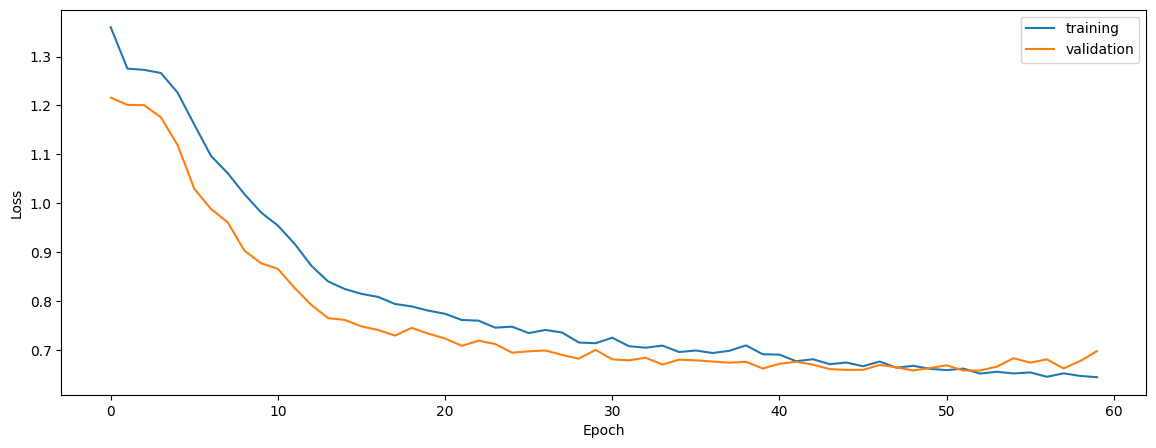

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


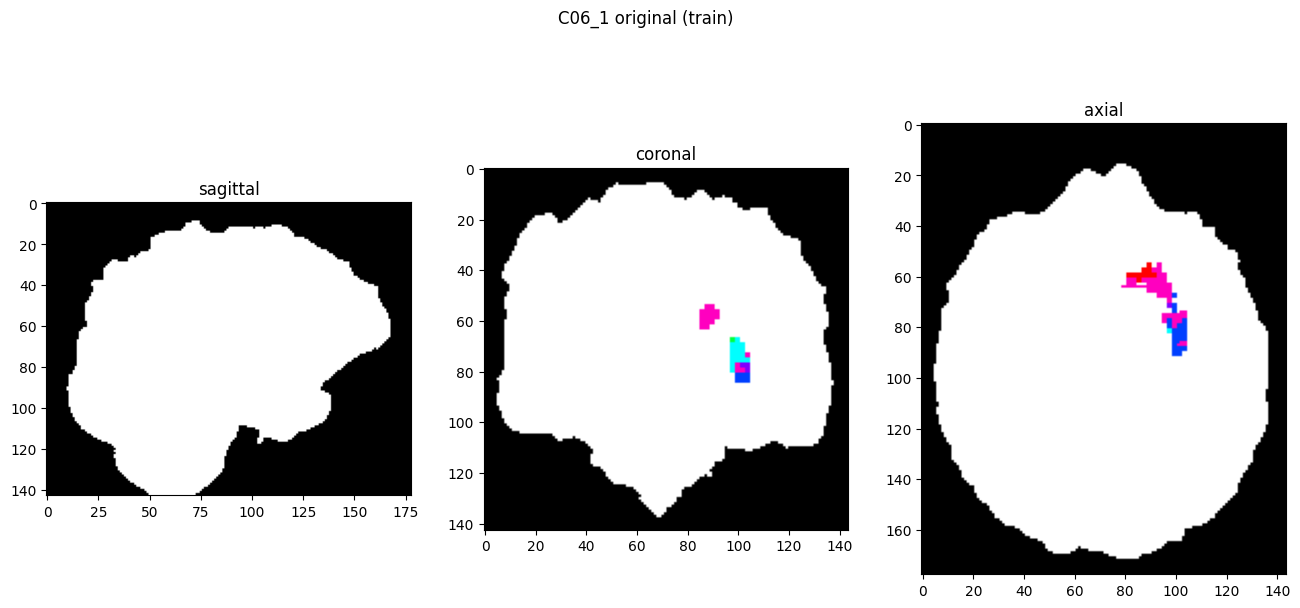

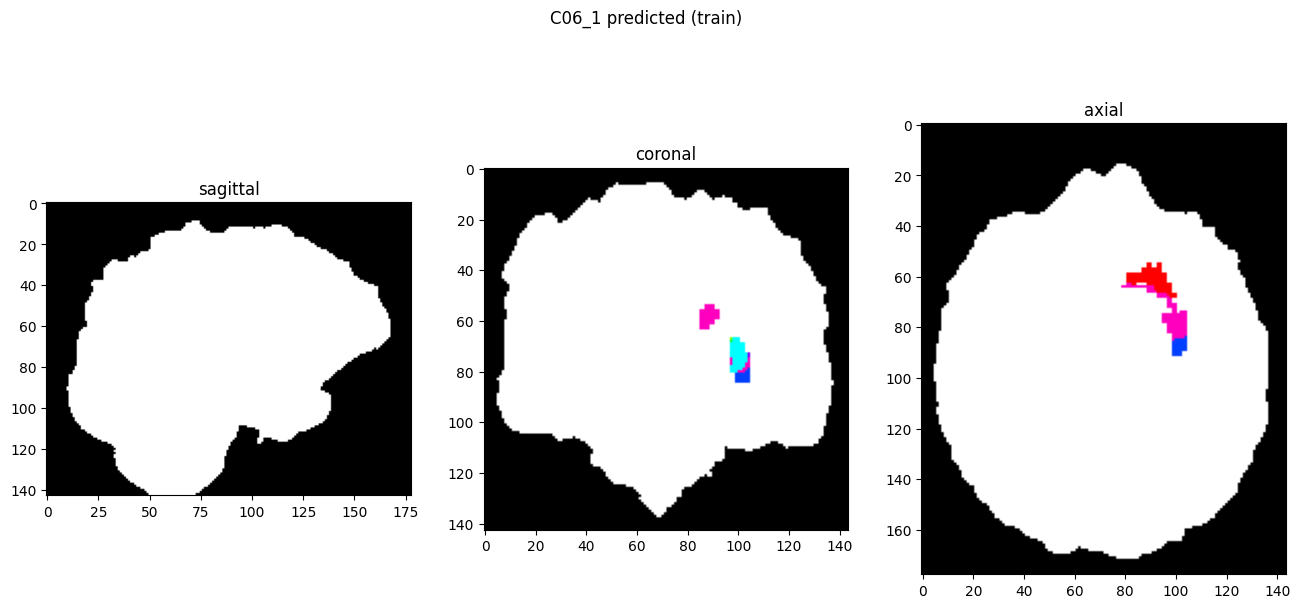

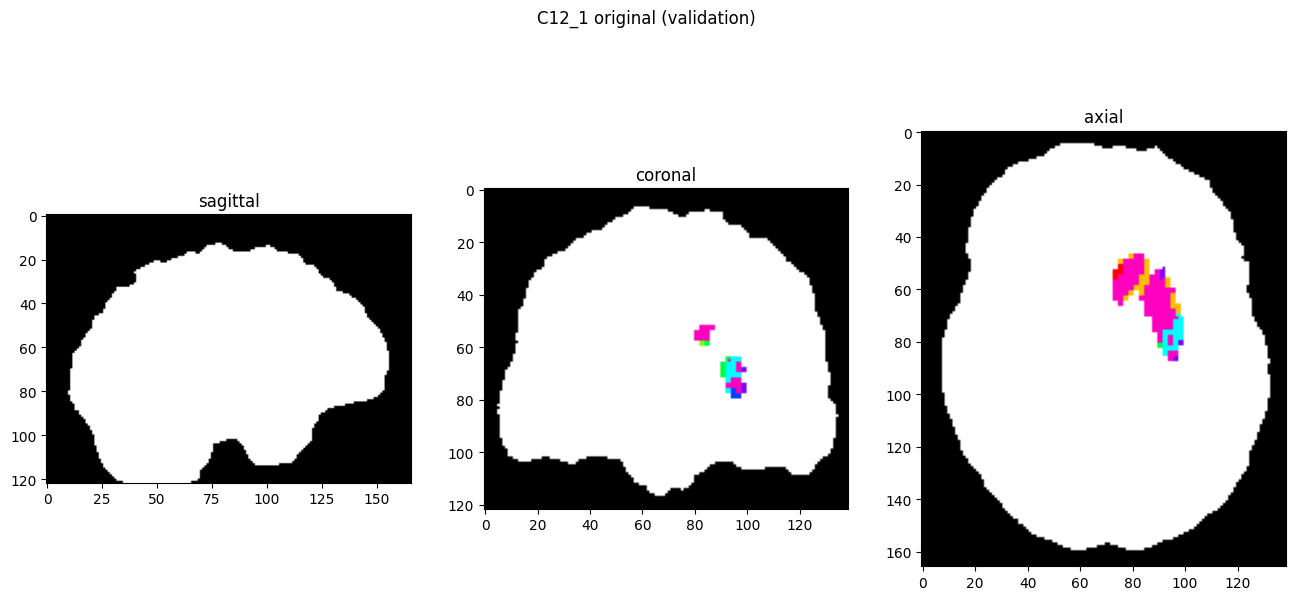

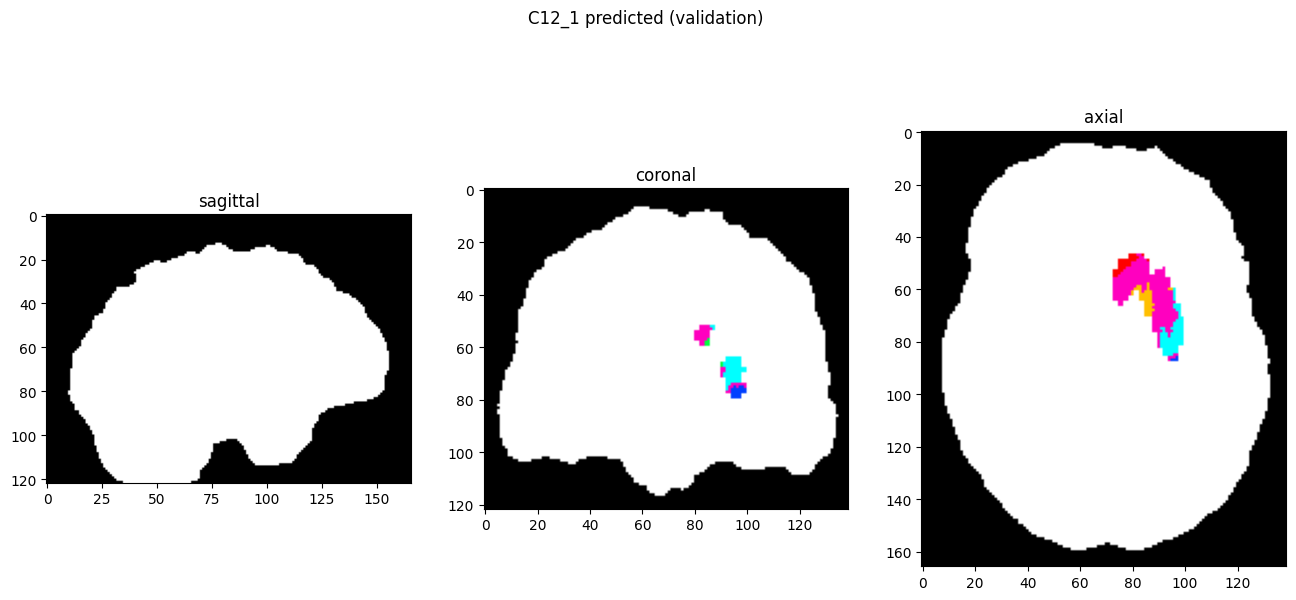

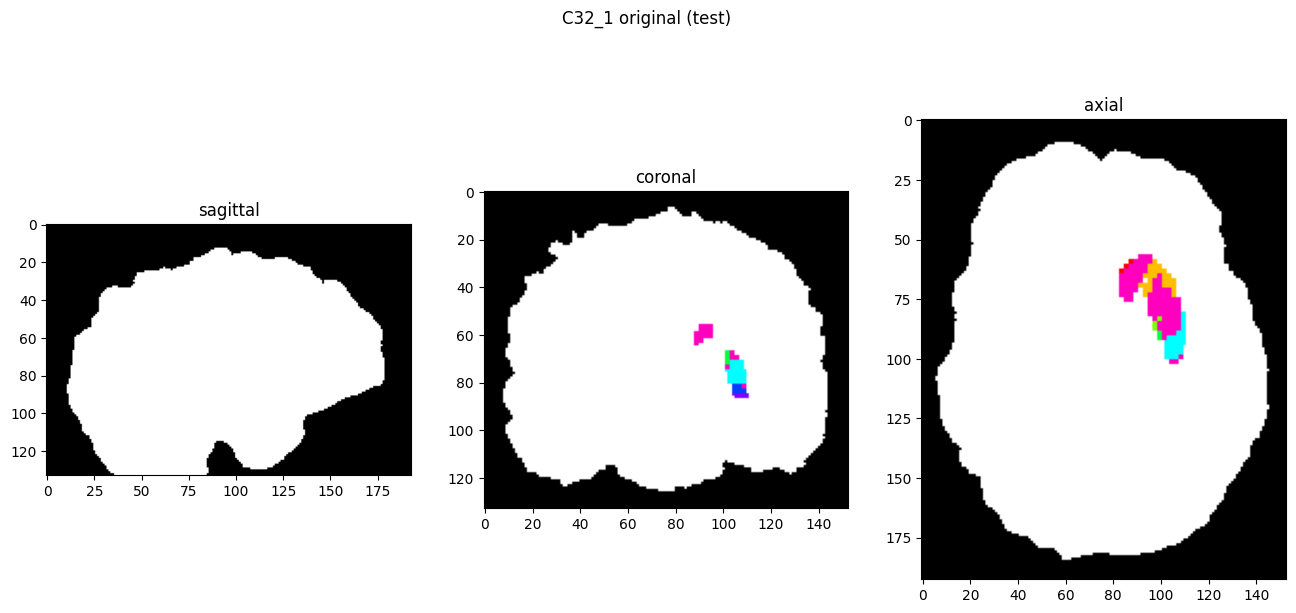

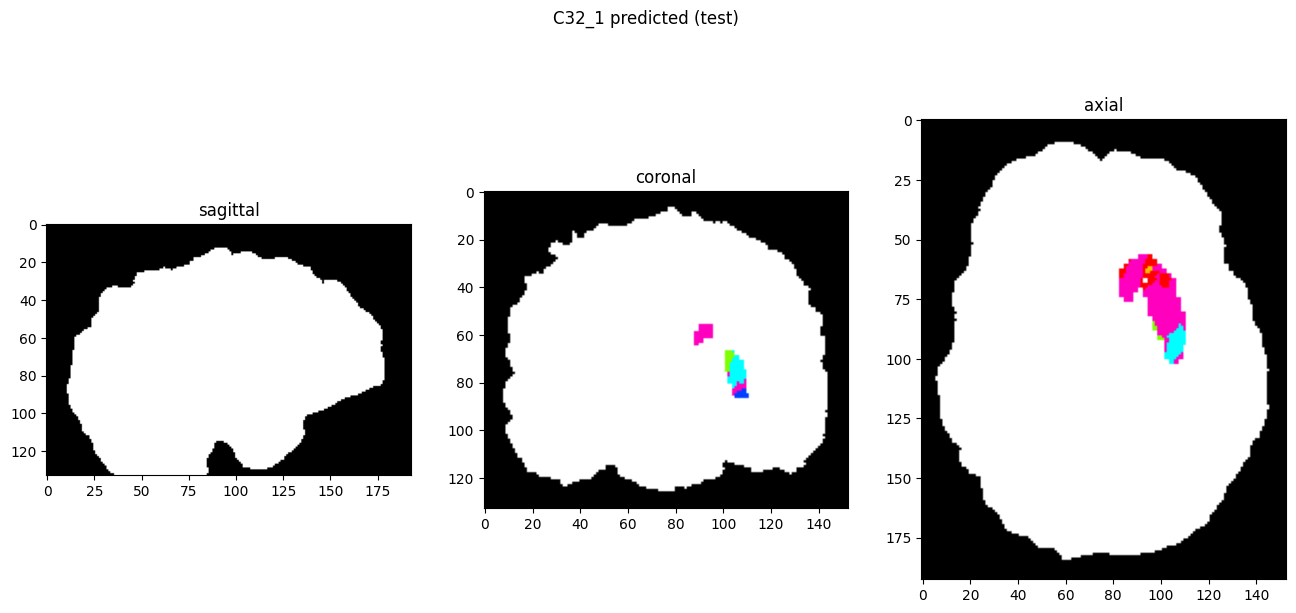

In [10]:
showResults(model, gen, threshold=0)